# **Linear Models - Multiple Linear Regressions and Logistic Regression**

## _Machine Learning Modelling Workflow Notebook 1_

## Content:

1. Separate and prepare features and responses tensors;
2. Splitting features and responses into train and test tensors;
3. Splitting time series into train and test tensors;
4. Creating a TensorFlow windowed dataset from a time series;
4. Retrieving the list of classes used for training the classification models;
5. Ordinary Least Squares (OLS) Linear Regression;
6. Ridge Linear Regression;
7. Lasso Linear Regression;
8. Elastic Net Linear Regression;
9. Logistic Regression (binary classification);
10. Getting a general feature ranking;
10. Calculating metrics for regression models;
11. Calculating metrics for classification models;
12. Making predictions with the models;
13. Calculating probabilities associated to each class;
14. Performing the SHAP feature importance analysis;
15. Time series visualization.

Marco Cesar Prado Soares, Data Scientist Specialist - Bayer Crop Science LATAM
- marcosoares.feq@gmail.com
- marco.soares@bayer.com

In [ ]:
# To install a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow
# to update a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow --upgrade
# to update pip, unmark and run:
# ! pip install pip --upgrade
# to show if a library is installed and visualize its information, unmark and run
# (e.g. tensorflow):
# ! pip show tensorflow
# To run a Python file (e.g idsw_etl.py) saved in the notebook's workspace directory,
# unmark and run:
# import idsw_etl
# or:
# import idsw_etl as etl

## **Load Python Libraries in Global Context**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# **Function for mounting Google Drive or S3 (AWS Simple Storage Service) bucket**

In [ ]:
def mount_storage_system (source = 'aws', path_to_store_imported_s3_bucket = '', s3_bucket_name = None, s3_obj_prefix = None):
    
    # source = 'google' for mounting the google drive;
    # source = 'aws' for mounting an AWS S3 bucket.
    
    # THE FOLLOWING PARAMETERS HAVE EFFECT ONLY WHEN source == 'aws'
    
    # path_to_store_imported_s3_bucket: path of the Python environment to which the
    # S3 bucket contents will be imported. If it is None, or if 
    # path_to_store_imported_s3_bucket = '/', bucket will be imported to the root path. 
    # Alternatively, input the path as a string (in quotes). e.g. 
    # path_to_store_imported_s3_bucket = 'copied_s3_bucket'
    
    # s3_bucket_name = None.
    ## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
    # with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
    # "aws-bucket-1"
    
    # s3_obj_prefix = None. Keep it None or as an empty string (s3_obj_key_prefix = '')
    # to import the whole bucket content, instead of a single object from it.
    # Alternatively, set it as a string containing the subfolder from the bucket to import:
    # Suppose that your bucket (admin-created) has four objects with the following object 
    # keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
    # s3-dg.pdf. The s3-dg.pdf key does not have a prefix, so its object appears directly 
    # at the root level of the bucket. If you open the Development/ folder, you see 
    # the Projects.xlsx object in it.
    # Check Amazon documentation:
    # https://docs.aws.amazon.com/AmazonS3/latest/userguide/object-keys.html
    
    # In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
    # where 'bucket' is the bucket's name, key_prefix = 'my_path/.../', without the
    # 'file.csv' (file name with extension) last part.
    
    # So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
    # a given folder (directory) of the bucket.
    # DO NOT PUT A SLASH before (to the right of) the prefix;
    # DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

    # Alternatively, provide the full path of a given file if you want to import only it:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
    # where my_file is the file's name, and ext is its extension.


    # Attention: after running this function for fetching AWS Simple Storage System (S3), 
    # your 'AWS Access key ID' and your 'Secret access key' will be requested.
    # The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
    # other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
    # and the prefix. All of these are sensitive information from the organization.
    # Therefore, after importing the information, always remember of cleaning the output of this cell
    # and of removing such information from the strings.
    # Remember that these data may contain privilege for accessing the information, so it should not
    # be used for non-authorized people.

    # Also, remember of deleting the imported files from the workspace after finishing the analysis.
    # The costs for storing the files in S3 is quite inferior than those for storing directly in the
    # workspace. Also, files stored in S3 may be accessed for other users than those with access to
    # the notebook's workspace.
    
    
    if (source == 'google'):
        
        from google.colab import drive
        # Google Colab library must be imported only in case it is
        # going to be used, for avoiding AWS compatibility issues.
        
        print("Associate the Python environment to your Google Drive account, and authorize the access in the opened window.")
        
        drive.mount('/content/drive')
        
        print("Now your Python environment is connected to your Google Drive: the root directory of your environment is now the root of your Google Drive.")
        print("In Google Colab, navigate to the folder icon (\'Files\') of the left navigation menu to find a specific folder or file in your Google Drive.")
        print("Click on the folder or file name and select the elipsis (...) icon on the right of the name to reveal the option \'Copy path\', which will give you the path to use as input for loading objects and files on your Python environment.")
        print("Caution: save your files into different directories of the Google Drive. If files are all saved in a same folder or directory, like the root path, they may not be accessible from your Python environment.")
        print("If you still cannot see the file after moving it to a different folder, reload the environment.")
    
    elif (source == 'aws'):
        
        import os
        import boto3
        # boto3 is AWS S3 Python SDK
        # sagemaker and boto3 libraries must be imported only in case 
        # they are going to be used, for avoiding 
        # Google Colab compatibility issues.
        from getpass import getpass

        # Check if path_to_store_imported_s3_bucket is None. If it is, make it the root directory:
        if ((path_to_store_imported_s3_bucket is None)|(str(path_to_store_imported_s3_bucket) == "/")):
            
            # For the S3 buckets, the path should not start with slash. Assign the empty
            # string instead:
            path_to_store_imported_s3_bucket = ""
            print("Bucket\'s content will be copied to the notebook\'s root directory.")
        
        elif (str(path_to_store_imported_s3_bucket) == ""):
            # Guarantee that the path is the empty string.
            # Avoid accessing the else condition, what would raise an error
            # since the empty string has no character of index 0
            path_to_store_imported_s3_bucket = str(path_to_store_imported_s3_bucket)
            print("Bucket\'s content will be copied to the notebook\'s root directory.")
        
        else:
            # Use the str attribute to guarantee that the path was read as a string:
            path_to_store_imported_s3_bucket = str(path_to_store_imported_s3_bucket)
            
            if(path_to_store_imported_s3_bucket[0] == "/"):
                # the first character is the slash. Let's remove it

                # In AWS, neither the prefix nor the path to which the file will be imported
                # (file from S3 to workspace) or from which the file will be exported to S3
                # (the path in the notebook's workspace) may start with slash, or the operation
                # will not be concluded. Then, we have to remove this character if it is present.

                # The slash is character 0. Then, we want all characters from character 1 (the
                # second) to character len(str(path_to_store_imported_s3_bucket)) - 1, the index
                # of the last character. So, we can slice the string from position 1 to position
                # the slicing syntax is: string[1:] - all string characters from character 1
                # string[:10] - all string characters from character 10-1 = 9 (including 9); or
                # string[1:10] - characters from 1 to 9
                # So, slice the whole string, starting from character 1:
                path_to_store_imported_s3_bucket = path_to_store_imported_s3_bucket[1:]
                # attention: even though strings may be seem as list of characters, that can be
                # sliced, we cannot neither simply assign a character to a given position nor delete
                # a character from a position.

        # Ask the user to provide the credentials:
        ACCESS_KEY = input("Enter your AWS Access Key ID here (in the right). It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
        print("\n") # line break
        SECRET_KEY = getpass("Enter your password (Secret key) here (in the right). It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
        
        # The use of 'getpass' instead of 'input' hide the password behind dots.
        # So, the password is not visible by other users and cannot be copied.
        
        print("\n")
        print("WARNING: The bucket\'s name, the prefix, the AWS access key ID, and the AWS Secret access key are all sensitive information, which may grant access to protected information from the organization.\n")
        print("After copying data from S3 to your workspace, remember of removing these information from the notebook, specially if it is going to be shared. Also, remember of removing the files from the workspace.\n")
        print("The cost for storing files in Simple Storage Service is quite inferior than the one for storing directly in SageMaker workspace. Also, files stored in S3 may be accessed for other users than those with access the notebook\'s workspace.\n")

        # Check if the user actually provided the mandatory inputs, instead
        # of putting None or empty string:
        if ((ACCESS_KEY is None) | (ACCESS_KEY == '')):
            print("AWS Access Key ID is missing. It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
            return "error"
        elif ((SECRET_KEY is None) | (SECRET_KEY == '')):
            print("AWS Secret Access Key is missing. It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
            return "error"
        elif ((s3_bucket_name is None) | (s3_bucket_name == '')):
            print ("Please, enter a valid S3 Bucket\'s name. Do not add sub-directories or folders (prefixes), only the name of the bucket itself.")
            return "error"
        
        else:
            # Use the str attribute to guarantee that all AWS parameters were properly read as strings, and not as
            # other variables (like integers or floats):
            ACCESS_KEY = str(ACCESS_KEY)
            SECRET_KEY = str(SECRET_KEY)
            s3_bucket_name = str(s3_bucket_name)
        
        if(s3_bucket_name[0] == "/"):
                # the first character is the slash. Let's remove it

                # In AWS, neither the prefix nor the path to which the file will be imported
                # (file from S3 to workspace) or from which the file will be exported to S3
                # (the path in the notebook's workspace) may start with slash, or the operation
                # will not be concluded. Then, we have to remove this character if it is present.

                # So, slice the whole string, starting from character 1 (as did for 
                # path_to_store_imported_s3_bucket):
                s3_bucket_name = s3_bucket_name[1:]

        # Remove any possible trailing (white and tab spaces) spaces
        # That may be present in the string. Use the Python string
        # rstrip method, which is the equivalent to the Trim function:
        # When no arguments are provided, the whitespaces and tabulations
        # are the removed characters
        # https://www.w3schools.com/python/ref_string_rstrip.asp?msclkid=ee2d05c3c56811ecb1d2189d9f803f65
        s3_bucket_name = s3_bucket_name.rstrip()
        ACCESS_KEY = ACCESS_KEY.rstrip()
        SECRET_KEY = SECRET_KEY.rstrip()
        # Since the user manually inputs the parameters ACCESS and SECRET_KEY,
        # it is easy to input whitespaces without noticing that.

        # Now process the non-obbligatory parameter.
        # Check if a prefix was passed as input parameter. If so, we must select only the names that start with
        # The prefix.
        # Example: in the bucket 'my_bucket' we have a directory 'dir1'.
        # In the main (root) directory, we have a file 'file1.json' like: '/file1.json'
        # If we pass the prefix 'dir1', we want only the files that start as '/dir1/'
        # such as: 'dir1/file2.json', excluding the file in the main (root) directory and excluding the files in other
        # directories. Also, we want to eliminate the file names with no extensions, like 'dir1/' or 'dir1/dir2',
        # since these object names represent folders or directories, not files.	

        if (s3_obj_prefix is None):
            print ("No prefix, specific object, or subdirectory provided.") 
            print (f"Then, retrieving all content from the bucket \'{s3_bucket_name}\'.\n")
        elif ((s3_obj_prefix == "/") | (s3_obj_prefix == '')):
            # The root directory in the bucket must not be specified starting with the slash
            # If the root "/" or the empty string '' is provided, make
            # it equivalent to None (no directory)
            s3_obj_prefix = None
            print ("No prefix, specific object, or subdirectory provided.") 
            print (f"Then, retrieving all content from the bucket \'{s3_bucket_name}\'.\n")
    
        else:
            # Since there is a prefix, use the str attribute to guarantee that the path was read as a string:
            s3_obj_prefix = str(s3_obj_prefix)
            
            if(s3_obj_prefix[0] == "/"):
                # the first character is the slash. Let's remove it

                # In AWS, neither the prefix nor the path to which the file will be imported
                # (file from S3 to workspace) or from which the file will be exported to S3
                # (the path in the notebook's workspace) may start with slash, or the operation
                # will not be concluded. Then, we have to remove this character if it is present.

                # So, slice the whole string, starting from character 1 (as did for 
                # path_to_store_imported_s3_bucket):
                s3_obj_prefix = s3_obj_prefix[1:]

            # Remove any possible trailing (white and tab spaces) spaces
            # That may be present in the string. Use the Python string
            # rstrip method, which is the equivalent to the Trim function:
            s3_obj_prefix = s3_obj_prefix.rstrip()
            
            # Store the total characters in the prefix string after removing the initial slash
            # and trailing spaces:
            prefix_len = len(s3_obj_prefix)
            
            print("AWS Access Credentials, and bucket\'s prefix, object or subdirectory provided.\n")	

            
        print ("Starting connection with the S3 bucket.\n")
        
        try:
            # Start S3 client as the object 's3_client'
            s3_client = boto3.resource('s3', aws_access_key_id = ACCESS_KEY, aws_secret_access_key = SECRET_KEY)
        
            print(f"Credentials accepted by AWS. S3 client successfully started.\n")
            # An object 'data_table.xlsx' in the main (root) directory of the s3_bucket is stored in Python environment as:
            # s3.ObjectSummary(bucket_name='bucket_name', key='data_table.xlsx')
            # The name of each object is stored as the attribute 'key' of the object.
        
        except:
            
            print("Failed to connect to AWS Simple Storage Service (S3). Review if your credentials are correct.")
            print("The variable \'access_key\' must be set as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("The variable \'secret_key\' must be set as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
        
        try:
            # Connect to the bucket specified as 'bucket_name'.
            # The bucket is started as the object 's3_bucket':
            s3_bucket = s3_client.Bucket(s3_bucket_name)
            print(f"Connection with bucket \'{s3_bucket_name}\' stablished.\n")
            
        except:
            
            print("Failed to connect with the bucket, which usually happens when declaring a wrong bucket\'s name.") 
            print("Check the spelling of your bucket_name string and remember that it must be all in lower-case.\n")
                

        # Then, let's obtain a list of all objects in the bucket (list bucket_objects):
        
        bucket_objects_list = []

        # Loop through all objects of the bucket:
        for stored_obj in s3_bucket.objects.all():
            
            # Loop through all elements 'stored_obj' from s3_bucket.objects.all()
            # Which stores the ObjectSummary for all objects in the bucket s3_bucket:
            # Let's store only the key attribute and use the str function
            # to guarantee that all values were stored as strings.
            bucket_objects_list.append(str(stored_obj.key))
        
        # Now start a support list to store only the elements from
        # bucket_objects_list that are not folders or directories
        # (objects with extensions).
        # If a prefix was provided, only files with that prefix should
        # be added:
        support_list = []
        
        for stored_obj in bucket_objects_list:
            
            # Loop through all elements 'stored_obj' from the list
            # bucket_objects_list

            # Check the file extension.
            file_extension = os.path.splitext(stored_obj)[1][1:]
            
            # The os.path.splitext method splits the string into its FIRST dot (".") to
            # separate the file extension from the full path. Example:
            # "C:/dir1/dir2/data_table.csv" is split into:
            # "C:/dir1/dir2/data_table" (root part) and '.csv' (extension part)
            # https://www.geeksforgeeks.org/python-os-path-splitext-method/?msclkid=2d56198fc5d311ec820530cfa4c6d574

            # os.path.splitext(stored_obj) is a tuple of strings: the first is the complete file
            # root with no extension; the second is the extension starting with a point: '.txt'
            # When we set os.path.splitext(stored_obj)[1], we are selecting the second element of
            # the tuple. By selecting os.path.splitext(stored_obj)[1][1:], we are taking this string
            # from the second character (index 1), eliminating the dot: 'txt'


            # Check if the file extension is not an empty string '' (i.e., that it is different from != the empty
            # string:
            if (file_extension != ''):
                    
                    # The extension is different from the empty string, so it is not neither a folder nor a directory
                    # The object is actually a file and may be copied if it satisfies the prefix condition. If there
                    # is no prefix to check, we may simply copy the object to the list.

                    # If there is a prefix, the first characters of the stored_obj must be the prefix:
                    if not (s3_obj_prefix is None):
                        
                        # Check the characters from the position 0 (1st character) to the position
                        # prefix_len - 1. Since a prefix was declared, we want only the objects that this first portion
                        # corresponds to the prefix. string[i:j] slices the string from index i to index j-1
                        # Then, the 1st portion of the string to check is: string[0:(prefix_len)]

                        # Slice the string stored_obj from position 0 (1st character) to position prefix_len - 1,
                        # The position that the prefix should end.
                        obj_name_first_part = (stored_obj)[0:(prefix_len)]
                        
                        # If this first part is the prefix, then append the object to 
                        # support list:
                        if (obj_name_first_part == (s3_obj_prefix)):

                                support_list.append(stored_obj)

                    else:
                        # There is no prefix, so we can simply append the object to the list:
                        support_list.append(stored_obj)

            
        # Make the objects list the support list itself:
        bucket_objects_list = support_list
            
        # Now, bucket_objects_list contains the names of all objects from the bucket that must be copied.

        print("Finished mapping objects to fetch. Now, all these objects from S3 bucket will be copied to the notebook\'s workspace, in the specified directory.\n")
        print(f"A total of {len(bucket_objects_list)} files were found in the specified bucket\'s prefix (\'{s3_obj_prefix}\').")
        print(f"The first file found is \'{bucket_objects_list[0]}\'; whereas the last file found is \'{bucket_objects_list[len(bucket_objects_list) - 1]}\'.")
            
        # Now, let's try copying the files:
            
        try:
            
            # Loop through all objects in the list bucket_objects and copy them to the workspace:
            for copied_object in bucket_objects_list:

                # Select the object in the bucket previously started as 's3_bucket':
                selected_object = s3_bucket.Object(copied_object)
            
                # Now, copy this object to the workspace:
                # Set the new file_path. Notice that by now, copied_object may be a string like:
                # 'dir1/.../dirN/file_name.ext', where dirN is the n-th directory and ext is the file extension.
                # We want only the file_name to joing with the path to store the imported bucket. So, we can use the
                # str.split method specifying the separator sep = '/' to break the string into a list of substrings.
                # The last element from this list will be 'file_name.ext'
                # https://www.w3schools.com/python/ref_string_split.asp?msclkid=135399b6c63111ecada75d7d91add056

                # 1. Break the copied_object full path into the list object_path_list, using the .split method:
                object_path_list = copied_object.split(sep = "/")

                # 2. Get the last element from this list. Since it has length len(object_path_list) and indexing starts from
                # zero, the index of the last element is (len(object_path_list) - 1):
                fetched_object = object_path_list[(len(object_path_list) - 1)]

                # 3. Finally, join the string fetched_object with the new path (path on the notebook's workspace) to finish
                # The new object's file_path:

                file_path = os.path.join(path_to_store_imported_s3_bucket, fetched_object)

                # Download the selected object to the workspace in the specified file_path
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" copies a xlsx file named 'my_table' to the notebook's main (root)
                # directory
                selected_object.download_file(Filename = file_path)

                print(f"The file \'{fetched_object}\' was successfully copied to notebook\'s workspace.\n")

                
            print("Finished copying the files from the bucket to the notebook\'s workspace. It may take a couple of minutes untill they be shown in SageMaker environment.\n") 
            print("Do not forget to delete these copies after finishing the analysis. They will remain stored in the bucket.\n")


        except:

            # Run this code for any other exception that may happen (no exception error
            # specified, so any exception runs the following code).
            # Check: https://pythonbasics.org/try-except/?msclkid=4f6b4540c5d011ecb1fe8a4566f632a6
            # for seeing how to handle successive exceptions

            print("Attention! The function raised an exception error, which is probably due to the AWS Simple Storage Service (S3) permissions.")
            print("Before running again this function, check this quick guide for configuring the permission roles in AWS.\n")
            print("It is necessary to create an user with full access permissions to interact with S3 from SageMaker. To configure the User, go to the upper ribbon of AWS, click on Services, and select IAM – Identity and Access Management.")
            print("1. In IAM\'s lateral panel, search for \'Users\' in the group of Access Management.")
            print("2. Click on the \'Add users\' button.")
            print("3. Set an user name in the text box \'User name\'.")
            print("Attention: users and S3 buckets cannot be written in upper case. Also, selecting a name already used by an Amazon user or bucket will raise an error message.\n")
            print("4. In the field \'Select type of Access to AWS\'-\'Select type of AWS credentials\' select the option \'Access key - Programmatic access\'. After that, click on the button \'Next: Permissions\'.")
            print("5. In the field \'Set Permissions\', keep the \'Add user to a group\' button marked.")
            print("6. In the field \'Add user to a group\', click on \'Create group\' (alternatively, you can be added to a group already configured or copy the permissions of another user.")
            print("7. In the text box \'Group\'s name\', set a name for the new group of permissions.")
            print("8. In the search bar below (\'Filter politics\'), search for a politics that fill your needs, and check the option button on the left of this politic. The politics \'AmazonS3FullAccess\' grants full access to the S3 content.")
            print("9. Finally, click on \'Create a group\'.")
            print("10. After the group is created, it will appear with a check box marked, over the previous groups. Keep it marked and click on the button \'Next: Tags\'.")
            print("11. Create and note down the Access key ID and Secret access key. You can also download a comma separated values (CSV) file containing the credentials for future use.")
            print("ATTENTION: These parameters are required for accessing the bucket\'s content from any application, including AWS SageMaker.")
            print("12. Click on \'Next: Review\' and review the user credentials information and permissions.")
            print("13. Click on \'Create user\' and click on the download button to download the CSV file containing the user credentials information.")
            print("The headers of the CSV file (the stored fields) is: \'User name, Password, Access key ID, Secret access key, Console login link\'.")
            print("You need both the values indicated as \'Access key ID\' and as \'Secret access key\' to fetch the S3 bucket.")
            print("\n") # line break
            print("After acquiring the necessary user privileges, use the boto3 library to fetch the bucket from the Python code. boto3 is AWS S3 Python SDK.")
            print("For fetching a specific bucket\'s file use the following code:\n")
            print("1. Set a variable \'access_key\' as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("2. Set a variable \'secret_key\' as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
            print("3. Set a variable \'bucket_name\' as a string containing only the name of the bucket. Do not add subdirectories, folders (prefixes), or file names.")
            print("Example: if your bucket is named \'my_bucket\' and its main directory contains folders like \'folder1\', \'folder2\', etc, do not declare bucket_name = \'my_bucket/folder1\', even if you only want files from folder1.")
            print("ALWAYS declare only the bucket\'s name: bucket_name = \'my_bucket\'.")
            print("4. Set a variable \'file_path\' containing the path from the bucket\'s subdirectories to the file you want to fetch. Include the file name and its extension.")
            print("If the file is stored in the bucket\'s root (main) directory: file_path = \"my_file.ext\".")
            print("If the path of the file in the bucket is: \'dir1/…/dirN/my_file.ext\', where dirN is the N-th subdirectory, and dir1 is a folder or directory of the main (root) bucket\'s directory: file_path = \"dir1/…/dirN/my_file.ext\".")
            print("Also, we say that \'dir1/…/dirN/\' is the file\'s prefix. Notice that the name of the bucket is never declared here as the path for fetching its content from the Python code.")
            print("5. Set a variable named \'new_path\' to store the path of the file copied to the notebook’s workspace. This path must contain the file name and its extension.")
            print("Example: if you want to copy \'my_file.ext\' to the root directory of the notebook’s workspace, set: new_path = \"/my_file.ext\".")
            print("6. Finally, declare the following code, which refers to the defined variables:\n")

            # Let's use triple quotes to declare a formated string
            example_code = """
                import boto3
                # Start S3 client as the object 's3_client'
                s3_client = boto3.resource('s3', aws_access_key_id = access_key, aws_secret_access_key = secret_key)
                # Connect to the bucket specified as 'bucket_name'.
                # The bucket is started as the object 's3_bucket':
                s3_bucket = s3_client.Bucket(bucket_name)
                # Select the object in the bucket previously started as 's3_bucket':
                selected_object = s3_bucket.Object(file_path)
                # Download the selected object to the workspace in the specified file_path
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" copies a xlsx file named 'my_table' to the notebook's main (root)
                # directory
                selected_object.download_file(Filename = new_path)
                """

            print(example_code)

            print("An object \'my_file.ext\' in the main (root) directory of the s3_bucket is stored in Python environment as:")
            print("""s3.ObjectSummary(bucket_name='bucket_name', key='my_file.ext'""") 
            # triple quotes to keep the internal quotes without using too much backslashes "\" (the ignore next character)
            print("Then, the name of each object is stored as the attribute \'key\' of the object. To view all objects, we can loop through their \'key\' attributes:\n")
            example_code = """
                # Loop through all objects of the bucket:
                for stored_obj in s3_bucket.objects.all():		
                    # Loop through all elements 'stored_obj' from s3_bucket.objects.all()
                    # Which stores the ObjectSummary for all objects in the bucket s3_bucket:
                    # Print the object’s names:
                    print(stored_obj.key)
                    """

            print(example_code)

                
    else:
        
        print("Select a valid source: \'google\' for mounting Google Drive; or \'aws\' for accessing AWS S3 Bucket.")

# **Function for loading the dataframe**

In [ ]:
def load_pandas_dataframe (file_directory_path, file_name_with_extension, load_txt_file_with_json_format = False, how_missing_values_are_registered = None, has_header = True, decimal_separator = '.', txt_csv_col_sep = "comma", load_all_sheets_at_once = False, sheet_to_load = None, json_record_path = None, json_field_separator = "_", json_metadata_prefix_list = None):
    
    # Pandas documentation:
    # pd.read_csv: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
    # pd.read_excel: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
    # pd.json_normalize: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html
    # Python JSON documentation:
    # https://docs.python.org/3/library/json.html
    
    import os
    import json
    import numpy as np
    import pandas as pd
    from pandas import json_normalize
    
    ## WARNING: Use this function to load dataframes stored on Excel (xls, xlsx, xlsm, xlsb, odf, ods and odt), 
    ## JSON, txt, or CSV (comma separated values) files. Tables in webpages or html files can also be read.
    
    # file_directory_path - (string, in quotes): input the path of the directory (e.g. folder path) 
    # where the file is stored. e.g. file_directory_path = "/" or file_directory_path = "/folder"
    
    # FILE_NAME_WITH_EXTENSION - (string, in quotes): input the name of the file with the 
    # extension. e.g. FILE_NAME_WITH_EXTENSION = "file.xlsx", or, 
    # FILE_NAME_WITH_EXTENSION = "file.csv", "file.txt", or "file.json"
    # Again, the extensions may be: xls, xlsx, xlsm, xlsb, odf, ods, odt, json, txt or csv. Also,
    # html files and webpages may be also read.
    
    # You may input the path for an HTML file containing a table to be read; or 
    # a string containing the address for a webpage containing the table. The address must start
    # with www or htpp. If a website is input, the full address can be input as FILE_DIRECTORY_PATH
    # or as FILE_NAME_WITH_EXTENSION.
    
    
    # load_txt_file_with_json_format = False. Set load_txt_file_with_json_format = True 
    # if you want to read a file with txt extension containing a text formatted as JSON 
    # (but not saved as JSON).
    # WARNING: if load_txt_file_with_json_format = True, all the JSON file parameters of the 
    # function (below) must be set. If not, an error message will be raised.
    
    # HOW_MISSING_VALUES_ARE_REGISTERED = None: keep it None if missing values are registered as None,
    # empty or np.nan. Pandas automatically converts None to NumPy np.nan objects (floats).
    # This parameter manipulates the argument na_values (default: None) from Pandas functions.
    # By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, 
    #‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘<NA>’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, 
    # ‘n/a’, ‘nan’, ‘null’.

    # If a different denomination is used, indicate it as a string. e.g.
    # HOW_MISSING_VALUES_ARE_REGISTERED = '.' will convert all strings '.' to missing values;
    # HOW_MISSING_VALUES_ARE_REGISTERED = 0 will convert zeros to missing values.

    # If dict passed, specific per-column NA values. For example, if zero is the missing value
    # only in column 'numeric_col', you can specify the following dictionary:
    # how_missing_values_are_registered = {'numeric-col': 0}
    
    
    # has_header = True if the the imported table has headers (row with columns names).
    # Alternatively, has_header = False if the dataframe does not have header.
    
    # DECIMAL_SEPARATOR = '.' - String. Keep it '.' or None to use the period ('.') as
    # the decimal separator. Alternatively, specify here the separator.
    # e.g. DECIMAL_SEPARATOR = ',' will set the comma as the separator.
    # It manipulates the argument 'decimal' from Pandas functions.
    
    # txt_csv_col_sep = "comma" - This parameter has effect only when the file is a 'txt'
    # or 'csv'. It informs how the different columns are separated.
    # Alternatively, txt_csv_col_sep = "comma", or txt_csv_col_sep = "," 
    # for columns separated by comma;
    # txt_csv_col_sep = "whitespace", or txt_csv_col_sep = " " 
    # for columns separated by simple spaces.
    # You can also set a specific separator as string. For example:
    # txt_csv_col_sep = '\s+'; or txt_csv_col_sep = '\t' (in this last example, the tabulation
    # is used as separator for the columns - '\t' represents the tab character).
    
    
    ## Parameters for loading Excel files:
    
    # load_all_sheets_at_once = False - This parameter has effect only when for Excel files.
    # If load_all_sheets_at_once = True, the function will return a list of dictionaries, each
    # dictionary containing 2 key-value pairs: the first key will be 'sheet', and its
    # value will be the name (or number) of the table (sheet). The second key will be 'df',
    # and its value will be the pandas dataframe object obtained from that sheet.
    # This argument has preference over sheet_to_load. If it is True, all sheets will be loaded.
    
    # sheet_to_load - This parameter has effect only when for Excel files.
    # keep sheet_to_load = None not to specify a sheet of the file, so that the first sheet
    # will be loaded.
    # sheet_to_load may be an integer or an string (inside quotes). sheet_to_load = 0
    # loads the first sheet (sheet with index 0); sheet_to_load = 1 loads the second sheet
    # of the file (index 1); sheet_to_load = "Sheet1" loads a sheet named as "Sheet1".
    # Declare a number to load the sheet with that index, starting from 0; or declare a
    # name to load the sheet with that name.
    
    
    ## Parameters for loading JSON files:
    
    # json_record_path (string): manipulate parameter 'record_path' from json_normalize method.
    # Path in each object to list of records. If not passed, data will be assumed to 
    # be an array of records. If a given field from the JSON stores a nested JSON (or a nested
    # dictionary) declare it here to decompose the content of the nested data. e.g. if the field
    # 'books' stores a nested JSON, declare, json_record_path = 'books'
    
    # json_field_separator = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
    # Nested records will generate names separated by sep. 
    # e.g., for json_field_separator = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
    # Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
    # the name of the columns of the dataframe will be formed by concatenating 'main_field', the
    # separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...
    
    # json_metadata_prefix_list: list of strings (in quotes). Manipulates the parameter 
    # 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
    # table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
    # will be repeated in the rows of the dataframe to give the metadata (context) of the rows.
    
    # e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
    # 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
    # Here, there are nested JSONs in the field 'books'. The fields that are not nested
    # are 'name' and 'last'.
    # Then, json_record_path = 'books'
    # json_metadata_prefix_list = ['name', 'last']
    
    if (file_directory_path is None):
        file_directory_path = ''
    if (file_name_with_extension is None):
        file_name_with_extension = ''
    
    # Create the complete file path:
    file_path = os.path.join(file_directory_path, file_name_with_extension)
    
    # Extract the file extension
    file_extension = os.path.splitext(file_path)[1][1:]
    # os.path.splitext(file_path) is a tuple of strings: the first is the complete file
    # root with no extension; the second is the extension starting with a point: '.txt'
    # When we set os.path.splitext(file_path)[1], we are selecting the second element of
    # the tuple. By selecting os.path.splitext(file_path)[1][1:], we are taking this string
    # from the second character (index 1), eliminating the dot: 'txt'
    
    if(file_extension not in ['xls', 'xlsx', 'xlsm', 'xlsb', 'odf',
                              'ods', 'odt', 'json', 'txt', 'csv', 'html']):
        
        # Check if it is a webpage by evaluating the 3 to 5 initial characters:
        # Notice that 'https' contains 'http'
        if ((file_path[:3] == 'www') | (file_path[:4] == '/www') | (file_path[:4] == 'http')| (file_path[:5] == '/http'):
            file_extension = 'html'

            # If the address starts with a slash (1st character), remove it:
            if (file_path[0] == '/'):
                # Pick all characters from index 1:
                file_path = file_path[1:]
    
        
    # Check if the decimal separator is None. If it is, set it as '.' (period):
    if (decimal_separator is None):
        decimal_separator = '.'
    
    if ((file_extension == 'txt') | (file_extension == 'csv')): 
        # The operator & is equivalent to 'And' (intersection).
        # The operator | is equivalent to 'Or' (union).
        # pandas.read_csv method must be used.
        if (load_txt_file_with_json_format == True):
            
            print("Reading a txt file containing JSON parsed data. A reading error will be raised if you did not set the JSON parameters.\n")
            
            with open(file_path, 'r') as opened_file:
                # 'r' stands for read mode; 'w' stands for write mode
                # read the whole file as a string named 'file_full_text'
                file_full_text = opened_file.read()
                # if we used the readlines() method, we would be reading the
                # file by line, not the whole text at once.
                # https://stackoverflow.com/questions/8369219/how-to-read-a-text-file-into-a-string-variable-and-strip-newlines?msclkid=a772c37bbfe811ec9a314e3629df4e1e
                # https://www.tutorialkart.com/python/python-read-file-as-string/#:~:text=example.py%20%E2%80%93%20Python%20Program.%20%23open%20text%20file%20in,and%20prints%20it%20to%20the%20standard%20output.%20Output.?msclkid=a7723a1abfe811ecb68bba01a2b85bd8
                
            #Now, file_full_text is a string containing the full content of the txt file.
            json_file = json.loads(file_full_text)
            # json.load() : This method is used to parse JSON from URL or file.
            # json.loads(): This method is used to parse string with JSON content.
            # e.g. .json.loads() must be used to read a string with JSON and convert it to a flat file
            # like a dataframe.
            # check: https://www.pythonpip.com/python-tutorials/how-to-load-json-file-using-python/#:~:text=The%20json.load%20%28%29%20is%20used%20to%20read%20the,and%20alter%20data%20in%20our%20application%20or%20system.
            dataset = json_normalize(json_file, record_path = json_record_path, sep = json_field_separator, meta = json_metadata_prefix_list)
        
        else:
            # Not a JSON txt
        
            if (has_header == True):

                if ((txt_csv_col_sep == "comma") | (txt_csv_col_sep == ",")):

                    dataset = pd.read_csv(file_path, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    # verbose = True for showing number of NA values placed in non-numeric columns.
                    #  parse_dates = True: try parsing the index; infer_datetime_format = True : If True and parse_dates is enabled, pandas will attempt to infer the format of the datetime strings in 
                    # the columns, and if it can be inferred, switch to a faster method of parsing them. In some cases this can increase the 
                    # parsing speed by 5-10x.

                elif ((txt_csv_col_sep == "whitespace") | (txt_csv_col_sep == " ")):

                    dataset = pd.read_csv(file_path, delim_whitespace = True, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    
                    
                else:
                    
                    try:
                        
                        # Try using the character specified as the argument txt_csv_col_sep:
                        dataset = pd.read_csv(file_path, sep = txt_csv_col_sep, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    
                    except:
                        # An error was raised, the separator is not valid
                        print(f"Enter a valid column separator for the {file_extension} file, like: \'comma\' or \'whitespace\'.")


            else:
                # has_header == False

                if ((txt_csv_col_sep == "comma") | (txt_csv_col_sep == ",")):

                    dataset = pd.read_csv(file_path, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)

                    
                elif ((txt_csv_col_sep == "whitespace") | (txt_csv_col_sep == " ")):

                    dataset = pd.read_csv(file_path, delim_whitespace = True, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    
                    
                else:
                    
                    try:
                        
                        # Try using the character specified as the argument txt_csv_col_sep:
                        dataset = pd.read_csv(file_path, sep = txt_csv_col_sep, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True, infer_datetime_format = True, decimal = decimal_separator)
                    
                    except:
                        # An error was raised, the separator is not valid
                        print(f"Enter a valid column separator for the {file_extension} file, like: \'comma\' or \'whitespace\'.")

    elif (file_extension == 'json'):
        
        with open(file_path, 'r') as opened_file:
            
            json_file = json.load(opened_file)
            # The structure json_file = json.load(open(file_path)) relies on the GC to close the file. That's not a 
            # good idea: If someone doesn't use CPython the garbage collector might not be using refcounting (which 
            # collects unreferenced objects immediately) but e.g. collect garbage only after some time.
            # Since file handles are closed when the associated object is garbage collected or closed 
            # explicitly (.close() or .__exit__() from a context manager) the file will remain open until 
            # the GC kicks in.
            # Using 'with' ensures the file is closed as soon as the block is left - even if an exception 
            # happens inside that block, so it should always be preferred for any real application.
            # source: https://stackoverflow.com/questions/39447362/equivalent-ways-to-json-load-a-file-in-python
            
        # json.load() : This method is used to parse JSON from URL or file.
        # json.loads(): This method is used to parse string with JSON content.
        # Then, json.load for a .json file
        # and json.loads for text file containing json
        # check: https://www.pythonpip.com/python-tutorials/how-to-load-json-file-using-python/#:~:text=The%20json.load%20%28%29%20is%20used%20to%20read%20the,and%20alter%20data%20in%20our%20application%20or%20system.   
        dataset = json_normalize(json_file, record_path = json_record_path, sep = json_field_separator, meta = json_metadata_prefix_list)
    
            
    elif (file_extension == 'html'):    
        
        if (has_header == True):
            
            dataset = pd.read_html(file_path, na_values = how_missing_values_are_registered, parse_dates = True, decimal = decimal_separator)
            
        else:
            
            dataset = pd.read_html(file_path, header = None, na_values = how_missing_values_are_registered, parse_dates = True, decimal = decimal_separator)
        
        
    else:
        # If it is not neither a csv nor a txt file, let's assume it is one of different
        # possible Excel files.
        print("Excel file inferred. If an error message is shown, check if a valid file extension was used: \'xlsx\', \'xls\', etc.\n")
        # For Excel type files, Pandas automatically detects the decimal separator and requires only the parameter parse_dates.
        # Firstly, the argument infer_datetime_format was present on read_excel function, but was removed.
        # From version 1.4 (beta, in 10 May 2022), it will be possible to pass the parameter 'decimal' to
        # read_excel function for detecting decimal cases in strings. For numeric variables, it is not needed, though
        
        if (load_all_sheets_at_once == True):
            
            # Corresponds to setting sheet_name = None
            
            if (has_header == True):
                
                xlsx_doc = pd.read_excel(file_path, sheet_name = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                # verbose = True for showing number of NA values placed in non-numeric columns.
                #  parse_dates = True: try parsing the index; infer_datetime_format = True : If True and parse_dates is enabled, pandas will attempt to infer the format of the datetime strings in 
                # the columns, and if it can be inferred, switch to a faster method of parsing them. In some cases this can increase the 
                # parsing speed by 5-10x.
                
            else:
                #No header
                xlsx_doc = pd.read_excel(file_path, sheet_name = None, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
            
            # xlsx_doc is a dictionary containing the sheet names as keys, and dataframes as items.
            # Let's convert it to the desired format.
            # Dictionary dict, dict.keys() is the array of keys; dict.values() is an array of the values;
            # and dict.items() is an array of tuples with format ('key', value)
            
            # Create a list of returned datasets:
            list_of_datasets = []
            
            # Let's iterate through the array of tuples. The first element returned is the key, and the
            # second is the value
            for sheet_name, dataframe in (xlsx_doc.items()):
                # sheet_name = key; dataframe = value
                # Define the dictionary with the standard format:
                df_dict = {'sheet': sheet_name,
                            'df': dataframe}
                
                # Add the dictionary to the list:
                list_of_datasets.append(df_dict)
            
            print("\n")
            print(f"A total of {len(list_of_datasets)} dataframes were retrieved from the Excel file.\n")
            print(f"The dataframes correspond to the following Excel sheets: {list(xlsx_doc.keys())}\n")
            print("Returning a list of dictionaries. Each dictionary contains the key \'sheet\', with the original sheet name; and the key \'df\', with the Pandas dataframe object obtained.\n")
            print(f"Check the 10 first rows of the dataframe obtained from the first sheet, named {list_of_datasets[0]['sheet']}:\n")
            
            try:
                # only works in Jupyter Notebook:
                from IPython.display import display
                display((list_of_datasets[0]['df']).head(10))
            
            except: # regular mode
                print((list_of_datasets[0]['df']).head(10))
            
            return list_of_datasets
            
        elif (sheet_to_load is not None):        
        #Case where the user specifies which sheet of the Excel file should be loaded.
            
            if (has_header == True):
                
                dataset = pd.read_excel(file_path, sheet_name = sheet_to_load, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                # verbose = True for showing number of NA values placed in non-numeric columns.
                #  parse_dates = True: try parsing the index; infer_datetime_format = True : If True and parse_dates is enabled, pandas will attempt to infer the format of the datetime strings in 
                # the columns, and if it can be inferred, switch to a faster method of parsing them. In some cases this can increase the 
                # parsing speed by 5-10x.
                
            else:
                #No header
                dataset = pd.read_excel(file_path, sheet_name = sheet_to_load, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                
        
        else:
            #No sheet specified
            if (has_header == True):
                
                dataset = pd.read_excel(file_path, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                
            else:
                #No header
                dataset = pd.read_excel(file_path, header = None, na_values = how_missing_values_are_registered, verbose = True, parse_dates = True)
                
    print(f"Dataset extracted from {file_path}. Check the 10 first rows of this dataframe:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(dataset.head(10))
            
    except: # regular mode
        print(dataset.head(10))
    
    return dataset

# **Function for converting JSON object to dataframe**
- Objects may be:
    - String with JSON formatted text;
    - List with nested dictionaries (JSON formatted);
    - Each dictionary may contain nested dictionaries, or nested lists of dictionaries (nested JSON).

In [ ]:
def json_obj_to_pandas_dataframe (json_obj_to_convert, json_obj_type = 'list', json_record_path = None, json_field_separator = "_", json_metadata_prefix_list = None):
    
    import json
    import pandas as pd
    from pandas import json_normalize
    
    # JSON object in terms of Python structure: list of dictionaries, where each value of a
    # dictionary may be a dictionary or a list of dictionaries (nested structures).
    # example of highly nested structure saved as a list 'json_formatted_list'. Note that the same
    # structure could be declared and stored into a string variable. For instance, if you have a txt
    # file containing JSON, you could read the txt and save its content as a string.
    # json_formatted_list = [{'field1': val1, 'field2': {'dict_val': dict_val}, 'field3': [{
    # 'nest1': nest_val1}, {'nest2': nestval2}]}, {'field1': val1, 'field2': {'dict_val': dict_val}, 
    # 'field3': [{'nest1': nest_val1}, {'nest2': nestval2}]}]    

    # json_obj_type = 'list', in case the object was saved as a list of dictionaries (JSON format)
    # json_obj_type = 'string', in case it was saved as a string (text) containing JSON.

    # json_obj_to_convert: object containing JSON, or string with JSON content to parse.
    # Objects may be: string with JSON formatted text;
    # list with nested dictionaries (JSON formatted);
    # dictionaries, possibly with nested dictionaries (JSON formatted).
    
    # https://docs.python.org/3/library/json.html
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html#pandas.json_normalize
    
    # json_record_path (string): manipulate parameter 'record_path' from json_normalize method.
    # Path in each object to list of records. If not passed, data will be assumed to 
    # be an array of records. If a given field from the JSON stores a nested JSON (or a nested
    # dictionary) declare it here to decompose the content of the nested data. e.g. if the field
    # 'books' stores a nested JSON, declare, json_record_path = 'books'
    
    # json_field_separator = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
    # Nested records will generate names separated by sep. 
    # e.g., for json_field_separator = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
    # Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
    # the name of the columns of the dataframe will be formed by concatenating 'main_field', the
    # separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...
    
    # json_metadata_prefix_list: list of strings (in quotes). Manipulates the parameter 
    # 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
    # table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
    # will be repeated in the rows of the dataframe to give the metadata (context) of the rows.
    
    # e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
    # 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
    # Here, there are nested JSONs in the field 'books'. The fields that are not nested
    # are 'name' and 'last'.
    # Then, json_record_path = 'books'
    # json_metadata_prefix_list = ['name', 'last']

    
    if (json_obj_type == 'string'):
        # Use the json.loads method to convert the string to json
        json_file = json.loads(json_obj_to_convert)
        # json.load() : This method is used to parse JSON from URL or file.
        # json.loads(): This method is used to parse string with JSON content.
        # e.g. .json.loads() must be used to read a string with JSON and convert it to a flat file
        # like a dataframe.
        # check: https://www.pythonpip.com/python-tutorials/how-to-load-json-file-using-python/#:~:text=The%20json.load%20%28%29%20is%20used%20to%20read%20the,and%20alter%20data%20in%20our%20application%20or%20system.
    
    elif (json_obj_type == 'list'):
        
        # make the json_file the object itself:
        json_file = json_obj_to_convert
    
    else:
        print ("Enter a valid JSON object type: \'list\', in case the JSON object is a list of dictionaries in JSON format; or \'string\', if the JSON is stored as a text (string variable).")
        return "error"
    
    dataset = json_normalize(json_file, record_path = json_record_path, sep = json_field_separator, meta = json_metadata_prefix_list)
    
    print(f"JSON object converted to a flat dataframe object. Check the 10 first rows of this dataframe:\n")
    
    try:
        # only works in Jupyter Notebook:
        from IPython.display import display
        display(dataset.head(10))
            
    except: # regular mode
        print(dataset.head(10))
    
    return dataset

# **Function for time series visualization**

In [ ]:
def time_series_vis (data_in_same_column = False, df = None, column_with_predict_var_x = None, column_with_response_var_y = None, column_with_labels = None, list_of_dictionaries_with_series_to_analyze = [{'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}], x_axis_rotation = 70, y_axis_rotation = 0, grid = True, add_splines_lines = True, add_scatter_dots = False, horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
     
    import random
    # Python Random documentation:
    # https://docs.python.org/3/library/random.html?msclkid=9d0c34b2d13111ec9cfa8ddaee9f61a1
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    
    # matplotlib.colors documentation:
    # https://matplotlib.org/3.5.0/api/colors_api.html?msclkid=94286fa9d12f11ec94660321f39bf47f
    
    # Matplotlib list of colors:
    # https://matplotlib.org/stable/gallery/color/named_colors.html?msclkid=0bb86abbd12e11ecbeb0a2439e5b0d23
    # Matplotlib colors tutorial:
    # https://matplotlib.org/stable/tutorials/colors/colors.html
    # Matplotlib example of Python code using matplotlib.colors:
    # https://matplotlib.org/stable/_downloads/0843ee646a32fc214e9f09328c0cd008/colors.py
    # Same example as Jupyter Notebook:
    # https://matplotlib.org/stable/_downloads/2a7b13c059456984288f5b84b4b73f45/colors.ipynb
    
        
    # data_in_same_column = False: set as True if all the values to plot are in a same column.
    # If data_in_same_column = True, you must specify the dataframe containing the data as df;
    # the column containing the predict variable (X) as column_with_predict_var_x; the column 
    # containing the responses to plot (Y) as column_with_response_var_y; and the column 
    # containing the labels (subgroup) indication as column_with_labels. 
    # df is an object, so do not declare it in quotes. The other three arguments (columns' names) 
    # are strings, so declare in quotes. 
    
    # Example: suppose you have a dataframe saved as dataset, and two groups A and B to compare. 
    # All the results for both groups are in a column named 'results', wich will be plot against
    # the time, saved as 'time' (X = 'time'; Y = 'results'). If the result is for
    # an entry from group A, then a column named 'group' has the value 'A'. If it is for group B,
    # column 'group' shows the value 'B'. In this example:
    # data_in_same_column = True,
    # df = dataset,
    # column_with_predict_var_x = 'time',
    # column_with_response_var_y = 'results', 
    # column_with_labels = 'group'
    # If you want to declare a list of dictionaries, keep data_in_same_column = False and keep
    # df = None (the other arguments may be set as None, but it is not mandatory: 
    # column_with_predict_var_x = None, column_with_response_var_y = None, column_with_labels = None).
    

    # Parameter to input when DATA_IN_SAME_COLUMN = False:
    # list_of_dictionaries_with_series_to_analyze: if data is already converted to series, lists
    # or arrays, provide them as a list of dictionaries. It must be declared as a list, in brackets,
    # even if there is a single dictionary.
    # Use always the same keys: 'x' for the X-series (predict variables); 'y' for the Y-series
    # (response variables); and 'lab' for the labels. If you do not want to declare a series, simply
    # keep as None, but do not remove or rename a key (ALWAYS USE THE KEYS SHOWN AS MODEL).
    # If you want, you can remove elements (dictionaries) from the list to declare fewer elements;
    # and you can also add more elements (dictionaries) to the lists, if you need to plot more series.
    # Simply put a comma after the last element from the list and declare a new dictionary, keeping the
    # same keys: {'x': x_series, 'y': y_series, 'lab': label}, where x_series, y_series and label
    # represents the series and label of the added dictionary (you can pass 'lab': None, but if 
    # 'x' or 'y' are None, the new dictionary will be ignored).
    
    # Examples:
    # list_of_dictionaries_with_series_to_analyze = 
    # [{'x': DATASET['X'], 'y': DATASET['Y'], 'lab': 'label'}]
    # will plot a single variable. In turns:
    # list_of_dictionaries_with_series_to_analyze = 
    # [{'x': DATASET['X'], 'y': DATASET['Y1'], 'lab': 'label'}, {'x': DATASET['X'], 'y': DATASET['Y2'], 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}]
    # will plot two series, Y1 x X and Y2 x X.
    # Notice that all dictionaries where 'x' or 'y' are None are automatically ignored.
    # If None is provided to 'lab', an automatic label will be generated.
    
    
    # List the possible numeric data types for a Pandas dataframe column:
    numeric_dtypes = [np.int16, np.int32, np.int64, np.float16, np.float32, np.float64]
    
    if (data_in_same_column == True):
        
        print("Data to be plotted in a same column.\n")
        
        if (df is None):
            
            print("Please, input a valid dataframe as df.\n")
            list_of_dictionaries_with_series_to_analyze = []
            # The code will check the size of this list on the next block.
            # If it is zero, code is simply interrupted.
            # Instead of returning an error, we use this code structure that can be applied
            # on other graphic functions that do not return a summary (and so we should not
            # return a value like 'error' to interrupt the function).
        
        elif (column_with_predict_var_x is None):
            
            print("Please, input a valid column name as column_with_predict_var_x.\n")
            list_of_dictionaries_with_series_to_analyze = []
           
        elif (column_with_response_var_y is None):
            
            print("Please, input a valid column name as column_with_response_var_y.\n")
            list_of_dictionaries_with_series_to_analyze = []
        
        else:
            
            # set a local copy of the dataframe:
            DATASET = df.copy(deep = True)
            
            if (column_with_labels is None):
            
                print("Using the whole series (column) for correlation.\n")
                column_with_labels = 'whole_series_' + column_with_response_var_y
                DATASET[column_with_labels] = column_with_labels
            
            # sort DATASET; by column_with_predict_var_x; by column column_with_labels
            # and by column_with_response_var_y, all in Ascending order
            # Since we sort by label (group), it is easier to separate the groups.
            DATASET = DATASET.sort_values(by = [column_with_predict_var_x, column_with_labels, column_with_response_var_y], ascending = [True, True, True])
            
            # Reset indices:
            DATASET = DATASET.reset_index(drop = True)
            
            # If column_with_predict_var_x is an object, the user may be trying to pass a date as x. 
            # So, let's try to convert it to datetime:
            if ((DATASET[column_with_predict_var_x]).dtype not in numeric_dtypes):
                  
                try:
                    DATASET[column_with_predict_var_x] = (DATASET[column_with_predict_var_x]).astype('datetime64[ns]')
                    print("Variable X successfully converted to datetime64[ns].\n")
                    
                except:
                    # Simply ignore it
                    pass
            
            # Get a series of unique values of the labels, and save it as a list using the
            # list attribute:
            unique_labels = list(DATASET[column_with_labels].unique())
            print(f"{len(unique_labels)} different labels detected: {unique_labels}.\n")
            
            # Start a list to store the dictionaries containing the keys:
            # 'x': list of predict variables; 'y': list of responses; 'lab': the label (group)
            list_of_dictionaries_with_series_to_analyze = []
            
            # Loop through each possible label:
            for lab in unique_labels:
                # loop through each element from the list unique_labels, referred as lab
                
                # Set a filter for the dataset, to select only rows correspondent to that
                # label:
                boolean_filter = (DATASET[column_with_labels] == lab)
                
                # Create a copy of the dataset, with entries selected by that filter:
                ds_copy = (DATASET[boolean_filter]).copy(deep = True)
                # Sort again by X and Y, to guarantee the results are in order:
                ds_copy = ds_copy.sort_values(by = [column_with_predict_var_x, column_with_response_var_y], ascending = [True, True])
                # Restart the index of the copy:
                ds_copy = ds_copy.reset_index(drop = True)
                
                # Re-extract the X and Y series and convert them to NumPy arrays 
                # (these arrays will be important later in the function):
                x = np.array(ds_copy[column_with_predict_var_x])
                y = np.array(ds_copy[column_with_response_var_y])
            
                # Then, create the dictionary:
                dict_of_values = {'x': x, 'y': y, 'lab': lab}
                
                # Now, append dict_of_values to list_of_dictionaries_with_series_to_analyze:
                list_of_dictionaries_with_series_to_analyze.append(dict_of_values)
                
            # Now, we have a list of dictionaries with the same format of the input list.
            
    else:
        
        # The user input a list_of_dictionaries_with_series_to_analyze
        # Create a support list:
        support_list = []
        
        # Loop through each element on the list list_of_dictionaries_with_series_to_analyze:
        
        for i in range (0, len(list_of_dictionaries_with_series_to_analyze)):
            # from i = 0 to i = len(list_of_dictionaries_with_series_to_analyze) - 1, index of the
            # last element from the list
            
            # pick the i-th dictionary from the list:
            dictionary = list_of_dictionaries_with_series_to_analyze[i]
            
            # access 'x', 'y', and 'lab' keys from the dictionary:
            x = dictionary['x']
            y = dictionary['y']
            lab = dictionary['lab']
            # Remember that all this variables are series from a dataframe, so we can apply
            # the astype function:
            # https://www.askpython.com/python/built-in-methods/python-astype?msclkid=8f3de8afd0d411ec86a9c1a1e290f37c
            
            # check if at least x and y are not None:
            if ((x is not None) & (y is not None)):
                
                # If column_with_predict_var_x is an object, the user may be trying to pass a date as x. 
                # So, let's try to convert it to datetime:
                if (x.dtype not in numeric_dtypes):

                    try:
                        x = (x).astype('datetime64[ns]')
                        print(f"Variable X from {i}-th dictionary successfully converted to datetime64[ns].\n")

                    except:
                        # Simply ignore it
                        pass
                
                # Possibly, x and y are not ordered. Firstly, let's merge them into a temporary
                # dataframe to be able to order them together.
                # Use the 'list' attribute to guarantee that x and y were read as lists. These lists
                # are the values for a dictionary passed as argument for the constructor of the
                # temporary dataframe. When using the list attribute, we make the series independent
                # from its origin, even if it was created from a Pandas dataframe. Then, we have a
                # completely independent dataframe that may be manipulated and sorted, without worrying
                # that it may modify its origin:
                
                temp_df = pd.DataFrame(data = {'x': list(x), 'y': list(y)})
                # sort this dataframe by 'x' and 'y':
                temp_df = temp_df.sort_values(by = ['x', 'y'], ascending = [True, True])
                # restart index:
                temp_df = temp_df.reset_index(drop = True)
                
                # Re-extract the X and Y series and convert them to NumPy arrays 
                # (these arrays will be important later in the function):
                x = np.array(temp_df['x'])
                y = np.array(temp_df['y'])
                
                # check if lab is None:
                if (lab is None):
                    # input a default label.
                    # Use the str attribute to convert the integer to string, allowing it
                    # to be concatenated
                    lab = "X" + str(i) + "_x_" + "Y" + str(i)
                    
                # Then, create the dictionary:
                dict_of_values = {'x': x, 'y': y, 'lab': lab}
                
                # Now, append dict_of_values to support list:
                support_list.append(dict_of_values)
            
        # Now, support_list contains only the dictionaries with valid entries, as well
        # as labels for each collection of data. The values are independent from their origin,
        # and now they are ordered and in the same format of the data extracted directly from
        # the dataframe.
        # So, make the list_of_dictionaries_with_series_to_analyze the support_list itself:
        list_of_dictionaries_with_series_to_analyze = support_list
        print(f"{len(list_of_dictionaries_with_series_to_analyze)} valid series input.\n")

        
    # Now that both methods of input resulted in the same format of list, we can process both
    # with the same code.
    
    # Each dictionary in list_of_dictionaries_with_series_to_analyze represents a series to
    # plot. So, the total of series to plot is:
    total_of_series = len(list_of_dictionaries_with_series_to_analyze)
    
    if (total_of_series <= 0):
        
        print("No valid series to plot. Please, provide valid arguments.\n")
    
    else:
        
        # Continue to plotting and calculating the fitting.
        # Notice that we sorted the all the lists after they were separated and before
        # adding them to dictionaries. Also, the timestamps were converted to datetime64 variables
        # Now we finished the loop, list_of_dictionaries_with_series_to_analyze 
        # contains all series converted to NumPy arrays, with timestamps parsed as datetimes.
        # This list will be the object returned at the end of the function. Since it is an
        # JSON-formatted list, we can use the function json_obj_to_pandas_dataframe to convert
        # it to a Pandas dataframe.
        
        
        # Now, we can plot the figure.
        # we set alpha = 0.95 (opacity) to give a degree of transparency (5%), 
        # so that one series do not completely block the visualization of the other.
        
        # Let's retrieve the list of Matplotlib CSS colors:
        css4 = mcolors.CSS4_COLORS
        # css4 is a dictionary of colors: {'aliceblue': '#F0F8FF', 'antiquewhite': '#FAEBD7', ...}
        # Each key of this dictionary is a color name to be passed as argument color on the plot
        # function. So let's retrieve the array of keys, and use the list attribute to convert this
        # array to a list of colors:
        list_of_colors = list(css4.keys())
        
        # In 11 May 2022, this list of colors had 148 different elements
        # Since this list is in alphabetic order, let's create a random order for the colors.
        
        # Function random.sample(input_sequence, number_of_samples): 
        # this function creates a list containing a total of elements equals to the parameter 
        # "number_of_samples", which must be an integer.
        # This list is obtained by ramdomly selecting a total of "number_of_samples" elements from the
        # list "input_sequence" passed as parameter.
        
        # Function random.choices(input_sequence, k = number_of_samples):
        # similarly, randomly select k elements from the sequence input_sequence. This function is
        # newer than random.sample
        # Since we want to simply randomly sort the sequence, we can pass k = len(input_sequence)
        # to obtain the randomly sorted sequence:
        list_of_colors = random.choices(list_of_colors, k = len(list_of_colors))
        # Now, we have a random list of colors to use for plotting the charts
        
        if (add_splines_lines == True):
            LINE_STYLE = '-'

        else:
            LINE_STYLE = ''
        
        if (add_scatter_dots == True):
            MARKER = 'o'
            
        else:
            MARKER = ''
        
        # Matplotlib linestyle:
        # https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html?msclkid=68737f24d16011eca9e9c4b41313f1ad
        
        if (plot_title is None):
            # Set graphic title
            plot_title = f"Y_x_timestamp"

        if (horizontal_axis_title is None):
            # Set horizontal axis title
            horizontal_axis_title = "timestamp"

        if (vertical_axis_title is None):
            # Set vertical axis title
            vertical_axis_title = "Y"
        
        # Let's put a small degree of transparency (1 - OPACITY) = 0.05 = 5%
        # so that the bars do not completely block other views.
        OPACITY = 0.95
        
        #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
        fig = plt.figure(figsize = (12, 8))
        ax = fig.add_subplot()

        i = 0 # Restart counting for the loop of colors
        
        # Loop through each dictionary from list_of_dictionaries_with_series_and_predictions:
        for dictionary in list_of_dictionaries_with_series_to_analyze:
            
            # Try selecting a color from list_of_colors:
            try:
                
                COLOR = list_of_colors[i]
                # Go to the next element i, so that the next plot will use a different color:
                i = i + 1
            
            except IndexError:
                
                # This error will be raised if list index is out of range, 
                # i.e. if i >= len(list_of_colors) - we used all colors from the list (at least 148).
                # So, return the index to zero to restart the colors from the beginning:
                i = 0
                COLOR = list_of_colors[i]
                i = i + 1
            
            # Access the arrays and label from the dictionary:
            X = dictionary['x']
            Y = dictionary['y']
            LABEL = dictionary['lab']
            
            # Scatter plot:
            ax.plot(X, Y, linestyle = LINE_STYLE, marker = MARKER, color = COLOR, alpha = OPACITY, label = LABEL)
            # Axes.plot documentation:
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html?msclkid=42bc92c1d13511eca8634a2c93ab89b5
            
            # x and y are positional arguments: they are specified by their position in function
            # call, not by an argument name like 'marker'.
            
            # Matplotlib markers:
            # https://matplotlib.org/stable/api/markers_api.html?msclkid=36c5eec5d16011ec9583a5777dc39d1f
            
        # Now we finished plotting all of the series, we can set the general configuration:
        
        #ROTATE X AXIS IN XX DEGREES
        plt.xticks(rotation = x_axis_rotation)
        # XX = 0 DEGREES x_axis (Default)
        #ROTATE Y AXIS IN XX DEGREES:
        plt.yticks(rotation = y_axis_rotation)
        # XX = 0 DEGREES y_axis (Default)

        ax.set_title(plot_title)
        ax.set_xlabel(horizontal_axis_title)
        ax.set_ylabel(vertical_axis_title)

        ax.grid(grid) # show grid or not
        ax.legend(loc = 'upper left')
        # position options: 'upper right'; 'upper left'; 'lower left'; 'lower right';
        # 'right', 'center left'; 'center right'; 'lower center'; 'upper center', 'center'
        # https://www.statology.org/matplotlib-legend-position/

        if (export_png == True):
            # Image will be exported
            import os

            #check if the user defined a directory path. If not, set as the default root path:
            if (directory_to_save is None):
                #set as the default
                directory_to_save = ""

            #check if the user defined a file name. If not, set as the default name for this
            # function.
            if (file_name is None):
                #set as the default
                file_name = "time_series_vis"

            #check if the user defined an image resolution. If not, set as the default 110 dpi
            # resolution.
            if (png_resolution_dpi is None):
                #set as 330 dpi
                png_resolution_dpi = 330

            #Get the new_file_path
            new_file_path = os.path.join(directory_to_save, file_name)

            #Export the file to this new path:
            # The extension will be automatically added by the savefig method:
            plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
            #quality could be set from 1 to 100, where 100 is the best quality
            #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
            #transparent = True or False
            # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
            print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

        #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
        #plt.figure(figsize = (12, 8))
        #fig.tight_layout()

        ## Show an image read from an image file:
        ## import matplotlib.image as pltimg
        ## img=pltimg.imread('mydecisiontree.png')
        ## imgplot = plt.imshow(img)
        ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
        ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
        ##  '03_05_END.ipynb'
        plt.show()

# **Classes for Modelling**

In [ ]:
class model_checking:
            
    # Initialize instance attributes.
    # define the Class constructor, i.e., how are its objects:
    def __init__(self, model_object = None, model_type = 'regression', model_package = 'tensorflow', column_map_dict = None, training_history_object = None, X = None, y_train = None, y_preds_for_train = None, y_test = None, y_preds_for_test = None, y_valid = None, y_preds_for_validation = None):
        
        import numpy as np
        import tensorflow as tf

        # Add the model:        
        self.model = model_object
        # It can be None: user can firstly call the object to retrieve the total classes, and
        # then call it again with the model adjusted for that amount of classes.
        
        # model_type = 'regression' or 'classification'
        self.model_type = model_type
        
        if (model_type == 'regression'):
            self.metrics_name = 'mean_absolute_error'
        
        else:
            self.metrics_name = 'acc'
        
        # Add model package: 'tensorflow' (and keras), 'sklearn', or 'xgboost':
        self.package = model_package

        # Add the columns names:
        self.column_map_dict = column_map_dict
        # Add the training history to the class:
        self.history = training_history_object

        # Add the y series for computing general metrics:
        # Guarantee that they are tensorflow tensors
        if (y_train is not None):
            if (len(y_train) > 0):
                self.y_train = tf.constant(y_train)
            else:
                self.y_train = None
        else:
            self.y_train = None
        if (y_preds_for_train is not None):
            if (len(y_preds_for_train) > 0):
                self.y_preds_for_train = tf.constant(y_preds_for_train)
            else:
                self.y_train = None
        else:
            self.y_train = None
        if (y_test is not None):
            if (len(y_test) > 0):
                self.y_test = tf.constant(y_test)
            else:
                self.y_test = None
        else:
            self.y_test = None
        if (y_preds_for_test is not None):
            if (len(y_preds_for_test) > 0):
                self.y_preds_for_test = tf.constant(y_preds_for_test)
            else:
                self.y_preds_for_test = None
        else:
            self.y_preds_for_test = None
        if (y_valid is not None):
            if (len(y_valid) > 0):
                self.y_valid = tf.constant(y_valid)
            else:
                self.y_valid = None
        else:
            self.y_valid = None
        if (y_preds_for_validation is not None):
            if (len(y_preds_for_validation) > 0):
                self.y_preds_for_validation = tf.constant(y_preds_for_validation)
            else:
                self.y_preds_for_validation = None
        else:
            self.y_preds_for_validation = None

        # X can be X_train, X_test, or X_valid. 
        # We only want to obtain the total number of predictors. X.shape is like:
        # TensorShape([253, 11]). Second index [1] is the number of predictors:
        if (X is not None):
            if (len(X) > 0):
                # make sure it is a tensor:
                X = tf.constant(X)
                total_predictors = X.shape[1]
                self.total_predictors = total_predictors
            else:
                X = None

        # to check the class attributes, use the __dict__ method or the vars function. Examples:
        ## object.__dict__ will show all attributes from object
        ## vars(object) shows the same.
                
    # Define the class methods.
    # All methods must take an object from the class (self) as one of the parameters
    
    def model_metrics (self, show_confusion_matrix_values = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
        
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        import seaborn as sns
        import tensorflow as tf
        # https://www.tensorflow.org/api_docs/python/tf/keras/metrics?authuser=1
        from sklearn.metrics import classification_report, confusion_matrix, r2_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
        from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error
        from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
        

        # Retrieve type of problem:
        model_type = self.model_type

        # Retrieve the tensors.
        tensors_dict = {}
        tensors_dict['training'] = {'actual': self.y_train, 'predictions': self.y_preds_for_train}
        tensors_dict['testing'] = {'actual': self.y_test, 'predictions': self.y_preds_for_test}
        tensors_dict['validation'] = {'actual': self.y_valid, 'predictions': self.y_preds_for_validation}

        metrics_dict = {}
        
        # Loop through the keys:
        for key in tensors_dict.keys():
          
            # Retrieve the nested dictionary:
            nested_dict = tensors_dict[key]
            # Retrieve actual and predicted values:
            y_true =  nested_dict['actual']
            y_pred = nested_dict['predictions']
            # Check if there is no None value stored:
            
            if ((y_true is not None) & (y_pred is not None)):

                calculated_metrics = {}
                
                y_true = np.array(y_true)
                y_pred = np.array(y_pred)
                
                try:
                
                    # Regression metrics:
                    if (model_type == 'regression'):

                        print(f"Metrics for {key}:\n")
                        mse = mean_squared_error(y_true, y_pred)

                        # Print in scientific notation:
                        try:
                            print(f"Mean squared error (MSE) = {mse:e}")
                        except:
                            print(f"Mean squared error (MSE) = {mse}")
                        # Add to calculated metrics:
                        calculated_metrics['mse'] = mse

                        rmse = mse**(1/2)

                        try:
                            print(f"Root mean squared error (RMSE) = {rmse:e}")
                        except:
                            print(f"Root mean squared error (RMSE) = {rmse}")
                        # Add to calculated metrics:
                        calculated_metrics['rmse'] = rmse

                        mae = mean_absolute_error(y_true, y_pred)

                        # Print in scientific notation:
                        try:
                            print(f"Mean absolute error (MAE) = {mae:e}")
                        except:
                            print(f"Mean absolute error (MAE) = {mae}")
                        # Add to calculated metrics:
                        calculated_metrics['mae'] = mae

                        # Mean absolute percentage error: non-stable Sklearn function
                        # y_true and y_pred must be already numpy arrays:
                        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

                        # Print in scientific notation:
                        try:
                            print(f"Mean absolute percentage error (MAPE) = {mape:e}")
                        except:
                            print(f"Mean absolute percentage error (MAPE) = {mape}")
                        # Add to calculated metrics:
                        calculated_metrics['mape'] = mape

                        r2 = r2_score(y_true, y_pred)

                        try:
                            print(f"Coefficient of linear correlation R² = {r2:e}")
                        except:
                            print(f"Coefficient of linear correlation R² = {r2}")
                        # Add to calculated metrics:
                        calculated_metrics['r_squared'] = r2

                        # Manually correct R²:
                        # n_size_train = number of sample size
                        # k_model = number of independent variables of the defined model
                        k_model = self.total_predictors
                        #numer of rows
                        n_size = len(y_true)
                        r2_adj = 1 - (1 - r2)*(n_size - 1)/(n_size - k_model - 1)

                        try:
                            print(f"Adjusted coefficient of correlation R²-adj = {r2_adj:e}")
                        except:
                            print(f"Adjusted coefficient of correlation R²-adj = {r2_adj}")

                        # Add to calculated metrics:
                        calculated_metrics['r_squared_adj'] = r2_adj

                        explained_var = explained_variance_score(y_true, y_pred)
                        # Print in scientific notation:
                        try:
                            print(f"Explained variance = {explained_var:e}")

                        except:
                            print(f"Explained variance = {explained_var}")

                        # Explained variance is similar to the R² score, goes from 0 to 1, with the notable 
                        # difference that it does not account for systematic offsets in the prediction.
                        calculated_metrics['explained_variance'] = explained_var

                        print("\n")
                        # Now, add the metrics to the metrics_dict:
                        metrics_dict[key] = calculated_metrics

                    else:

                        print(f"Metrics for {key}:\n")

                        auc = roc_auc_score(y_true, y_pred)

                        try:
                            print(f"AUC = {auc:e}")
                        except:
                            print(f"AUC = {auc}")
                        # Add to calculated metrics:
                        calculated_metrics['auc'] = auc

                        acc = accuracy_score(y_true, y_pred)

                        try:
                            print(f"Accuracy = {acc:e}")
                        except:
                            print(f"Accuracy = {acc}")
                        # Add to calculated metrics:
                        calculated_metrics['accuracy'] = acc

                        precision = precision_score(y_true, y_pred)

                        try:
                            print(f"Precision = {precision:e}")
                        except:
                            print(f"Precision = {precision}")
                        # Add to calculated metrics:
                        calculated_metrics['precision'] = precision

                        recall = recall_score(y_true, y_pred)

                        try:
                            print(f"Recall = {recall:e}")
                        except:
                            print(f"Recall = {recall}")
                        # Add to calculated metrics:
                        calculated_metrics['recall'] = recall

                        # The method update_state returns None, so it must be called without and equality

                        # Get the classification report:
                        print("\n")
                        print("Classification Report:\n")
                        # Convert tensors to NumPy arrays
                        report = classification_report (y_true, y_pred)
                        print(report)
                        # Add to calculated metrics:
                        calculated_metrics['classification_report'] = report
                        print("\n")

                        # Get the confusion matrix:
                        # Convert tensors to NumPy arrays
                        matrix = confusion_matrix (y_true, y_pred)
                        # Add to calculated metrics:
                        calculated_metrics['confusion_matrix'] = report
                        print("Confusion matrix:\n")

                        fig, ax = plt.subplots(figsize = (12, 8))
                        # possible color schemes (cmap) for the heat map: None, 'Blues_r',
                        # "YlGnBu",
                        # https://seaborn.pydata.org/generated/seaborn.heatmap.html?msclkid=73d24a00c1b211ec8aa1e7ab656e3ff4
                        # http://seaborn.pydata.org/tutorial/color_palettes.html?msclkid=daa091f1c1b211ec8c74553348177b45
                        ax = sns.heatmap(matrix, annot = show_confusion_matrix_values, fmt = ".0f", linewidths = .5, square = True, cmap = 'Blues_r');
                        #annot = True: shows the number corresponding to each square
                        #annot = False: do not show the number
                        plot_title = f"Accuracy Score for {key} = {acc:.2f}"
                        ax.set_title(plot_title)
                        ax.set_ylabel('Actual class')
                        ax.set_xlabel('Predicted class')

                        if (export_png == True):
                            # Image will be exported
                            import os

                            #check if the user defined a directory path. If not, set as the default root path:
                            if (directory_to_save is None):
                                #set as the default
                                directory_to_save = ""

                            #check if the user defined a file name. If not, set as the default name for this
                            # function.
                            if (file_name is None):
                                #set as the default
                                file_name = "confusion_matrix_" + key

                            else:
                                # add the train suffix, to differentiate from the test matrix:
                                file_name = file_name + "_" + key

                            #check if the user defined an image resolution. If not, set as the default 110 dpi
                            # resolution.
                            if (png_resolution_dpi is None):
                                #set as 330 dpi
                                png_resolution_dpi = 330

                            #Get the new_file_path
                            new_file_path = os.path.join(directory_to_save, file_name)

                            #Export the file to this new path:
                            # The extension will be automatically added by the savefig method:
                            plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
                            #quality could be set from 1 to 100, where 100 is the best quality
                            #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
                            #transparent = True or False
                            # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
                            print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

                        #fig.tight_layout()

                        ## Show an image read from an image file:
                        ## import matplotlib.image as pltimg
                        ## img=pltimg.imread('mydecisiontree.png')
                        ## imgplot = plt.imshow(img)
                        ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
                        ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
                        ##  '03_05_END.ipynb'
                        plt.show()

                        print("\n")
                        # Now, add the metrics to the metrics_dict:
                        metrics_dict[key] = calculated_metrics
                
                except:
                    print(f"Unable to retrieve metrics for {key}:\n")
                    metrics_dict[key] = {'metrics': f'No metrics retrieved for {key}'}
          
        # Now that we finished calculating metrics for all tensors, save the
        # dictionary as a class variable (attribute) and return the object:
        self.metrics_dict = metrics_dict
        
        return self
    
    def feature_importance_ranking (self, model_class = 'linear', orientation = 'vertical', horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):

        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt

        # model_class = 'linear' or model_class = 'tree'
        # Retrieve the model:
        model = self.model
        # Return the mapping dictionary:
        column_map_dict = self.column_map_dict
        model_type = self.model_type

        if (model_class == 'linear'):

            # Get the list of coefficients
            reg_coefficients = model.coef_
              
            try: 
                trial_access = reg_coefficients[1]
                # If the trial succeeded, reg_coefficients is in the correct format [coef1, coef2, ...]
                
                # reg_coefficients[0] is a scalar, not an array.
                # Convert the numpy array:
                reg_coefficients = np.array(reg_coefficients)
                abs_reg_coefficients = abs(reg_coefficients)
                
            except: 
                # The trial fails when reg_coefficients is an array containing a single array like 
                # [[coef1, coef2, ...]]
                # So, the index 0 stores the array of interest. 
                # Since coefficients may be negative, pick the absolute values from the array in index 0
                # (NumPy arrays accept vectorial operations, lists do not):
                reg_coefficients = np.array(reg_coefficients[0])
                abs_reg_coefficients = abs(reg_coefficients)
                # Already numpy arrays
            
            if (column_map_dict is not None):
                # Retrieve the values (columns' names):
                # Set as list
                columns_list = list(column_map_dict['features'].values())
            
            else:
                # Retrieve the values (columns' names):
                columns_list = [i for i in range(0, len(reg_coefficients))]
            
            # Get the intercept coefficient:
            print(f"Calculated model intercept = {model.intercept_}\n")
            
            try:
                # Create the regression dictionary:
                reg_dict = {'predictive_features': columns_list,
                          'regression_coefficients': reg_coefficients,
                           'abs_reg_coefficients': abs_reg_coefficients}

                # Convert it to a Pandas dataframe:
                feature_importance_df = pd.DataFrame(data = reg_dict)

                # Now sort the dataframe in descending order of coefficient, and ascending order of
                # feature (when sorting by multiple columns, we pass a list of columns to by and a 
                # list of booleans to ascending, instead of passing a simple string to by and a boolean
                # to ascending. The element on a given index from the list by corresponds to the boolean
                # with the same index in ascending):
                feature_importance_df = feature_importance_df.sort_values(by = ['abs_reg_coefficients', 'regression_coefficients', 'predictive_features'], ascending = [False, False, True])

                # Now that the dataframe is sorted in descending order, it represents the feature
                # importance ranking.

                # Restart the indices:
                feature_importance_df = feature_importance_df.reset_index(drop = True)
            
            except:
                print("Model has number of coefficients different from number of predictors.")
                print(f"Model's coefficients = {reg_coefficients}\n")


        elif (model_class == 'tree'):

            # Set the list of the predictors:
            # Use the list attribute to guarantee that it is a list:
            
            # Get the list of feature importances. Apply the list method to convert the
            # array from .feature_importances_ to a list:
            feature_importances = model.feature_importances_
                 
            try: 
                trial_access = feature_importances[1]
                # If the trial succeeded, feature_importances is in the correct format 
                # [coef1, coef2, ...]
                # feature_importances[0] is a scalar, not an array.
                feature_importances = np.array(feature_importances)
                abs_feature_importances = abs(feature_importances)
                             
            except: 
                # The trial fails when reg_coefficients is an array containing a single array like 
                # [[coef1, coef2, ...]]
                # So, the index 0 stores the array of interest. 
                # Since coefficients may be negative, pick the absolute values from the array in index 0
                # (NumPy arrays accept vectorial operations, lists do not):
                feature_importances = np.array(feature_importances[0])
                abs_feature_importances = abs(feature_importances)
                # feature_importances and abs_feature_importances are already numpy arrays
            
            if (column_map_dict is not None):
                # Retrieve the values (columns' names):
                columns_list = list(column_map_dict['features'].values())
                
            else:
                # Retrieve the values (columns' names):
                columns_list = [i for i in range(0, len(feature_importances))]
            
            try:
                # Create the model dictionary:
                model_dict = {'predictive_features': columns_list,
                            'feature_importances': feature_importances,
                            'abs_feature_importances': abs_feature_importances}

                # Convert it to a Pandas dataframe:
                feature_importance_df = pd.DataFrame(data = model_dict)
            
                # Now sort the dataframe in descending order of importance, and ascending order of
                # feature (when sorting by multiple columns, we pass a list of columns to by and a 
                # list of booleans to ascending, instead of passing a simple string to by and a boolean
                # to ascending. The element on a given index from the list by corresponds to the boolean
                # with the same index in ascending):
                feature_importance_df = feature_importance_df.sort_values(by = ['abs_feature_importances', 'feature_importances', 'predictive_features'], ascending = [False, False, True])

                # Now that the dataframe is sorted in descending order, it represents the feature
                # importance ranking.

                # Restart the indices:
                feature_importance_df = feature_importance_df.reset_index(drop = True)
            
            except:
                print("Model feature importance ranking generated a total of values different from number of predictors.")
                print(f"Model's feature_importances = {feature_importances}\n")

        try:  

            try:
                print("Feature importance ranking - until 20 most important features:\n")
                # only works in Jupyter Notebook:
                from IPython.display import display
                display(feature_importance_df.head(20))

            except: # regular mode
                print("Feature importance ranking - until 20 most important features:\n")
                print(feature_importance_df.head(20))

            # Save the feature importance ranking as a class variable (attribute):
            self.feature_importance_df = feature_importance_df

            features = feature_importance_df['predictive_features']

            if (model_class == 'linear'):
                importances = feature_importance_df['abs_reg_coefficients']

            elif (model_class == 'tree'):
                importances = feature_importance_df['abs_feature_importances']

            data_label = "feature_importance_ranking"

            # Normalize the importances by dividing all of them by the maximum:
            max_importance = max(importances)
            importances = importances/max_importance

            # Now, limit to 10 values to plot:
            importances = importances[:10]
            features = features[:10]

            # Now, plot the bar chart
            print("\n")
            print("Feature relative importance bar chart:\n")
            # Now the data is prepared and we only have to plot 
            # categories, responses, and cum_pct:

            # Let's put a small degree of transparency (1 - OPACITY) = 0.05 = 5%
            # so that the bars do not completely block other views.
            OPACITY = 0.95

            # Set labels and titles for the case they are None
            if (plot_title is None):

                plot_title = "feature_importance_bar_chart"

            if (horizontal_axis_title is None):

                horizontal_axis_title = "feature"

            if (vertical_axis_title is None):
                # Notice that response_var_name already has the suffix indicating the
                # aggregation function
                vertical_axis_title = "importance_score"

            fig, ax = plt.subplots(figsize = (12, 8))
            # Set image size (x-pixels, y-pixels) for printing in the notebook's cell:

            #ROTATE X AXIS IN XX DEGREES
            plt.xticks(rotation = x_axis_rotation)
            # XX = 70 DEGREES x_axis (Default)
            #ROTATE Y AXIS IN XX DEGREES:
            plt.yticks(rotation = y_axis_rotation)
            # XX = 0 DEGREES y_axis (Default)

            plt.title(plot_title)

            if (orientation == 'horizontal'):

                # invert the axes in relation to the default (vertical, below)
                ax.set_ylabel(horizontal_axis_title)
                ax.set_xlabel(vertical_axis_title, color = 'darkblue')

                # Horizontal bars used - barh method (bar horizontal):
                # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html
                # Now, the categorical variables stored in series categories must be
                # positioned as the vertical axis Y, whereas the correspondent responses
                # must be in the horizontal axis X.
                ax.barh(features, importances, color = 'darkblue', alpha = OPACITY, label = data_label)
                #.barh(y, x, ...)

            else: 

                ax.set_xlabel(horizontal_axis_title)
                ax.set_ylabel(vertical_axis_title, color = 'darkblue')
                # If None or an invalid orientation was used, set it as vertical
                # Use Matplotlib standard bar method (vertical bar):
                # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar

                # In this standard case, the categorical variables (categories) are positioned
                # as X, and the responses as Y:
                ax.bar(features, importances, color = 'darkblue', alpha = OPACITY, label = data_label)
                #.bar(x, y, ...)

            ax.legend()
            ax.grid(grid)

            # Notice that the .plot method is used for generating the plot for both orientations.
            # It is different from .bar and .barh, which specify the orientation of a bar; or
            # .hline (creation of an horizontal constant line); or .vline (creation of a vertical
            # constant line).

            # Now the parameters specific to the configurations are finished, so we can go back
            # to the general code:

            if (export_png == True):
                # Image will be exported
                import os

                #check if the user defined a directory path. If not, set as the default root path:
                if (directory_to_save is None):
                    #set as the default
                    directory_to_save = ""

                #check if the user defined a file name. If not, set as the default name for this
                # function.
                if (file_name is None):
                    #set as the default
                    file_name = "feature_importance_ranking"

                #check if the user defined an image resolution. If not, set as the default 110 dpi
                # resolution.
                if (png_resolution_dpi is None):
                    #set as 330 dpi
                    png_resolution_dpi = 330

                #Get the new_file_path
                new_file_path = os.path.join(directory_to_save, file_name)

                #Export the file to this new path:
                # The extension will be automatically added by the savefig method:
                plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
                #quality could be set from 1 to 100, where 100 is the best quality
                #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
                #transparent = True or False
                # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
                print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

            #fig.tight_layout()

            ## Show an image read from an image file:
            ## import matplotlib.image as pltimg
            ## img=pltimg.imread('mydecisiontree.png')
            ## imgplot = plt.imshow(img)
            ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
            ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
            ##  '03_05_END.ipynb'
            plt.show()
        
        except:
            print("Unable to generate plot correlating feature to its importance.\n")
            self.feature_importance_df = pd.DataFrame() # empty dataframe
        
        if (model_type == 'classification'):
            
            # Print meaning of classification metrics
            print("Metrics definitions:\n")
            print("True Positive (TP): the model correctly predicts a positive class output, i.e., it correctly predicts that the classified element belongs to that class (in binary classification, like in logistic regression, the model predicts the output 1 and the real output is also 1).")
            print("\n")
            print("True Negative (TN): the model correctly predicts a negative class output, i.e., it correctly predicts that the classified element do not belong to that class (in binary classification, the model predicts the output 0 and the real output is also 0).")
            print("\n")
            print("False Positive (FP, type 1 error): the model incorrectly predicts a positive class for a negative class-element, i.e., it predicts that the element belongs to that class, but it actually does not (in binary classification, the model predicts an output 1, but the correct output is 0).")
            print("\n")
            print("False Negative (FN, type 2 error): the model incorrectly predicts a negative class for a positive class-element, i.e., it predicts that the element does not belong to that class, but it actually does (in binary classification, the model predicts an output 0, but the correct output is 1).")
            print("\n")
            print("Naturally, the total number (TOTAL) of classifications is the sum of total correct predictions with total incorrect predictions, i.e., TOTAL = TP + TN + FP + FN")
            print("\n") # line break
            print("Accuracy: relation between the total number of correct classifications and the total number of classifications performed, i.e., Accuracy = (TP + TN)/(TOTAL)")
            print("\n")
            print("Precision: it is referrent to the attempt of answering the question: \'What is the proportion of positive identifications that were actually correct?\'.")
            print("In other words, Precision is the relation between the number of true positives and the total of positively-labelled classifications (true and false positives), i.e., Precision = (TP)/(TP + FP)")
            print("\n")
            print("Recall: it is referrent to the attempt of answering the question: \'What is the proportion of elements from positive class that were correctly classified?\'.")
            print("In other words, Recall is the relation between the number of true positives and the total of elements from the positive class (true positives and false negatives), i.e., Recall = (TP)/(TP + FN)")
            print("\n")
            print("F1: is the ROC-AUC score. In a generic classification problem, this metric is representative of the capability of the model in distinguishing classes.")     
            print("F1 =2/((1/Precision)+(1/Recall)) = (2*(Precision)*(Recall))/(Precision + Recall)")
            print("\n") # line break
            # Check:
            # https://towardsdatascience.com/how-to-evaluate-your-machine-learning-models-with-python-code-5f8d2d8d945b
                  
            print("Confusion Matrix Interpretation:\n")
            print("The confusion matrix is a table commonly used for describing the performance of a classification model (a classifier). It visually compares the model outputs with the correct data labels.")
            print("The matrix is divided into several sectors. For a binary classifier, it is divided into 4 quadrants.")
            print("\n")
            print("Each sector represents a given classification: in the vertical (Y) axis, the real observed labels are shown; whereas the predicted classes (model's outputs) are represented in the horizontal (X) axis.")
            print("Then, for each possible class, the following situations may happen: 1. The model predicted that the element belong to a given class, but it does not (incorrect prediction); or 2. The model predicted that the element belong to a given class, and it does (correct prediction).")
            print("If the output predicted y_pred (X-coordinate in the confusion matrix = y_pred) is the real label, then the Y-coordinate in the confusion matrix is also y_pred. For an element to have X and Y coordinates equal, it must be positioned on the principal diagonal of the matrix.")
            print("\n") #line break to highlight the next sentence
            print("So, we conclude that all the correct predictions of the model are positioned on the main or principal diagonal of the confusion matrix.")
            print("\n") # line break
            print("We also may conclude that an increase on model general accuracy is observed as an increase on the values shown in the main diagonal of the confusion matrix.")
            print("\n")
            print("Notice that this interpretation takes in account a matrix organized starting from the bottom to the top of Y axis (i.e., lower classes on the origin), and from the left to the right of the X-axis, with lower classes closer to the origin. If the order was the opposite, then the secondary diagonal that would contain the correct predictions.")
            print("If we have N possible classifications, than we have N values on axis X, and N values in axis Y. So, we have N x N = N2 (N squared) sectors (values) in the confusion matrix.\n")
            print("Confusion matrix for a binary classifier:\n")
            print("For a binary classifier, we have to possible outputs: 0 (the origin of the matrix) and 1. In the vertical axis, 1 is the topper value; in the horizontal axis, 1 is the value on the extreme right (the positions more distant from the origin).")
            print("Since N = 2, we have 2 x 2 = 4 quadrants (sectors or values).Starting from the origin, clockwise, we have 4 situations:")
            print("\n")
            print("Situation 1: X = 0 and Y = 0 - the model correctly predicted a negative output (it is a true negative prediction, TN).")
            print("Situation 2: X = 0 and Y = 1 - the model predicted a negative output for a positive class element (it is a false negative, FN).")
            print("Situation 3: X = 1 and Y = 1 - the model correctly predicted a positive class (TP).")
            print("Situation 4: X = 1 and Y = 0 - the model predicted a positive output for a negative class element (FP)\n")
            print("Each position of the confusion matrix represents the total of elements in each of the possible situations. Then, the sum of all values must be equal to the total of elements classified, and the relation between the sum of the main diagonal and the total of elements must be the accuracy.")
            print("So, use the confusion matrix to analyze the performance of the model in classifying each class, separately, and to observe the false negatives and false positives. Also, the confusion matrix will reveal if the classes are balanced, or ir a given class has much more elements than the other, what could impart the capability on differentiating the classes.")
            print("\n")
            print("For some models, the proportion of false positives may be very different from the proportion of false negatives. It is not a problem, though, and depend on the application of the classifier.")
            print("It is an important situation that would be masked by the general metrics that take in account all the predictions, without seggregating them through the classes.")
            print("\n")
            print("A classical example: suppose the classifier is used for predicting cancer. In this case, the model must have a proportion of false negatives much inferior than the proportion of false positives. That is because the risk associated to a false negative output is much higher.")
            print("A person who is incorrectly classified as having cancer will perform several more detailed exams to confirm the diagnosis, so the false positive may get detected without a great problem (in fact, the patient will probably feel good about it and keep taking care of the health). But a person incorrectly classified as not having cancer (when he has cancer) may feel comfortable, not taking care of his health and not making other exams (because he trusts the algorithm). Then, it may be too late when he founds out that was a false negative.")
            print("\n") # line break

            # AUC = Area under the curve
            print("AUC (Area under the curve) of the ROC (Receiver operating characteristic; default) or PR (Precision Recall) curves are quality measures of binary classifiers.\n")

        return self

    def plot_training_history (self, metrics_name = 'mean_absolute_error', x_axis_rotation = 0, y_axis_rotation = 0, grid = True, horizontal_axis_title = None, metrics_vertical_axis_title = None, loss_vertical_axis_title = None, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):

        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt

        # metrics_name = 'mse', 'sparse_categorical_crossentropy', etc

        history = self.history
        # Set the validation metrics name.
        # to access the validation metrics, simply put a 'val_' prefix:
        val_metrics_name = 'val_' + metrics_name

        # Retrieve data from the history dictionary:
        # Access values for training sample:
        train_metrics = history.history[metrics_name]
        
        # Try accessing data from validation sample (may not be present):
        has_validation = False
        # Maps if there are validation data: this variable is updated when values are present.
        
        try:
            validation_metrics = history.history[val_metrics_name]
            train_loss = history.history['loss']
            validation_loss = history.history['val_loss']
            has_validation = True
        
        except: # simply pass
            pass
        
        # Notice that history is not exactly a dictionary: it is an object with attribute history.
        # This attribute is where the dictionary is actually stored.
        
        # Access the list of epochs, stored as the epoch attribute from the history object
        list_of_epochs = history.epoch
        # epochs start from zero
        
        if (horizontal_axis_title is None):
            horizontal_axis_title = "epoch"
        
        if (metrics_vertical_axis_title is None):
            metrics_vertical_axis_title = "metrics_value"
        
        if (loss_vertical_axis_title is None):
            loss_vertical_axis_title = "loss_value"
        
        try:
            # Let's put a small degree of transparency (1 - OPACITY) = 0.05 = 5%
            # so that the bars do not completely block other views.
            OPACITY = 0.95

            #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
            fig = plt.figure(figsize = (12, 8))
            ax1 = fig.add_subplot(211)
            #ax1.set_xlabel("Lags")
            ax1.set_ylabel(metrics_vertical_axis_title)

            # Scatter plot of time series:
            ax1.plot(list_of_epochs, train_metrics, linestyle = "-", marker = '', color = 'darkblue', alpha = OPACITY, label = "train_metrics")
            if (has_validation):
                # If present, plot validation data:
                ax1.plot(list_of_epochs, validation_metrics, linestyle = "-", marker = '', color = 'crimson', alpha = OPACITY, label = "validation_metrics")
            # Axes.plot documentation:
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html?msclkid=42bc92c1d13511eca8634a2c93ab89b5

            #ROTATE X AXIS IN XX DEGREES
            plt.xticks(rotation = x_axis_rotation)
            # XX = 0 DEGREES x_axis (Default)
            #ROTATE Y AXIS IN XX DEGREES:
            plt.yticks(rotation = y_axis_rotation)
            # XX = 0 DEGREES y_axis (Default)

            ax1.grid(grid)
            ax1.legend(loc = "upper right")

            ax2 = fig.add_subplot(212)
            ax2.plot(list_of_epochs, train_loss, linestyle = "-", marker = '', color = 'darkgreen', alpha = OPACITY, label = "train_loss")

            if (has_validation):
                # If present, plot validation data:
                ax2.plot(list_of_epochs, validation_loss, linestyle = "-", marker = '', color = 'fuchsia', alpha = OPACITY, label = "validation_loss")

            ax2.set_xlabel(horizontal_axis_title)
            ax2.set_ylabel(loss_vertical_axis_title)

            ax2.grid(grid)
            ax2.legend(loc = "upper right")

            #ROTATE X AXIS IN XX DEGREES
            plt.xticks(rotation = x_axis_rotation)
            # XX = 0 DEGREES x_axis (Default)
            #ROTATE Y AXIS IN XX DEGREES:
            plt.yticks(rotation = y_axis_rotation)
            # XX = 0 DEGREES y_axis (Default)

            if (export_png == True):
                # Image will be exported
                import os

                #check if the user defined a directory path. If not, set as the default root path:
                if (directory_to_save is None):
                    #set as the default
                    directory_to_save = ""

                #check if the user defined a file name. If not, set as the default name for this
                # function.
                if (file_name is None):
                    #set as the default
                    file_name = "history_loss_and_metrics"

                #check if the user defined an image resolution. If not, set as the default 110 dpi
                # resolution.
                if (png_resolution_dpi is None):
                    #set as 330 dpi
                    png_resolution_dpi = 330

                #Get the new_file_path
                new_file_path = os.path.join(directory_to_save, file_name)

                #Export the file to this new path:
                # The extension will be automatically added by the savefig method:
                plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
                #quality could be set from 1 to 100, where 100 is the best quality
                #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
                #transparent = True or False
                # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
                print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

            #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
            #plt.figure(figsize = (12, 8))
            #fig.tight_layout()

            ## Show an image read from an image file:
            ## import matplotlib.image as pltimg
            ## img=pltimg.imread('mydecisiontree.png')
            ## imgplot = plt.imshow(img)
            ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
            ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
            ##  '03_05_END.ipynb'
            plt.show()
        
        except:
            print("Unable to plot training history.\n")
            
    
    def plot_history_multiresponses (self, x_axis_rotation = 0, y_axis_rotation = 0, grid = True, horizontal_axis_title = None, metrics_vertical_axis_title = None, loss_vertical_axis_title = None, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):

        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt

        # metrics_name = 'mse', 'sparse_categorical_crossentropy', etc

        history = self.history
        
        """
        history object has a format like (2 responses, 1 epoch, metrics = 'mse'), when we apply the
        .__dict__ method:

        'history': {'loss': [2.977898597717285],
          'response1_loss': [0.052497703582048416],
          'response2_loss': [2.457101345062256],
          'response1_mse': [0.052497703582048416],
          'response2_mse': [2.457101345062256],
          'val_loss': [2.007075071334839],
          'val_response1_loss': [0.02299179881811142],
          'val_response2_loss': [1.8660322427749634],
          'val_response1_mse': [0.02299179881811142],
          'val_response2_mse': [1.8660322427749634],
         'params': {'verbose': 1, 'epochs': 1, 'steps': 1},
         'epoch': [0]}

         Here, the history attribute stores a dictionary with the training history, whereas the epoch
         attribute stores the list of epochs, starting from zero.
         - Keys 'loss' and 'val_loss' store the general losses for the whole network.
         - Other keys store the metrics for the responses.

        """
        # Access the list of epochs, stored as the epoch attribute from the history object
        list_of_epochs = history.epoch
        # epochs start from zero
        
        # access history attribute to retrieve the series of metrics.
        history_dict = history.history
        
        metrics_dict = {}
        #Get the global one:
        nested_dict = {'loss': history_dict['loss']}
        
        
        # Try accessing validation information
        has_validation = False
        # Maps if there are validation data: this variable is updated when values are present.
        
        try:
            nested_dict['val_loss'] = history_dict['val_loss']
            has_validation = True
        
        except: # simply pass
            pass
        
        nested_dict['response'] = 'global'
        
        metrics_dict['global'] = nested_dict
        
        # Let's find out the metrics name
        for key in history_dict.keys():
            
            if ((key != 'loss') & (key != 'val_loss')):
                # These are the globals, which were already saved
                
                # Split the string in the underscores: 'response2_loss'
                # will generate a list of two elements ['response2', 'loss']. We pick the last element
                # with index -1.
                # Attention: guarantee that the key was read as a string, not as a number
                list_of_substrings = str(key).split("_")
                first_portion = list_of_substrings[0]
                last_portion = list_of_substrings[-1]

                # Get the total of characters of the last portion
                total_characters = len(last_portion)
                # pick the string eliminating its last portion
                response = key[:(-1*(total_characters + 1))]
                # if we had a string like 'response1_loss', now response = 'response1_' if we did
                # not sum another character. By summing 1, we eliminate the last underscore
                
                if (first_portion == 'val'):
                    # In this case, the response variable by now stores val_response1, i.e., the first
                    # we should eliminate characters from positions 0 to 3, starting the string from
                    # character 4:
                    response = response[4:]
                
                # try accessing the nested dict:
                try:
                    nested_dict = metrics_dict[response]

                except:
                    # There is no nested_dict yet, so create one:
                    nested_dict = {'response': response}
                
                if (last_portion != 'loss'):
                    
                    if (first_portion != 'val'):
                        # Insert the metrics name only once:
                        nested_dict['metrics'] = last_portion
                        nested_dict[last_portion] = history_dict[key]
                    
                    else:
                        nested_dict[("val_" + last_portion)] = history_dict[key]
                
                else:
                    if (first_portion != 'val'):
                        # Insert the metrics name only once:
                        nested_dict['loss'] = history_dict[key]
                    
                    else:
                        nested_dict["val_loss"] = history_dict[key]
                
                #Update nested dictionary
                metrics_dict[response] = nested_dict
        
        # metrics_dict keys: responses without the 'val_' and '_loss' and '_' + metrics. Stores
        # the nested dictionary.
        # nested_dict keys: 'response': name of the response variable;
        # 'metrics': name of the metrics; metrics (key with name that varies):
        # series of the metrics registered during training; "val_" + metrics (key with name that 
        # varies): series of the metrics registered during training for validation data; 'loss':
        # series of losses obtained during training; 'val_loss': losses for validation data.
        
        # Loop through the responses and nested dictionaries in the metrics_dict:
        for response, nested_dict in metrics_dict.items():
            
            try:
                metrics_name = nested_dict['metrics']

                # Set the validation metrics name.
                # to access the validation metrics, simply put a 'val_' prefix:
                val_metrics_name = 'val_' + metrics_name
            
            except:
                pass
            
            try:
                train_loss = nested_dict['loss']
                
                if (has_validation):
                    validation_loss = nested_dict['val_loss']
            except:
                pass
            
            try:
                train_metrics = nested_dict[metrics_name]
                
                if (has_validation):
                    validation_metrics = nested_dict[val_metrics_name]
            except:
                pass
                
        
            if (horizontal_axis_title is None):
                horizontal_axis_title = "epoch"

            if (metrics_vertical_axis_title is None):
                metrics_vertical_axis_title = "metrics_value"

            if (loss_vertical_axis_title is None):
                loss_vertical_axis_title = "loss_value"
            
            try:
                # Let's put a small degree of transparency (1 - OPACITY) = 0.05 = 5%
                # so that the bars do not completely block other views.
                OPACITY = 0.95

                #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
                fig = plt.figure(figsize = (12, 8))
                try:
                    ax1 = fig.add_subplot(211)
                    #ax1.set_xlabel("Lags")
                    ax1.set_ylabel(metrics_vertical_axis_title)

                    # Scatter plot of time series:
                    ax1.plot(list_of_epochs, train_metrics, linestyle = "-", marker = '', color = 'darkblue', alpha = OPACITY, label = ("train_metrics_" + response[:10]))
                    if (has_validation):
                        # If present, plot validation data:
                        ax1.plot(list_of_epochs, validation_metrics, linestyle = "-", marker = '', color = 'crimson', alpha = OPACITY, label = ("validation_metrics_" + response[:10]))
                    # Axes.plot documentation:
                    # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html?msclkid=42bc92c1d13511eca8634a2c93ab89b5

                    #ROTATE X AXIS IN XX DEGREES
                    plt.xticks(rotation = x_axis_rotation)
                    # XX = 0 DEGREES x_axis (Default)
                    #ROTATE Y AXIS IN XX DEGREES:
                    plt.yticks(rotation = y_axis_rotation)
                    # XX = 0 DEGREES y_axis (Default)

                    ax1.grid(grid)
                    ax1.legend(loc = "upper right")

                except:
                    pass

                try:
                    ax2 = fig.add_subplot(212)
                    ax2.plot(list_of_epochs, train_loss, linestyle = "-", marker = '', color = 'darkgreen', alpha = OPACITY, label = ("train_loss_" + response[:10]))

                    if (has_validation):
                        # If present, plot validation data:
                        ax2.plot(list_of_epochs, validation_loss, linestyle = "-", marker = '', color = 'fuchsia', alpha = OPACITY, label = ("validation_loss_" + response[:10]))

                    ax2.set_xlabel(horizontal_axis_title)
                    ax2.set_ylabel(loss_vertical_axis_title)

                    ax2.grid(grid)
                    ax2.legend(loc = "upper right")

                    #ROTATE X AXIS IN XX DEGREES
                    plt.xticks(rotation = x_axis_rotation)
                    # XX = 0 DEGREES x_axis (Default)
                    #ROTATE Y AXIS IN XX DEGREES:
                    plt.yticks(rotation = y_axis_rotation)
                    # XX = 0 DEGREES y_axis (Default)

                except:
                    pass

                if (export_png == True):
                    # Image will be exported
                    import os

                    #check if the user defined a directory path. If not, set as the default root path:
                    if (directory_to_save is None):
                        #set as the default
                        directory_to_save = ""

                    #check if the user defined a file name. If not, set as the default name for this
                    # function.
                    if (file_name is None):
                        #set as the default
                        file_name = ("history_" + response[:10])

                    #check if the user defined an image resolution. If not, set as the default 110 dpi
                    # resolution.
                    if (png_resolution_dpi is None):
                        #set as 330 dpi
                        png_resolution_dpi = 330

                    #Get the new_file_path
                    new_file_path = os.path.join(directory_to_save, file_name)

                    #Export the file to this new path:
                    # The extension will be automatically added by the savefig method:
                    plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
                    #quality could be set from 1 to 100, where 100 is the best quality
                    #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
                    #transparent = True or False
                    # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
                    print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

                #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
                #plt.figure(figsize = (12, 8))
                #fig.tight_layout()

                ## Show an image read from an image file:
                ## import matplotlib.image as pltimg
                ## img=pltimg.imread('mydecisiontree.png')
                ## imgplot = plt.imshow(img)
                ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
                ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
                ##  '03_05_END.ipynb'
                plt.show()
                print("\n")
        
            except:
                print(f"Unable to plot training history for {response}.\n")
            
    
    def model_metrics_multiresponses (self, output_dictionary, show_confusion_matrix_values = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
        
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        import seaborn as sns
        import tensorflow as tf
        # https://www.tensorflow.org/api_docs/python/tf/keras/metrics?authuser=1
        from sklearn.metrics import classification_report, confusion_matrix, r2_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
        from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error
        from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
        

        # Retrieve type of problem:
        model_type = self.model_type
        
        # output_dictionary structure:
        # {'response_variable': {
        # 'type': 'regression', 'number_of_classes':}}

        list_of_responses = list((output_dictionary).keys())
        # Total of responses
        total_of_responses = len(list_of_responses)

        # Retrieve the tensors.
        tensors_dict = {}
        tensors_dict['training'] = {'actual': self.y_train, 'predictions': self.y_preds_for_train}
        tensors_dict['testing'] = {'actual': self.y_test, 'predictions': self.y_preds_for_test}
        tensors_dict['validation'] = {'actual': self.y_valid, 'predictions': self.y_preds_for_validation}

        metrics_dict = {}
        
            
        
        # Loop through the keys:
        for key in tensors_dict.keys():
          
            # Retrieve the nested dictionary:
            nested_dict = tensors_dict[key]
            # Retrieve actual and predicted values:
            y_true_tensor =  nested_dict['actual']
            y_pred_tensor = nested_dict['predictions']
            
            y_true_array = np.array(y_true_tensor)
            
            # Reshape y_pred so that it is in the same format as the y_true tensor
            # The predictions may come in a different shape, depending on the algorithm that
            # generates them.
            
            y_pred_array = np.array(y_pred_tensor)
            
            # Total of entries in the dataset:
            # Get the total of values for the first response, by isolating the index 0 of 2nd dimension
            try:
                total_data = len(y_pred_array[:, 0])
            except:
                total_data = 0
            
            # If the prediction was generated from a 3D-tensor, it may have 4 dimensions, with the last dimension
            # equals to 1. So, let's check this possibility (y_pred_array.shape is a tuple):
            try:
                if ((len(y_pred_array.shape) == 4) & (y_pred_array.shape[3] == 1)):
                    # Pick only first index from last dimension:
                    y_pred_array = y_pred_array[:,:,:,0]
            except:
                pass
            
            try:
                # Either if it was processed through previous if-statement or if it came from a 2D-tensor, 
                # it may have a third dimension equals to 1:
                if ((len(y_pred_array.shape) == 3) & (y_pred_array.shape[2] == 1)):
                    # Pick only first index from last dimension:
                    y_pred_array = y_pred_array[:,:,0]
            except:
                pass
            
            try:
                y_pred_array = y_pred_array.reshape(total_data, total_of_responses)
                dim = 1
                # the variable dim maps the position of the shape tuple correspondent to the total of responses
            except:
                # let's assume that the first dimension (index 0) is the total_of_responses
                dim = 0
                
                # check the dimension correspondent to the total of responses, and correct it if it
                # is not zero:
                for tuple_index, tuple_value in enumerate(y_pred_array.shape):
                    if(tuple_value == total_of_responses):
                        dim = tuple_index
                
            # Check if there is no None value stored:
            if ((y_true_array is not None) & (y_pred_array is not None)):

                calculated_metrics = {}
                print(f"Metrics for {key}:\n")
                
                nested_metrics = {}
                
                for index, response in enumerate(list_of_responses):
                    
                    if (total_data > 0):
                    
                        # enumerate will get tuples like (0, response1), (1, response2), etc
                        print(f"Evaluation of metrics for response variable '{response}':\n")

                        type_of_problem = output_dictionary[response]['type']
                        # select only the arrays in position 'index' of the tensors y_true_tensor
                        # and y_pred_tensor:

                        try:
                            y_true = y_true_array[:, index]

                            if (dim == 1):
                                y_pred = y_pred_array[:, index]
                        except:
                            pass

                        if (dim == 0):
                            y_pred = y_pred_array[index]

                        # If there is still an extra dimension related to the shift, pick only first value from each
                        # array:
                        try:
                            assert (y_pred.shape == y_true.shape)
                        except:
                            try:
                                y_pred = y_pred[:, 0]
                            except:
                                pass

                        try:
                            # Regression metrics:
                            if (model_type == 'regression'):

                                print(f"Metrics for {key}:\n")
                                mse = mean_squared_error(y_true, y_pred)

                                # Print in scientific notation:
                                try:
                                    print(f"Mean squared error (MSE) = {mse:e}")
                                except:
                                    print(f"Mean squared error (MSE) = {mse}")
                                # Add to calculated metrics:
                                calculated_metrics['mse'] = mse

                                rmse = mse**(1/2)

                                try:
                                    print(f"Root mean squared error (RMSE) = {rmse:e}")
                                except:
                                    print(f"Root mean squared error (RMSE) = {rmse}")
                                # Add to calculated metrics:
                                calculated_metrics['rmse'] = rmse

                                mae = mean_absolute_error(y_true, y_pred)

                                # Print in scientific notation:
                                try:
                                    print(f"Mean absolute error (MAE) = {mae:e}")
                                except:
                                    print(f"Mean absolute error (MAE) = {mae}")
                                # Add to calculated metrics:
                                calculated_metrics['mae'] = mae

                                # Mean absolute percentage error: non-stable Sklearn function
                                # y_true and y_pred must be already numpy arrays:
                                mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

                                # Print in scientific notation:
                                try:
                                    print(f"Mean absolute percentage error (MAPE) = {mape:e}")
                                except:
                                    print(f"Mean absolute percentage error (MAPE) = {mape}")
                                # Add to calculated metrics:
                                calculated_metrics['mape'] = mape

                                r2 = r2_score(y_true, y_pred)

                                try:
                                    print(f"Coefficient of linear correlation R² = {r2:e}")
                                except:
                                    print(f"Coefficient of linear correlation R² = {r2}")
                                # Add to calculated metrics:
                                calculated_metrics['r_squared'] = r2

                                # Manually correct R²:
                                # n_size_train = number of sample size
                                # k_model = number of independent variables of the defined model
                                k_model = self.total_predictors
                                #numer of rows
                                n_size = len(y_true)
                                r2_adj = 1 - (1 - r2)*(n_size - 1)/(n_size - k_model - 1)

                                try:
                                    print(f"Adjusted coefficient of correlation R²-adj = {r2_adj:e}")
                                except:
                                    print(f"Adjusted coefficient of correlation R²-adj = {r2_adj}")

                                # Add to calculated metrics:
                                calculated_metrics['r_squared_adj'] = r2_adj

                                explained_var = explained_variance_score(y_true, y_pred)
                                # Print in scientific notation:
                                try:
                                    print(f"Explained variance = {explained_var:e}")

                                except:
                                    print(f"Explained variance = {explained_var}")

                                # Explained variance is similar to the R² score, goes from 0 to 1, with the notable 
                                # difference that it does not account for systematic offsets in the prediction.
                                calculated_metrics['explained_variance'] = explained_var

                                print("\n")

                            else:

                                print(f"Metrics for {key}:\n")

                                auc = roc_auc_score(y_true, y_pred)

                                try:
                                    print(f"AUC = {auc:e}")
                                except:
                                    print(f"AUC = {auc}")
                                # Add to calculated metrics:
                                calculated_metrics['auc'] = auc

                                acc = accuracy_score(y_true, y_pred)

                                try:
                                    print(f"Accuracy = {acc:e}")
                                except:
                                    print(f"Accuracy = {acc}")
                                # Add to calculated metrics:
                                calculated_metrics['accuracy'] = acc

                                precision = precision_score(y_true, y_pred)

                                try:
                                    print(f"Precision = {precision:e}")
                                except:
                                    print(f"Precision = {precision}")
                                # Add to calculated metrics:
                                calculated_metrics['precision'] = precision

                                recall = recall_score(y_true, y_pred)

                                try:
                                    print(f"Recall = {recall:e}")
                                except:
                                    print(f"Recall = {recall}")
                                # Add to calculated metrics:
                                calculated_metrics['recall'] = recall

                                # The method update_state returns None, so it must be called without and equality

                                # Get the classification report:
                                print("\n")
                                print("Classification Report:\n")
                                # Convert tensors to NumPy arrays
                                report = classification_report (y_true, y_pred)
                                print(report)
                                # Add to calculated metrics:
                                calculated_metrics['classification_report'] = report
                                print("\n")

                                # Get the confusion matrix:
                                # Convert tensors to NumPy arrays
                                matrix = confusion_matrix (y_true, y_pred)
                                # Add to calculated metrics:
                                calculated_metrics['confusion_matrix'] = report
                                print("Confusion matrix:\n")

                                fig, ax = plt.subplots(figsize = (12, 8))
                                # possible color schemes (cmap) for the heat map: None, 'Blues_r',
                                # "YlGnBu",
                                # https://seaborn.pydata.org/generated/seaborn.heatmap.html?msclkid=73d24a00c1b211ec8aa1e7ab656e3ff4
                                # http://seaborn.pydata.org/tutorial/color_palettes.html?msclkid=daa091f1c1b211ec8c74553348177b45
                                ax = sns.heatmap(matrix, annot = show_confusion_matrix_values, fmt = ".0f", linewidths = .5, square = True, cmap = 'Blues_r');
                                #annot = True: shows the number corresponding to each square
                                #annot = False: do not show the number
                                plot_title = f"Accuracy Score for {key} = {acc:.2f}"
                                ax.set_title(plot_title)
                                ax.set_ylabel('Actual class')
                                ax.set_xlabel('Predicted class')

                                if (export_png == True):
                                    # Image will be exported
                                    import os

                                    #check if the user defined a directory path. If not, set as the default root path:
                                    if (directory_to_save is None):
                                        #set as the default
                                        directory_to_save = ""

                                    #check if the user defined a file name. If not, set as the default name for this
                                    # function.
                                    if (file_name is None):
                                        #set as the default
                                        file_name = "confusion_matrix_" + response

                                    else:
                                        # add the train suffix, to differentiate from the test matrix:
                                        file_name = file_name + "_" + key

                                    #check if the user defined an image resolution. If not, set as the default 110 dpi
                                    # resolution.
                                    if (png_resolution_dpi is None):
                                        #set as 330 dpi
                                        png_resolution_dpi = 330

                                    #Get the new_file_path
                                    new_file_path = os.path.join(directory_to_save, file_name)

                                    #Export the file to this new path:
                                    # The extension will be automatically added by the savefig method:
                                    plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
                                    #quality could be set from 1 to 100, where 100 is the best quality
                                    #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
                                    #transparent = True or False
                                    # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
                                    print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

                                #fig.tight_layout()

                                ## Show an image read from an image file:
                                ## import matplotlib.image as pltimg
                                ## img=pltimg.imread('mydecisiontree.png')
                                ## imgplot = plt.imshow(img)
                                ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
                                ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
                                ##  '03_05_END.ipynb'
                                plt.show()

                                print("\n")
                                # Now, add the metrics to the metrics_dict:

                            nested_metrics[response] = calculated_metrics

                        except:
                            print(f"Unable to retrieve metrics for {key}:\n")
                            nested_metrics[response] = {f'metrics for {key}': f'No metrics retrieved for {response}'}

                metrics_dict[key] = nested_metrics
          
        # Now that we finished calculating metrics for all tensors, save the
        # dictionary as a class variable (attribute) and return the object:
        self.metrics_dict = metrics_dict
        
        return self
    
    
    def retrieve_classes_used_for_training (self):
        
        import numpy as np
        import pandas as pd

        # Retrieve attributes:
        # Add the model:        
        y_train = self.y_train
        
        # Use numpy.unique to collect the unique classes, in the
        # order they appear:
        # They are the unique values from series xgb_y_train
        # https://numpy.org/doc/stable/reference/generated/numpy.unique.html?msclkid=ce35d85ec24511ec82dc9f13c97be8ce
        list_of_classes = np.unique(y_train)
        
        # Now use the list attribute to convert the array to a list:
        list_of_classes = list(list_of_classes)
        number_of_classes = len(list_of_classes)
        print("\n") # line break
        print(f"Number of different classes in the training set = {number_of_classes}\n")
        print("List of classes:\n")
        print(list_of_classes)
        print("\n") # line break
        
        # Store this information as class attributes:
        self.list_of_classes = list_of_classes
        self.number_of_classes = number_of_classes

        return self

# **Function for separating and preparing features and responses tensors**

In [51]:
def separate_and_prepare_features_and_responses (df, features_columns, response_columns):

    import numpy as np
    import pandas as pd

    try:
        import tensorflow as tf
    except:
        pass
    # https://www.tensorflow.org/api_docs/python/tf/Tensor

    # features_columns: list of strings or string containing the names of columns
    # with predictive variables in the original dataframe. 
    # Example: features_columns = ['col1', 'col2']; features_columns = 'predictor';
    # features_columns = ['predictor'].
    # response_columns: list of strings or string containing the names of columns
    # with response variables in the original dataframe. 
    # Example: response_columns = ['col3', 'col4']; response_columns = 'response';
    # response_columns = ['response']

    # Set a local copy of the dataframe to manipulate:
    DATASET = df.copy(deep = True)

    # Check if features_columns and response_columns are lists:
    if ((type(features_columns) != list) & (type(features_columns) != tuple)):
        #put inside a list:
        features_columns = [features_columns]
    
    elif (type(features_columns) == tuple):
        features_columns = list(features_columns)

    if ((type(response_columns) != list) & (type(response_columns) != tuple)):
        #put inside a list:
        response_columns = [response_columns]
    
    elif (type(response_columns) == tuple):
        response_columns = list(response_columns)

    # Now, subset the dataframe:
    X = DATASET[features_columns].copy(deep = True)
    y = DATASET[response_columns].copy(deep = True)
    # since response_columns is a list, not a string, y is a DataFrame, not a Series.
    # So, the copy method accepts the argument deep = True

    # Try the conversion to tensors. Since the values should not be modified, we
    # will create the tensors as tf.constant, instead of tf.Variable:
    try:

        X = tf.constant(X)
        y = tf.constant(y)

        """
            Tensor with format as:
            <tf.Tensor: shape=(253, 12), dtype=float64, numpy=
            array([[ 1.        ,  1.        ,  1.        , ...,  4.18450387,
                10.49874623,  2.09639084],
               ...,
               [12.        ,  4.        ,  6.        , ...,  4.40752786,
                10.71241577,  3.30032431]])>
        """

    except:

        # Simply convert them to NumPy arrays. The arrays can be processed through
        # deep learning and do not add features names to the model information (what
        # raises error if we try to use the model to a set without names):
        X = np.array(X)
        y = np.array(y)

        """
            Array with format as:
            array([[ 1.        ,  1.        ,  1.        , ...,  4.42690937,
                 4.18450387, 10.49874623],
               ...,
               [12.        ,  4.        ,  6.        , ...,  4.43083069,
                 4.40752786, 10.71241577]])
        """

    print("Check the 5 first elements from the tensors or arrays obtained:\n")
    print("Features tensor or array:\n")
    print(X[:5])
    print("\n")
    print(f"Shape of the complete X tensor or array = {X.shape}\n")
    # shape attribute is common to tf.Tensor, pd.DataFrame, pd.Series, and np.array
    print("Responses tensor or array:\n")
    print(y[:5])
    print("\n")
    print(f"Shape of the complete y tensor or array = {y.shape}\n")

    # Notice that tensors and arrays are sliced in the same way as lists.
    # The slicing also modify the shape attribute from Tensors.
    # We can convert a tf.Tensor object named tensor to a np.array object by
    # simply making array = np.array(tensor) 

    # Now, since the arrays do not have a column header, let's create a mapping dictionary, correlating
    # the array position with the original column name:
    features_dict = {}
    responses_dict = {}

    for column_number, column in enumerate(features_columns):
        # The enumerate object created from a list can be decoupled into two values:
        # The index (number) - position in the list, and the element itself. example:
        # 0, 'first_column':
        # Add it to the features dictionary, with the column number as key:
        features_dict[column_number] = column

    # Repeat the process for the responses:
    for column_number, column in enumerate(response_columns):
        responses_dict[column_number] = column

    # Finally, add both dictionaries to a mapping dict:
    column_map_dict = {'features': features_dict, 'responses': responses_dict}
    print("The mapping of the arrays' positions with the columns original names was returned as 'column_map_dict'.")

    return X, y, column_map_dict

# **Function for converting a whole dataframe or array-like object to tensor**

In [ ]:
def convert_to_tensor (df_or_array_to_convert, columns_to_convert = None, columns_to_exclude = None):

    import numpy as np
    import pandas as pd

    try:
        import tensorflow as tf
    except:
        pass
    # https://www.tensorflow.org/api_docs/python/tf/Tensor

    # columns_to_convert: list of strings or string containing the names of columns
    # that you want to convert. Use this if you want to convert only a subset of the dataframe. 
    # Example: columns_to_convert = ['col1', 'col2']; columns_to_convert = 'predictor';
    # columns_to_convert = ['predictor'] will create a tensor with only the specified columns;
    # If None, the whole dataframe will be converted.
    # ATTENTION: This argument only works for Pandas dataframes.
    
    # columns_to_exclude: Alternative parameter. 
    # list of strings or string containing the names of columns that you want to exclude from the
    # returned tensor. Use this if you want to convert only a subset of the dataframe. 
    # Example: columns_to_exclude = ['col1', 'col2']; columns_to_exclude = 'predictor';
    # columns_to_exclude = ['predictor'] will create a tensor with all columns from the dataframe
    # except the specified ones. This argument will only be used if the previous one was not.
    # ATTENTION: This argument only works for Pandas dataframes.

    try:
        # Set a local copy of the dataframe to manipulate:
        DATASET = df_or_array_to_convert.copy(deep = True)

        if (columns_to_convert is not None):
            # Subset the dataframe:
            # Check if features_columns and response_columns are lists:
            if ((type(columns_to_convert) != list) & (type(columns_to_convert) != tuple)):
                #put inside a list:
                columns_to_convert = [columns_to_convert]
            
            elif (type(columns_to_convert) == tuple):
                columns_to_convert = list(columns_to_convert)

            # Now, filter the dataframe:
            DATASET = DATASET[columns_to_convert]

        elif (columns_to_exclude is not None):
            # Run only if the dataframe was not subset:
            if ((type(columns_to_exclude) != list) & (type(columns_to_exclude) != tuple)):
                #put inside a list:
                columns_to_exclude = [columns_to_exclude]
            
            elif (type(columns_to_exclude) == tuple):
                columns_to_exclude = list(columns_to_exclude)
            
            # Drop the columns:
            DATASET = DATASET.drop(columns_to_exclude, axis = 1)
    
    except:
        # It is an array or iterable:
        DATASET = np.array(df_or_array_to_convert)
        
        if (len(DATASET.shape) == 1):
            # It is a tuple like (1,) - array like [1, 2, 3,...]
            DATASET =  DATASET.reshape(-1, 1)
            # Now, its format is like [[1], [2], [3],...] - shape like (4, 1)

    # Try the conversion to tensor. Since the values should not be modified, we
    # will create the tensors as tf.constant, instead of tf.Variable:
    try:

        X = tf.constant(DATASET)

        """
            Tensor with format as:
            <tf.Tensor: shape=(253, 12), dtype=float64, numpy=
            array([[ 1.        ,  1.        ,  1.        , ...,  4.18450387,
                10.49874623,  2.09639084],
               ...,
               [12.        ,  4.        ,  6.        , ...,  4.40752786,
                10.71241577,  3.30032431]])>
        """

    except:

        # Simply convert them to NumPy arrays. The arrays can be processed through
        # deep learning and do not add features names to the model information (what
        # raises error if we try to use the model to a set without names):
        X = np.array(DATASET)
        
    print("Check the 5 first elements from the tensor or array obtained:\n")
    print(X[:5])
    print("\n")
    print(f"Shape of the complete X tensor or array = {X.shape}\n")
    # shape attribute is common to tf.Tensor, pd.DataFrame, pd.Series, and np.array

    # Notice that tensors and arrays are sliced in the same way as lists.
    # The slicing also modify the shape attribute from Tensors.
    # We can convert a tf.Tensor object named tensor to a np.array object by
    # simply making array = np.array(tensor) 

    # Now, since the arrays do not have a column header, let's create a mapping dictionary, correlating
    # the array position with the original column name:
    column_map_dict = {}
    try:
        
        for column_number, column in enumerate(list(DATASET.columns)):
            # The enumerate object created from a list can be decoupled into two values:
            # The index (number) - position in the list, and the element itself. example:
            # 0, 'first_column':
            # Add it to the features dictionary, with the column number as key:
            column_map_dict[column_number] = column

        print("The mapping of the arrays' positions with the columns original names was returned as 'column_map_dict'.")
    
    except:
        pass
    
    return X, column_map_dict

# **Function for splitting the features and responses into train and test tensors**

In [ ]:
def split_data_into_train_and_test (X, y, percent_of_data_used_for_model_training = 75, percent_of_training_data_used_for_model_validation = 0):
    
    import random
    import numpy as np
    import tensorflow as tf
    
    # X = tensor or array of predictive variables.
    # y = tensor or array of response variables.
    
    # percent_of_data_used_for_model_training: float from 0 to 100,
    # representing the percent of data used for training the model
    
    # If you want to use cross-validation, separate a percent of the training data for validation.
    # Declare this percent as percent_of_training_data_used_for_model_validation (float from 0 to 100).
    
    # Convert to tuples to save memory:
    X = tuple(np.array(X))
    y = tuple(np.array(y))
    
    # Convert the percent to fraction.
    train_fraction = (percent_of_data_used_for_model_training / 100)
    
    if (train_fraction > 1):
        train_fraction = 1
    
    elif (train_fraction < 0):
        train_fraction = 0
    
    # Convert the percent of validation to fraction:
    validation_fraction = (percent_of_training_data_used_for_model_validation / 100)
    if (validation_fraction > 1):
        validation_fraction = 1
    
    elif (validation_fraction < 0):
        validation_fraction = 0
    
    # Calculate the test fraction:
    test_fraction = (1 - train_fraction - validation_fraction)
    
    try:
        assert test_fraction >= 0
        assert train_fraction + test_fraction + validation_fraction == 1
    
    except:
        if ((train_fraction + validation_fraction) > 1):
            if (train_fraction == 1):
                validation_fraction = 0
                test_fraction = 0
            
            else:
                test_fraction = (1 - train_fraction)
                validation_fraction = 0
    
    if (train_fraction == 1):
        X_train, y_train = np.array(X), np.array(y)
        X_test, y_test = np.array([]), np.array([])
        X_valid, y_valid = np.array([]), np.array([])
    
    elif (validation_fraction == 0):
        X_valid, y_valid = np.array([]), np.array([])
    
    if (train_fraction < 1):
        # Create a list of indices:
        indices = [i for i in range(0, len(X))]
        # Shuffle the indices:
        random.shuffle(indices)

        total_indices = len(indices)
        total_for_training = int(np.rint(train_fraction*total_indices))

        # Set the indexes used for training:
        train_idx, other_idx = indices[:total_for_training], indices[total_for_training:]
        if (validation_fraction == 0):
            test_idx = other_idx
            valid_idx = []

        else:
            total_for_testing = int(np.rint(test_fraction*total_indices))
            test_idx, valid_idx = other_idx[:total_for_testing], indices[total_for_testing:]
    
        
        # Now, create the lists of splitted elements
        # [element for ... if ...]
        X_train = [X[i] for i in train_idx]
        y_train = [y[i] for i in train_idx]
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train, y_train = tf.constant(X_train), tf.constant(y_train)
        
        X_test = [X[i] for i in test_idx]
        y_test = [y[i] for i in test_idx]
        X_test, y_test = np.array(X_test), np.array(y_test)
        X_test, y_test = tf.constant(X_test), tf.constant(y_test)
        
        if (len(valid_idx) > 0):
            X_valid = [X[i] for i in valid_idx]
            y_valid = [y[i] for i in valid_idx]
            X_valid, y_valid = np.array(X_valid), np.array(y_valid)
            X_valid, y_valid = tf.constant(X_valid), tf.constant(y_valid)
            
    
    print(f"X and y successfully splitted into train: X_train, y_train ({train_fraction*100:.1f}% of data); test: X_test, y_test ({test_fraction*100:.1f}% of data); and validation subsets: X_valid, y_valid ({validation_fraction*100:.1f}% of data).")
    
    split_dictionary = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test, 'X_valid': X_valid, 'y_valid': y_valid}
    
    for subset in split_dictionary.keys():
        
        print("\n")
        print(f"10 first rows from subset {subset}:\n")
        print(split_dictionary[subset][:10])
    
    return split_dictionary

# **Function for splitting time series into train and test tensors**

In [43]:
def time_series_train_test_split (X, y, percent_of_data_used_for_model_training = 75, percent_of_training_data_used_for_model_validation = 0):
    
    import numpy as np

    # X = tensor or array of predictive variables.
    # y = tensor or array of response variables.
    
    # percent_of_data_used_for_model_training: float from 0 to 100,
    # representing the percent of data used for training the model
    
    # If you want to use cross-validation, separate a percent of the training data for validation.
    # Declare this percent as percent_of_training_data_used_for_model_validation (float from 0 to 100).

    total_rows = X.shape[0]
    split_row = int(np.rint((percent_of_data_used_for_model_training/100)*total_rows))

    # Now, split the tensors
    X_train, X_test = X[:split_row], X[split_row:]
    y_train, y_test = y[:split_row], y[split_row:]

    split_dictionary = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
    print(f"X and y successfully splitted into train: X_train, y_train ({percent_of_data_used_for_model_training}% of data); and test subsets: X_test, y_test ({100 - percent_of_data_used_for_model_training}% of data).")
    
    if (percent_of_training_data_used_for_model_validation > 0):
        training_rows = X_train.shape[0]
        # The first fraction is still used for training. So the percent saved for training is:
        # 100 - percent_of_data_for_validation
        split_valid_row = int(np.rint(((100 - percent_of_training_data_used_for_model_validation)/100)*training_rows))
        # Now, split the tensors
        X_train, X_valid = X_train[:split_valid_row], X_train[split_valid_row:]
        y_train, y_valid = y_train[:split_valid_row], y_train[split_valid_row:]
        # Update the dictionary:
        split_dictionary['X_train'] = X_train
        split_dictionary['y_train'] = y_train
        split_dictionary['X_valid'] = X_valid
        split_dictionary['y_valid'] = y_valid
    
    for subset in split_dictionary.keys():
        
        print("\n")
        print(f"10 first rows from subset {subset}:\n")
        print(split_dictionary[subset][:10])
    
    return split_dictionary

# **Function for creating a TensorFlow windowed dataset from a time series**

In [44]:
def windowed_dataset_from_time_series (y, window_size = 20, batch_size = 32, shuffle_buffer_size = 100):
    
    import tensorflow as tf
    
    # y: tensor containing the time series to be converted.
    
    # Processing the data: you can feed the data for training by creating a dataset 
    # with the appropiate processing steps such as windowing, flattening, 
    # batching and shuffling.
    # window_size (integer): number of rows/ size of the time window used.
    # batch_size (integer): number of rows/ size of the batches used for training.
    # shuffle_buffer_size (integer): number of rows/ size used for shuffling the entries.

    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(y)
    
    # Slice the dataset into the appropriate windows
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    
    # Flatten the dataset
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer_size)
    
    # Split it into the features and labels
    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)

    print("TensorFlow dataset successfully obtained:")
    print(dataset)

    return dataset

# **Function for creating a TensorFlow windowed dataset from multiple-feature time series**

In [ ]:
class WindowGenerator:
    
    # original algorithm:
    # https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en&%3Bauthuser=1&authuser=1
  
    def __init__(self, dataset, shift, use_past_responses_for_prediction = True, 
                 sequence_stride = 1, sampling_rate = 1, label_columns = None, 
                 train_pct = 70, val_pct = 10):
        
        import numpy as np
        import pandas as pd
        import tensorflow as tf
        
        # Return an error if the percents are out of the allowable range:
        assert ((train_pct >= 0) & (train_pct <= 100))
        assert ((val_pct >= 0) & (val_pct <= 100))
        
        df = dataset.copy(deep = True)
        
        # Store the raw data.
        self.df = df
        self.sequence_stride = sequence_stride
        self.sampling_rate = sampling_rate
        self.shift = shift
        
        n = len(dataset)
        # Store the fractions for training and validation:
        self.train_boundary = int(n*(train_pct/100))
        self.val_boundary = int(n*(100 - val_pct)/100)
        
        
        # Set the response columns as a list, if it is a simple string:
    
        if ((type(label_columns) == tuple)|(type(label_columns) == set)):
            self.label_columns = list(label_columns)

        elif (type(label_columns) != list):
            self.label_columns = [label_columns]
        
        else:
            self.label_columns = label_columns
        
        # Set responses and features datasets
        y = (df[self.label_columns]).copy(deep = True)
        
        if (use_past_responses_for_prediction):
            # we use all the columns as predictors for the time series dataset:
            X = df
            
        else:
            # Since they will not be used, eliminate them
            X = df.drop(columns = self.label_columns)
        
        self.feature_columns = list(X.columns)
        self.num_features = X.shape[1]
        
        # Define each one of the train, test and validation dataframes as arrays:
        self.X_train = np.array(X[0:self.train_boundary])
        self.y_train = np.array(y[0:self.train_boundary])
        self.X_test = np.array(X[self.train_boundary:self.val_boundary])
        self.y_test = np.array(y[self.train_boundary:self.val_boundary])
        self.X_val = np.array(X[self.val_boundary:])
        self.y_val = np.array(y[self.val_boundary:])
              
        # In the time series TF dataset, all columns are used as predictors.
        # You can use entries on times t1, t2, t3 to predict t4, for example.
        # The predicted columns are the ones indicated as label_columns, i.e., columns that
        # will be used as the labels y.
        
        if label_columns is not None:
            
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(self.label_columns)}
            
        self.column_indices = {name: i for i, name in
                                   enumerate(self.df.columns)}
        
        """
        slice object: object that defines the slicing interval. slice(x,y) is equivalent
        to defining the interval [x:y] for slicing.
        Example: a = list(range(0,99))
        b = slice(10,22)
        c = a[b] is equivalent to c = a[10:22], resulting in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
        if b = slice(1,3), c = [1, 2], which are the indices 1 and 2 (indexing starting from 0)
        
        """
    
    def split_as_labels_and_inputs (self, X, y):
        
        import numpy as np
        import tensorflow as tf
        
        shift = self.shift
        # shift: the sequence of timesteps i, i+1, ... will be used for predicting the
        # timestep i + shift
        stride = self.sequence_stride
        # if a sequence starts in index i, the next sequence will start from i + stride
        sampling = self.sampling_rate
        # the sequence will be formed by timesteps i, i + sampling_rate, i + 2* sampling_rate, ...
        """
        Example from TensorFlow documentation: 
        https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array
        
        Consider indices [0, 1, ... 99]. With sequence_length=10, sampling_rate=2, sequence_stride=3, 
        shuffle=False, the dataset will yield batches of sequences composed of the following indices:

        First sequence:  [0  2  4  6  8 10 12 14 16 18]
        Second sequence: [3  5  7  9 11 13 15 17 19 21]
        Third sequence:  [6  8 10 12 14 16 18 20 22 24]
        ...
        Last sequence:   [78 80 82 84 86 88 90 92 94 96]
        """
        
        total_elements = len(X)
        start_index = 0
        stop_index = start_index + shift
        
        # List to store all arrays
        list_of_inputs = []
        list_of_labels = []
        
        while (start_index < total_elements):
            
            try:
                # Slice the X array from start to stop, with step = sampling
                # Array slice: [start:stop:sampling]
                added_input = X[start_index:stop_index:sampling]
                # Notice that stop_index is not added. It is actually the index to be picked from y:
                added_label = y[stop_index]
                
                # add them to the lists of arrays:
                list_of_inputs.append(np.array(added_input))
                list_of_labels.append(np.array(added_label))
                # Update the start and stop indices:
                start_index = start_index + stride
                stop_index = stop_index + stride
            
            except:
                # The elements actually finished, due to shifting and striding, so stop the loop
                break
        
        # Convert lists to arrays and then to tensors:
        inputs_tensor = np.array(list_of_inputs)
        labels_tensor = np.array(list_of_labels)
        
        inputs_tensor = tf.constant(inputs_tensor)
        labels_tensor = tf.constant(labels_tensor)
        
        return inputs_tensor, labels_tensor
    
    
    def make_tensors (self):
        
        # start a tensors dictionary
        tensors_dict = {}
        
        for group in ['train', 'test', 'val']:
            
            # Use vars function to access the correct attributes storing the desired arrays.
            # The vars function allows you to access an attribute as a string
            X = vars(self)[('X_' + group)]
            y = vars(self)[('y_' + group)]
            
            # Split into inputs and labels
            inputs_tensor, labels_tensor = self.split_as_labels_and_inputs(X = X, y = y)
            # Store them in the tensors dictionary:
            tensors_dict[group] = {'inputs': inputs_tensor, 'labels': labels_tensor}
        
        # Save the dictionary as class variable:
        self.tensors_dict = tensors_dict
        
        return self

In [1]:
def multi_columns_time_series_tensors (df, response_columns, sequence_stride = 1, sampling_rate = 1, shift = 1, use_past_responses_for_prediction = True, percent_of_data_used_for_model_training = 70, percent_of_training_data_used_for_model_validation = 10):
   
    # original algorithm: 
    # https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en&%3Bauthuser=1&authuser=1
    
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    
    # response_columns: string or list of strings with the response columns
    
    # The time series may be represented as a sequence of times like: t = 0, t = 1, t = 2, ..., t = N.
    # When preparing the dataset, we pick a given number of 'times' (indexes), and use them for
    # predicting a time in the future.
    # So, the input_width represents how much times will be used for prediction. If input_width = 6,
    # we use 6 values for prediction, e.g., t = 0, t = 1, ..., t = 5 will be a prediction window.
    # In turns, if input_width = 3, 3 values are used: t = 0, t = 1, t = 2; if input_width = N, N
    # consecutive values will be used: t = 0, t = 1, t = 2, ..., t = N. And so on.
    # label_width, in turns, represent how much times will be predicted. If label_width = 1, a single
    # value will be predicted. If label_width = 2, two consecutive values are predicted; if label_width =
    # N, N consecutive values are predicted; and so on.
    
    # shift, sampling_rate, and sequence_stride: integers
    
    # shift represents the offset, i.e., given the input values, which value in the time sequence will
    # be predicted. So, suppose input_width = 6 and label_width = 1
    # If shift = 1, the label, i.e., the predicted value, will be the first after the sequence used for
    # prediction. So, if  t = 0, t = 1, ..., t = 5 will be a prediction window and t = 6 will be the
    # predicted value. Notice that the complete window has a total width = 7: t = 0, ..., t = 7. 
    # If label_width = 2, then t = 6 and t = 7 will be predicted (total width = 8).
    # Another example: suppose input_width = 24. So the predicted window is: t = 0, t = 1, ..., t = 23.
    # If shift = 24, the 24th element after the prediction sequence will be used as label, i.e., will
    # be predicted. So, t = 24 is the 1st after the sequence, t = 25 is the second, ... t = 47 is the
    # 24th after. If label_with = 1, then the sequence t = 0, t = 1, ..., t = 23 will be used for
    # predicting t = 47. Naturally, the total width of the window = 47 in this case.
    
    # Also, notice that the label is used by the model as the response (predicted) variable.
    
    # So for a given shift: the sequence of timesteps i, i+1, ... will be used for predicting the
    # timestep i + shift
    # If a sequence starts in index i, the next sequence will start from i + sequence_stride.
    # The sequence will be formed by timesteps i, i + sampling_rate, i + 2* sampling_rate, ...
    # Example: Consider indices [0, 1, ... 99]. With sequence_length=10, sampling_rate=2, 
    # sequence_stride=3, the dataset will yield batches of sequences composed of the following 
    # indices:
    # First sequence:  [0  2  4  6  8 10 12 14 16 18]
    # Second sequence: [3  5  7  9 11 13 15 17 19 21]
    # Third sequence:  [6  8 10 12 14 16 18 20 22 24]
    # ...
    # Last sequence:   [78 80 82 84 86 88 90 92 94 96]

    # percent_of_data_used_for_model_training: float from 0 to 100,
    # representing the percent of data used for training the model
    
    # If you want to use cross-validation, separate a percent of the training data for validation.
    # Declare this percent as percent_of_training_data_used_for_model_validation (float from 0 to 100).
    
    # If PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING = 70, and 
    # PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION = 10, 
    # training dataset slice goes from 0 to 0.7 (70%) of the dataset;
    # testing slicing goes from 0.7 x dataset to ((1 - 0.1) = 0.9) x dataset
    # validation slicing goes from 0.9 x dataset to the end of the dataset.
    # Here, consider the time sequence t = 0, t = 1, ... , t = N, for a dataset with length N:
    # training: from t = 0 to t = (0.7 x N); testing: from t = ((0.7 x N) + 1) to (0.9 x N);
    # validation: from t = ((0.9 x N) + 1) to N (the fractions 0.7 x N and 0.9 x N are rounded to
    # the closest integer).
    
    # use_past_responses_for_prediction: True if the past responses will be used for predicting their
    # value in the future; False if you do not want to use them.

    
    # Create a local copy of the dataframe to manipulate:
    DATASET = df.copy(deep = True)
    
    # Instantiate an object from WindowGenerator class:
    w = WindowGenerator (dataset = DATASET, shift = shift, use_past_responses_for_prediction = use_past_responses_for_prediction, sequence_stride = sequence_stride, sampling_rate = sampling_rate, label_columns = response_columns, train_pct = percent_of_data_used_for_model_training, val_pct = percent_of_training_data_used_for_model_validation)
    # Make the tensors:
    w = w.make_tensors()
    # Retrieve tensors dictionary:
    tensors_dict = w.tensors_dict

    print("Finished preparing the time series datasets for training, testing, and validation. Check their shapes.\n")
    
    for key in tensors_dict.keys():
        
        print(f"{key}-tensors obtained:")
        nested_dict = tensors_dict[key]
        print(f"Inputs tensor shape = {nested_dict['inputs'].shape}")
        print(f"Labels tensor shape = {nested_dict['labels'].shape}\n")
    
    return tensors_dict

# **Function for the union of several 1-dimensional tensors (obtained from single columns) into a single tensor**
- Each 1-dimensional tensor or array becomes a column from the new tensor.

In [ ]:
def union_1_dim_tensors (list_of_tensors_or_arrays):
    
    # list of tensors: list containing the 1-dimensional tensors or arrays that the function will union.
    # the operation will be performed in the order that the tensors are declared.
    # One-dimensional tensors have shape (X,), where X is the number of elements. Example: a column
    # of the dataframe with elements 1, 2, 3 in this order may result in an array like array([1, 2, 3])
    # and a Tensor with shape (3,). With we union it with the tensor from the column with elements
    # 4, 5, 6, the output will be array([[1,4], [2,5], [3,6]]). Alternatively, this new array could
    # be converted into a Pandas dataframe where each column would be correspondent to one individual
    # tensor.
    
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    
    # Convert each element from the list to a numpy array, in case they are tensors:
    list_of_arrays = [np.array(tensor) for tensor in list_of_tensors_or_arrays]
    
    # Now, stack all elements from list_of_arrays into a single array, using the columns' axis
    # (axis = 1).
    # https://numpy.org/doc/stable/reference/generated/numpy.stack.html
    
    """
    Example: suppose a = np.array([1, 2, 3]), b = np.array([4, 5, 6]), c = np.array([7, 8, 9])
    If we do np.stack([a,b,c], axis = 1), the resultant will be array([[1, 4, 7],[2, 5, 8],[3, 6, 9]]),
    what would be converted into a dataframe where each original tensor would correspond to a column.
    
    On the other hand, by doing np.stack([a,b,c], axis = 0), the resultant would be array([[1, 2, 3],
    [4, 5, 6],[7, 8, 9]]) - in a dataframe originated from this array, each original tensor would
    correspond to a row.
    """
    stacked_array = np.stack(list_of_arrays, axis = 1)
    
    # Finally, convert it to tensor and return it:
    tensors_union = tf.constant(stacked_array)
    
    # Notice that this operation is equivalent to firstly converting all to tensors and then performing:
    # tf.stack([a,b,c], axis = 1), where [a, b, c] is a list of tensors a, b, c (substitute it by
    # list_of_tensors).
    
    print("Tensors union complete. Check the resulting tensor below:\n")
    print(tensors_union)
    
    return tensors_union

# **Function for Ordinary Least Squares (OLS) Linear Regression**
- Fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [45]:
def ols_linear_reg (X_train, y_train, X_test = None, y_test = None, X_valid = None, y_valid = None, column_map_dict = None, orientation = 'vertical', horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
    
    # check Scikit-learn documentation: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?msclkid=636b4046c01b11ec973dee34641f67b0
    # This function runs the 'bar_chart' function. Certify that this function was properly loaded.
    
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression
    
    # X_train = subset of predictive variables (dataframe).
    # y_train = subset of response variable (series).
    
    # Create an instance (object) from the class LinearRegression:
    # There is no parameter to pass to the constructor of this class:
    ols_linear_reg_model = LinearRegression()
    
    # Sklearn requires a 1-dimensional vector for training the classifier.
    """
            y_train tensor original format:
                <tf.Tensor: shape=(87, 1), dtype=float64, numpy=
                array([[1.],
                    [0.], ....,
                    [0.]])>
            
            Reshape to unidimensional format. First step:
            y_train.numpy().reshape(1, -1)
            Now, it has format:
                array([[1., 0.,..., 0.]]), shape = (1, 87)
                (if we make reshape(-1, 1), we turn it again to the original tensor format)
            
            Notice that we want only the internal 1-dimensional array (with 87 values in the example)
            # So we make:
            y_train[0] to select only it.
    """
            
    y_train = np.array(y_train).reshape(1, -1)
    # This array has format([[val1, val2, ...]]) - i.e., it has two dimensions. Let's pick
    # only the first array:
    y_train = y_train[0]
    
    # Fit the model:
    ols_linear_reg_model = ols_linear_reg_model.fit(X_train, y_train)
    
    # Get predictions for training, testing, and validation:
    y_preds_for_train = ols_linear_reg_model.predict(X_train)
    
    if ((X_test is not None) & ((y_test is not None))):
        y_preds_for_test = ols_linear_reg_model.predict(X_test)
    
    else:
        y_preds_for_test = None
    
    if ((X_valid is not None) & ((y_valid is not None))):
        y_preds_for_validation = ols_linear_reg_model.predict(X_valid)
    
    else:
        y_preds_for_validation = None
    
    # instantiate the model checker object:
    model_check = model_checking(model_object = ols_linear_reg_model, model_type = 'regression', model_package = 'sklearn', column_map_dict = column_map_dict, X = X_train, y_train = y_train, y_preds_for_train = y_preds_for_train, y_test = y_test, y_preds_for_test = y_preds_for_test, y_valid = y_valid, y_preds_for_validation = y_preds_for_validation)
    
    # Calculate model metrics:
    model_check = model_check.model_metrics()
    # Retrieve model metrics:
    metrics_dict = model_check.metrics_dict
    
    # Get feature importance ranking:
    model_check = model_check.feature_importance_ranking (model_class = 'linear', orientation = orientation, horizontal_axis_title = horizontal_axis_title, vertical_axis_title = vertical_axis_title, plot_title = plot_title, x_axis_rotation = x_axis_rotation, y_axis_rotation = y_axis_rotation, grid = grid, export_png = export_png, directory_to_save = directory_to_save, file_name = file_name, png_resolution_dpi = png_resolution_dpi)
    # Retrieve the feature importance ranking:
    feature_importance_df = model_check.feature_importance_df
    
    print("\n") #line break
    print("To predict the model output y_pred for a dataframe X, declare: y_pred = ols_linear_reg_model.predict(X)\n")
    print("For a one-dimensional correlation, the one-dimension array or list with format X_train = [x1, x2, ...] must be converted into a dataframe subset, X_train = [[x1, x2, ...]] before the prediction. To do so, create a list with X_train as its element: X_train = [X_train], or use the numpy.reshape(-1,1):")
    print("X_train = np.reshape(np.array(X_train), (-1, 1))")
    # numpy reshape: https://numpy.org/doc/1.21/reference/generated/numpy.reshape.html?msclkid=5de33f8bc02c11ec803224a6bd588362
    
    return ols_linear_reg_model, metrics_dict, feature_importance_df

# **Function for Ridge Linear Regression**
- Linear least squares with l2 regularization.
- Minimizes the objective function: `||y - Xw||^2_2 + alpha * ||w||^2_2`
- This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. 
- Also known as Ridge Regression or Tikhonov regularization.
- This estimator has built-in support for multi-variate regression (i.e., when y is a 2d-array of shape (n_samples, n_targets)).

#### The regularizer tends to bring the coefficients to zero: the model will behave as a constant line for higher regularization terms.

In [46]:
def ridge_linear_reg (X_train, y_train, alpha_hyperparameter = 0.001, maximum_of_allowed_iterations = 20000, X_test = None, y_test = None, X_valid = None, y_valid = None, column_map_dict = None, orientation = 'vertical', horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
    
    # check Scikit-learn documentation: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
    # This function runs the 'bar_chart' function. Certify that this function was properly loaded.
    
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import Ridge
    
    # X_train = subset of predictive variables (dataframe).
    # y_train = subset of response variable (series).
    
    # hyperparameters: alpha = ALPHA_HYPERPARAMETER and MAXIMUM_OF_ALLOWED_ITERATIONS = max_iter

    # MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
    # that the optimization algorithm can perform. Depending on data, convergence may not be
    # reached within this limit, so you may need to increase this hyperparameter.

    # alpha is the regularization strength and must be a positive float value. 
    # Regularization improves the conditioning of the problem and reduces the variance 
    # of the estimates. Larger values specify stronger regularization.
    
    # alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression 
    # object. For numerical reasons, using alpha = 0 is not advised. 
    # Given this, you should use the ols_linear_reg function instead.
    
    # The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
    # regularization terms, the model can become a constant line. On the other hand, it reduces the
    # impact of high-coefficient features like X^4, reducing overfitting (high variance problem).
    
    # So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
    # may bring the equivalence to a constant line (underfitting, high bias problem).
    
    
    RANDOM_STATE = 55 
    ## We will pass it to every sklearn call so we ensure reproducibility (i.e., a new random process)
    
    # Create an instance (object) from the class Ridge:
    # Pass the appropriate parameters to the class constructor:
    ridge_linear_reg_model = Ridge(alpha = alpha_hyperparameter, max_iter = maximum_of_allowed_iterations, random_state = RANDOM_STATE)
    
    # Sklearn requires a 1-dimensional vector for training the classifier.
    """
            y_train tensor original format:
                <tf.Tensor: shape=(87, 1), dtype=float64, numpy=
                array([[1.],
                    [0.], ....,
                    [0.]])>
            
            Reshape to unidimensional format. First step:
            y_train.numpy().reshape(1, -1)
            Now, it has format:
                array([[1., 0.,..., 0.]]), shape = (1, 87)
                (if we make reshape(-1, 1), we turn it again to the original tensor format)
            
            Notice that we want only the internal 1-dimensional array (with 87 values in the example)
            # So we make:
            y_train[0] to select only it.
    """
            
    y_train = np.array(y_train).reshape(1, -1)
    # This array has format([[val1, val2, ...]]) - i.e., it has two dimensions. Let's pick
    # only the first array:
    y_train = y_train[0]
    
    # Fit the model:
    ridge_linear_reg_model = ridge_linear_reg_model.fit(X_train, y_train)
    
    print(f"Total of iterations to fit the model = {ridge_linear_reg_model.n_iter_}\n")
    
    if (ridge_linear_reg_model.n_iter_ == maximum_of_allowed_iterations):
        print("Warning! Total of iterations equals to the maximum allowed. It indicates that the convergence was not reached yet. Try to increase the maximum number of allowed iterations.\n")
    
    # Get predictions for training, testing, and validation:
    y_preds_for_train = ridge_linear_reg_model.predict(X_train)
    
    if ((X_test is not None) & ((y_test is not None))):
        y_preds_for_test = ridge_linear_reg_model.predict(X_test)
    
    else:
        y_preds_for_test = None
    
    if ((X_valid is not None) & ((y_valid is not None))):
        y_preds_for_validation = ridge_linear_reg_model.predict(X_valid)
    
    else:
        y_preds_for_validation = None
    
    # instantiate the model checker object:
    model_check = model_checking(model_object = ridge_linear_reg_model, model_type = 'regression', model_package = 'sklearn', column_map_dict = column_map_dict, X = X_train, y_train = y_train, y_preds_for_train = y_preds_for_train, y_test = y_test, y_preds_for_test = y_preds_for_test, y_valid = y_valid, y_preds_for_validation = y_preds_for_validation)
    
    # Calculate model metrics:
    model_check = model_check.model_metrics()
    # Retrieve model metrics:
    metrics_dict = model_check.metrics_dict
    
    # Get feature importance ranking:
    model_check = model_check.feature_importance_ranking (model_class = 'linear', orientation = orientation, horizontal_axis_title = horizontal_axis_title, vertical_axis_title = vertical_axis_title, plot_title = plot_title, x_axis_rotation = x_axis_rotation, y_axis_rotation = y_axis_rotation, grid = grid, export_png = export_png, directory_to_save = directory_to_save, file_name = file_name, png_resolution_dpi = png_resolution_dpi)
    # Retrieve the feature importance ranking:
    feature_importance_df = model_check.feature_importance_df
    
    print("\n") #line break
    print("To predict the model output y_pred for a dataframe X, declare: y_pred = ridge_linear_reg_model.predict(X)\n")
    print("For a one-dimensional correlation, the one-dimension array or list with format X_train = [x1, x2, ...] must be converted into a dataframe subset, X_train = [[x1, x2, ...]] before the prediction. To do so, create a list with X_train as its element: X_train = [X_train], or use the numpy.reshape(-1,1):")
    print("X_train = np.reshape(np.array(X_train), (-1, 1))")
    # numpy reshape: https://numpy.org/doc/1.21/reference/generated/numpy.reshape.html?msclkid=5de33f8bc02c11ec803224a6bd588362
    
    return ridge_linear_reg_model, metrics_dict, feature_importance_df

# **Function for Lasso Linear Regression**
- Linear Model trained with L1 prior as regularizer (aka the Lasso).
- The optimization objective for Lasso is: `(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1`
- Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).

#### The regularizer tends to bring the coefficients to zero: the model will behave as a constant line for higher regularization terms.

In [47]:
def lasso_linear_reg (X_train, y_train, alpha_hyperparameter = 0.001, maximum_of_allowed_iterations = 20000, X_test = None, y_test = None, X_valid = None, y_valid = None, column_map_dict = None, orientation = 'vertical', horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
    
    # check Scikit-learn documentation: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
    # This function runs the 'bar_chart' function. Certify that this function was properly loaded.
    
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import Lasso
    
    # X_train = subset of predictive variables (dataframe).
    # y_train = subset of response variable (series).
    
    # hyperparameters: alpha = ALPHA_HYPERPARAMETER and MAXIMUM_OF_ALLOWED_ITERATIONS = max_iter

    # MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
    # that the optimization algorithm can perform. Depending on data, convergence may not be
    # reached within this limit, so you may need to increase this hyperparameter.

    # alpha is the regularization strength and must be a positive float value. 
    # Regularization improves the conditioning of the problem and reduces the variance 
    # of the estimates. Larger values specify stronger regularization.
    
    # alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression 
    # object. For numerical reasons, using alpha = 0 is not advised. 
    # Given this, you should use the ols_linear_reg function instead.
    
    # The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
    # regularization terms, the model can become a constant line. On the other hand, it reduces the
    # impact of high-coefficient features like X^4, reducing overfitting (high variance problem).
    
    # So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
    # may bring the equivalence to a constant line (underfitting, high bias problem).
    
    
    RANDOM_STATE = 55 
    ## We will pass it to every sklearn call so we ensure reproducibility (i.e., a new random process)
    
    # Create an instance (object) from the class Lasso:
    # Pass the appropriate parameters to the class constructor:
    lasso_linear_reg_model = Lasso(alpha = alpha_hyperparameter, max_iter = maximum_of_allowed_iterations, random_state = RANDOM_STATE)
    # verbose = True to debug mode (show training status during training)
    
    # Sklearn requires a 1-dimensional vector for training the classifier.
    """
            y_train tensor original format:
                <tf.Tensor: shape=(87, 1), dtype=float64, numpy=
                array([[1.],
                    [0.], ....,
                    [0.]])>
            
            Reshape to unidimensional format. First step:
            y_train.numpy().reshape(1, -1)
            Now, it has format:
                array([[1., 0.,..., 0.]]), shape = (1, 87)
                (if we make reshape(-1, 1), we turn it again to the original tensor format)
            
            Notice that we want only the internal 1-dimensional array (with 87 values in the example)
            # So we make:
            y_train[0] to select only it.
    """
            
    y_train = np.array(y_train).reshape(1, -1)
    # This array has format([[val1, val2, ...]]) - i.e., it has two dimensions. Let's pick
    # only the first array:
    y_train = y_train[0]
    
    # Fit the model:
    lasso_linear_reg_model = lasso_linear_reg_model.fit(X_train, y_train)
    
    print(f"Total of iterations to fit the model = {lasso_linear_reg_model.n_iter_}\n")
    
    if (lasso_linear_reg_model.n_iter_ == maximum_of_allowed_iterations):
        print("Warning! Total of iterations equals to the maximum allowed. It indicates that the convergence was not reached yet. Try to increase the maximum number of allowed iterations.\n")
    
    # Get predictions for training, testing, and validation:
    y_preds_for_train = lasso_linear_reg_model.predict(X_train)
    
    if ((X_test is not None) & ((y_test is not None))):
        y_preds_for_test = lasso_linear_reg_model.predict(X_test)
    
    else:
        y_preds_for_test = None
    
    if ((X_valid is not None) & ((y_valid is not None))):
        y_preds_for_validation = lasso_linear_reg_model.predict(X_valid)
    
    else:
        y_preds_for_validation = None
    
    # instantiate the model checker object:
    model_check = model_checking(model_object = lasso_linear_reg_model, model_type = 'regression', model_package = 'sklearn', column_map_dict = column_map_dict, X = X_train, y_train = y_train, y_preds_for_train = y_preds_for_train, y_test = y_test, y_preds_for_test = y_preds_for_test, y_valid = y_valid, y_preds_for_validation = y_preds_for_validation)
    
    # Calculate model metrics:
    model_check = model_check.model_metrics()
    # Retrieve model metrics:
    metrics_dict = model_check.metrics_dict
    
    # Get feature importance ranking:
    model_check = model_check.feature_importance_ranking (model_class = 'linear', orientation = orientation, horizontal_axis_title = horizontal_axis_title, vertical_axis_title = vertical_axis_title, plot_title = plot_title, x_axis_rotation = x_axis_rotation, y_axis_rotation = y_axis_rotation, grid = grid, export_png = export_png, directory_to_save = directory_to_save, file_name = file_name, png_resolution_dpi = png_resolution_dpi)
    # Retrieve the feature importance ranking:
    feature_importance_df = model_check.feature_importance_df
    
    print("\n") #line break
    print("To predict the model output y_pred for a dataframe X, declare: y_pred = lasso_linear_reg_model.predict(X)\n")
    print("For a one-dimensional correlation, the one-dimension array or list with format X_train = [x1, x2, ...] must be converted into a dataframe subset, X_train = [[x1, x2, ...]] before the prediction. To do so, create a list with X_train as its element: X_train = [X_train], or use the numpy.reshape(-1,1):")
    print("X_train = np.reshape(np.array(X_train), (-1, 1))")
    # numpy reshape: https://numpy.org/doc/1.21/reference/generated/numpy.reshape.html?msclkid=5de33f8bc02c11ec803224a6bd588362
    
    return lasso_linear_reg_model, metrics_dict, feature_importance_df

# **Function for Elastic Net Linear Regression**
- Linear Model trained with combined L1 and L2 priors as regularizer.
- Minimizes the objective function: `1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2`
- If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to: `a * ||w||_1 + 0.5 * b * ||w||_2^2`
- where: `alpha = a + b and l1_ratio = a / (a + b)`
- The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

#### The regularizers tend to bring the coefficients to zero: the model will behave as a constant line for higher regularization terms.

In [48]:
def elastic_net_linear_reg (X_train, y_train, alpha_hyperparameter = 0.001, l1_ratio_hyperparameter = 0.02, maximum_of_allowed_iterations = 20000, X_test = None, y_test = None, X_valid = None, y_valid = None, column_map_dict = None, orientation = 'vertical', horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
    
    # check Scikit-learn documentation: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet
    # This function runs the 'bar_chart' function. Certify that this function was properly loaded.
    
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import ElasticNet
    
    # X_train = subset of predictive variables (dataframe).
    # y_train = subset of response variable (series).
    
    # hyperparameters: alpha = alpha_hyperparameter; maximum_of_allowed_iterations = max_iter;
    # and l1_ratio_hyperparameter = l1_ratio

    # MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
    # that the optimization algorithm can perform. Depending on data, convergence may not be
    # reached within this limit, so you may need to increase this hyperparameter.

    # alpha is the regularization strength and must be a positive float value. 
    # Regularization improves the conditioning of the problem and reduces the variance 
    # of the estimates. Larger values specify stronger regularization.
    
    # l1_ratio is The ElasticNet mixing parameter (float), with 0 <= l1_ratio <= 1. 
    # For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
    # For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
    # Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.
    
    # alpha = 0 and l1_ratio = 0 is equivalent to an ordinary least square, solved by 
    # the LinearRegression object. For numerical reasons, using alpha = 0 and 
    # l1_ratio = 0 is not advised. Given this, you should use the ols_linear_reg function instead.
    
    # The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
    # regularization terms, the model can become a constant line. On the other hand, it reduces the
    # impact of high-coefficient features like X^4, reducing overfitting (high variance problem).
        
    # So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
    # may bring the equivalence to a constant line (underfitting, high bias problem).
    
    
    RANDOM_STATE = 55 
    ## We will pass it to every sklearn call so we ensure reproducibility (i.e., a new random process)
    
    # Create an instance (object) from the class ElasticNet:
    # Pass the appropriate parameters to the class constructor:
    elastic_net_linear_reg_model = ElasticNet(alpha = alpha_hyperparameter, l1_ratio = l1_ratio_hyperparameter, max_iter = maximum_of_allowed_iterations, random_state = RANDOM_STATE)
    # verbose = True to debug mode (show training status during training)
    
    # Sklearn requires a 1-dimensional vector for training the classifier.
    """
            y_train tensor original format:
                <tf.Tensor: shape=(87, 1), dtype=float64, numpy=
                array([[1.],
                    [0.], ....,
                    [0.]])>
            
            Reshape to unidimensional format. First step:
            y_train.numpy().reshape(1, -1)
            Now, it has format:
                array([[1., 0.,..., 0.]]), shape = (1, 87)
                (if we make reshape(-1, 1), we turn it again to the original tensor format)
            
            Notice that we want only the internal 1-dimensional array (with 87 values in the example)
            # So we make:
            y_train[0] to select only it.
    """
            
    y_train = np.array(y_train).reshape(1, -1)
    # This array has format([[val1, val2, ...]]) - i.e., it has two dimensions. Let's pick
    # only the first array:
    y_train = y_train[0]
    
    # Fit the model:
    elastic_net_linear_reg_model = elastic_net_linear_reg_model.fit(X_train, y_train)
    
    print(f"Total of iterations to fit the model = {elastic_net_linear_reg_model.n_iter_}\n")
    
    if (elastic_net_linear_reg_model.n_iter_ == maximum_of_allowed_iterations):
        print("Warning! Total of iterations equals to the maximum allowed. It indicates that the convergence was not reached yet. Try to increase the maximum number of allowed iterations.\n")
    
    # Get predictions for training, testing, and validation:
    y_preds_for_train = elastic_net_linear_reg_model.predict(X_train)
    
    if ((X_test is not None) & ((y_test is not None))):
        y_preds_for_test = elastic_net_linear_reg_model.predict(X_test)
    
    else:
        y_preds_for_test = None
    
    if ((X_valid is not None) & ((y_valid is not None))):
        y_preds_for_validation = elastic_net_linear_reg_model.predict(X_valid)
    
    else:
        y_preds_for_validation = None
    
    # instantiate the model checker object:
    model_check = model_checking(model_object = elastic_net_linear_reg_model, model_type = 'regression', model_package = 'sklearn', column_map_dict = column_map_dict, X = X_train, y_train = y_train, y_preds_for_train = y_preds_for_train, y_test = y_test, y_preds_for_test = y_preds_for_test, y_valid = y_valid, y_preds_for_validation = y_preds_for_validation)
    
    # Calculate model metrics:
    model_check = model_check.model_metrics()
    # Retrieve model metrics:
    metrics_dict = model_check.metrics_dict
    
    # Get feature importance ranking:
    model_check = model_check.feature_importance_ranking (model_class = 'linear', orientation = orientation, horizontal_axis_title = horizontal_axis_title, vertical_axis_title = vertical_axis_title, plot_title = plot_title, x_axis_rotation = x_axis_rotation, y_axis_rotation = y_axis_rotation, grid = grid, export_png = export_png, directory_to_save = directory_to_save, file_name = file_name, png_resolution_dpi = png_resolution_dpi)
    # Retrieve the feature importance ranking:
    feature_importance_df = model_check.feature_importance_df
    
    print("\n") #line break
    print("To predict the model output y_pred for a dataframe X, declare: y_pred = elastic_net_linear_reg_model.predict(X)\n")
    print("For a one-dimensional correlation, the one-dimension array or list with format X_train = [x1, x2, ...] must be converted into a dataframe subset, X_train = [[x1, x2, ...]] before the prediction. To do so, create a list with X_train as its element: X_train = [X_train], or use the numpy.reshape(-1,1):")
    print("X_train = np.reshape(np.array(X_train), (-1, 1))")
    # numpy reshape: https://numpy.org/doc/1.21/reference/generated/numpy.reshape.html?msclkid=5de33f8bc02c11ec803224a6bd588362
    
    return elastic_net_linear_reg_model, metrics_dict, feature_importance_df

# **Function for Logistic Regression (binary classification)**
- This linear Model may be trained with combined L1 and L2 priors as regularizer.
- The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

#### The regularizer tends to bring the coefficients to zero: the model will behave as a constant line for higher regularization terms.

In [49]:
def logistic_reg (X_train, y_train, regularization = 'l2', l1_ratio_hyperparameter = 0.02, maximum_of_allowed_iterations = 20000, X_test = None, y_test = None, X_valid = None, y_valid = None, column_map_dict = None, orientation = 'vertical', horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
    
    # check Scikit-learn documentation: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?msclkid=6bede8a8c1a011ecad332ec5eb711355
    # This function runs the 'bar_chart' function. Certify that this function was properly loaded.
    
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    from sklearn.linear_model import LogisticRegression
    
    # X_train = subset of predictive variables (dataframe).
    # y_train = subset of response variable (series).

    # MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
    # that the optimization algorithm can perform. Depending on data, convergence may not be
    # reached within this limit, so you may need to increase this hyperparameter.
    # REGULARIZATION is the norm of the penalty:
    # REGULARIZATION = None: no penalty is added; REGULARIZATION = 'l2': add a L2 penalty term and 
    # it is the default choice; REGULARIZATION = 'l1': add a L1 penalty term; 
    # REGULARIZATION = 'elasticnet': both L1 and L2 penalty terms are added.
    
    # The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
    # regularization terms, the model can become a constant line. On the other hand, it reduces the
    # impact of high-coefficient features like X^4, reducing overfitting (high variance problem).        
    # So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
    # may bring the equivalence to a constant line (underfitting, high bias problem).
    # L1_RATIO_HYPERPARAMETER is The ElasticNet mixing parameter (float), with 0 <= l1_ratio <= 1. 
    # For L1_RATIO_HYPERPARAMETER = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
    # For 0 < L1_RATIO_HYPERPARAMETER < 1, the penalty is a combination of L1 and L2.
    
    # Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.
    
    print("Attention: logistic regression is a binary classifier. It results in probabilities, instead of on scalar (real numbers) like other regression algorithms from linear models class.\n")
    
    
    RANDOM_STATE = 55 
    ## We will pass it to every sklearn call so we ensure reproducibility (i.e., a new random process)
    
    # Instantiate a model checker object to verify if there are only two classes:
    check_classes = model_checking()
    # Use the vars function to access the attributes dictionary and set the value from y_train:
    # Make sure that it is a tensor, so that it can use .numpy method:
    vars(check_classes)['y_train'] = tf.constant(y_train)
    # Retrieve the classes:
    check_classes = check_classes.retrieve_classes_used_for_training()
    # Retrieve the attributes:
    number_of_classes = check_classes.number_of_classes
    list_of_classes = check_classes.list_of_classes
    
    # Create a dictionary to return:
    classes_dict = {'list_of_classes': list_of_classes,
                    'number_of_classes': number_of_classes}
    
    if (number_of_classes == 2):
        # Logistic regression can be obtained for only two classes.
        # Since the number of classes is correct, we can proceed.
        
        # Pass the appropriate parameters to the class constructor:
        logistic_reg_model = LogisticRegression(penalty = regularization, max_iter = maximum_of_allowed_iterations, random_state = RANDOM_STATE, l1_ratio = l1_ratio_hyperparameter)
        # verbose = 1 to debug mode is not available for 'saga' solver

        # Fit the model:
        # Sklearn logistic regression requires a 1-dimensional vector for training.
        """
        y_train tensor original format:
            <tf.Tensor: shape=(87, 1), dtype=float64, numpy=
            array([[1.],
                   [0.], ....,
                   [0.]])>
        
        Reshape to unidimensional format. First step:
        y_train.numpy().reshape(1, -1)
        Now, it has format:
            array([[1., 0.,..., 0.]]), shape = (1, 87)
            (if we make reshape(-1, 1), we turn it again to the original tensor format)
        
        Notice that we want only the internal 1-dimensional array (with 87 values in the example)
        # So we make:
        y_train[0] to select only it.
        """
        
        reshaped_y_train = np.array(y_train).reshape(1, -1)
        # This array has format([[val1, val2, ...]]) - i.e., it has two dimensions. Let's pick
        # only the first array:
        reshaped_y_train = reshaped_y_train[0]


        logistic_reg_model = logistic_reg_model.fit(X_train, reshaped_y_train)
        print(f"Total of iterations to fit the model = {logistic_reg_model.n_iter_}\n")

        if (logistic_reg_model.n_iter_ == maximum_of_allowed_iterations):
            print("Warning! Total of iterations equals to the maximum allowed. It indicates that the convergence was not reached yet. Try to increase the maximum number of allowed iterations.\n")

        # Get predictions for training, testing, and validation:
        y_preds_for_train = logistic_reg_model.predict(X_train)

        if ((X_test is not None) & ((y_test is not None))):
            y_preds_for_test = logistic_reg_model.predict(X_test)

        else:
            y_preds_for_test = None

        if ((X_valid is not None) & ((y_valid is not None))):
            y_preds_for_validation = logistic_reg_model.predict(X_valid)

        else:
            y_preds_for_validation = None

        # instantiate the model checker object:
        model_check = model_checking(model_object = logistic_reg_model, model_type = 'classification', model_package = 'sklearn', column_map_dict = column_map_dict, X = X_train, y_train = y_train, y_preds_for_train = y_preds_for_train, y_test = y_test, y_preds_for_test = y_preds_for_test, y_valid = y_valid, y_preds_for_validation = y_preds_for_validation)
        
        # Calculate model metrics:
        model_check = model_check.model_metrics()
        # Retrieve model metrics:
        metrics_dict = model_check.metrics_dict

        # Get feature importance ranking:
        model_check = model_check.feature_importance_ranking (model_class = 'linear', orientation = orientation, horizontal_axis_title = horizontal_axis_title, vertical_axis_title = vertical_axis_title, plot_title = plot_title, x_axis_rotation = x_axis_rotation, y_axis_rotation = y_axis_rotation, grid = grid, export_png = export_png, directory_to_save = directory_to_save, file_name = file_name, png_resolution_dpi = png_resolution_dpi)
        # Retrieve the feature importance ranking:
        feature_importance_df = model_check.feature_importance_df

        print("\n") #line break
        print("To predict the model output y_pred for a dataframe X, declare: y_pred = logistic_reg_model.predict(X)\n")
        print("For a one-dimensional correlation, the one-dimension array or list with format X_train = [x1, x2, ...] must be converted into a dataframe subset, X_train = [[x1, x2, ...]] before the prediction. To do so, create a list with X_train as its element: X_train = [X_train], or use the numpy.reshape(-1,1):")
        print("X_train = np.reshape(np.array(X_train), (-1, 1))")
        # numpy reshape: https://numpy.org/doc/1.21/reference/generated/numpy.reshape.html?msclkid=5de33f8bc02c11ec803224a6bd588362

        print("To predict the probabilities associated to each class for the set X_train, use the .predict_proba(X) method:")
        print("y_pred_probabilities = logistic_reg_model.predict_proba(X_train)")

        return logistic_reg_model, metrics_dict, feature_importance_df, classes_dict
    
    else:
        print("Unable to perform logistic regression.")
        print(f"Found a total of {number_of_classes} in the training tensor: {list_of_classes}\n")
        
        return None, None, None, classes_dict

# **Function for making predictions with the models**

In [ ]:
def make_model_predictions (model_object, X, dataframe_for_concatenating_predictions = None, column_with_predictions_suffix = None, function_used_for_fitting_dl_model = 'get_deep_learning_tf_model', architecture = None, list_of_responses = []):
    
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    
    # The function will automatically detect if it is dealing with lists, NumPy arrays
    # or Pandas dataframes. If X is a list or a single-dimension array, predict_for
    # will be set as 'single_entry'. If X is a multi-dimension NumPy array (as the
    # outputs for preparing data - even single_entry - for deep learning models), or if
    # it is a Pandas dataframe, the function will set predict_for = 'subset'
    
    # X = subset of predictive variables (dataframe, NumPy array, or list).
    # If PREDICT_FOR = 'single_entry', X should be a list of parameters values.
    # e.g. X = [1.2, 3, 4] (dot is the decimal case separator, comma separate values). 
    # Notice that the list should contain only the numeric values, in the same order of the
    # correspondent columns.
    # If PREDICT_FOR = 'subset' (prediction for multiple entries), X should be a dataframe 
    # (subset) or a multi-dimensional NumPy array of the parameters values, as usual.
    
    # model_object: object containing the model that will be analyzed. e.g.
    # model_object = elastic_net_linear_reg_model
    
    # dataframe_for_concatenating_predictions: if you want to concatenate the predictions
    # to a dataframe, pass it here:
    # e.g. dataframe_for_concatenating_predictions = df
    # If the dataframe must be the same one passed as X, repeat the dataframe object here:
    # X = dataset, dataframe_for_concatenating_predictions = dataset.
    # Alternatively, if dataframe_for_concatenating_predictions = None, 
    # the prediction will be returned as a series or NumPy array, depending on the input format.
    # Notice that the concatenated predictions will be added as a new column.
    
    # column_with_predictions_suffix = None. If the predictions are added as a new column
    # of the dataframe dataframe_for_concatenating_predictions, you can declare this
    # parameter as string with a suffix for identifying the model. If no suffix is added, the new
    # column will be named 'y_pred'.
    # e.g. column_with_predictions_suffix = '_keras' will create a column named "y_pred_keras". This
    # parameter is useful when working with multiple models. Always start the suffix with underscore
    # "_" so that no blank spaces are added; the suffix will not be merged to the column; and there
    # will be no confusion with the dot (.) notation for methods, JSON attributes, etc.
    
    # function_used_for_fitting_dl_model: the function you used for obtaining the deep learning model.
    # Example: 'get_deep_learning_tf_model' or 'get_siamese_networks_model'
    
    # architecture: some models require inputs in a proper format. Declare here if you are using
    # one of these architectures. Example: architecture = 'cnn_lstm' from class tf_models require
    # a special reshape before getting predictions. You can keep None or put the name of the
    # architecture, if no special reshape is needed.
    
    # list_of_responses = []. This parameter is obbligatory for multi-response models, such as the ones obtained from
    # function 'get_siamese_networks_model'. It must contain a list with the same order of the output responses.
    # Example: suppose your siamese model outputs 4 responses: 'temperature', 'pressure', 'flow_rate', and 'ph', in
    # this order. The list of responses must be declared as: 
    # list_of_responses = ['temperature', 'pressure', 'flow_rate', 'ph']
    # tuples and numpy arrays are also acceptable: list_of_responses = ('temperature', 'pressure', 'flow_rate', 'ph')
    # Attention: the number of responses must be exactly the number of elements in list_of_responses, or an error will
    # be raised.
    
    
    # Check the type of input: if we are predicting the output for a subset (NumPy array reshaped
    # for deep learning models or Pandas dataframe); or predicting for a single entry (single-
    # dimension NumPy array or Python list).
    
    # 1. Check if a list was input. Lists do not have the attribute shape, present in dataframes
    # and NumPy arrays. Accessing the attribute shape from a list will raise the Exception error
    # named AttributeError
    # Try to access the attribute shape. If the error AttributeError is raised, it is a list, so
    # set predict_for = 'single_entry':
    
    
    # Create functions for specific reshaping
    def reshaper(architecture):
        # Use the str function in case user input None or a number as architecture
        if (str(architecture) == 'cnn_lstm'):
            return (lambda x: np.array(x).reshape(x.shape[0], 2, 2, 1))
        elif ((str(architecture) == 'cnn')|(str(architecture) == 'lstm')|(str(architecture) == 'encoder_decoder')):
            return (lambda x: np.array(x).reshape(x.shape[0], x.shape[1], 1))
        else: # includes architecture is None
            # return the array itself:
            return (lambda x: np.array(x))
    
    
    # Put the arrays in the correct shape for the particular architecture
    reshape_function = reshaper(architecture)
    try:
        X = reshape_function(X)
    except:
        pass
    
    # start a response dictionary:
    response_dict = {}
   
    # Run even if it come from list or tuple:
    if (len(X.shape) == 1):
        # If X.shape has len == 1, it is a tuple like (4,)
        # Convert the numpy array to the correct shape. It runs even if the list or tuple was
        # converted.
        X = X.reshape(1, -1)
        # generates an array like array([[1, 2, 3, 4]])
        # The reshape (-1, 1) generates an array like ([1], [2], ...) with format for the y-vector
        # used for training.
    
    # Total of entries in the dataset:
    # Get the total of values for the first response, by isolating the index 0 of 2nd dimension
    total_data = len(X)
    
    if (len(list_of_responses) == 0):
        total_of_responses = 1
    else:
        total_of_responses = len(list_of_responses)
        
    print(f"Predicting {total_of_responses} responses for a total of {total_data} entries.\n")
    
    # prediction for a subset
    y_pred = np.array(model_object.predict(X))
    print("Attention: for classification with Keras/TensorFlow and other deep learning frameworks, this output will not be a class, but an array of probabilities correspondent to the probability that the entry belongs to each class. In this case, it is better to use the function calculate_class_probability below, setting model_type == \'deep_learning\'. This function will result into dataframes containing the classes as columns and the probabilities in the respective row.\n")
    print("The output class from the deep learning model is the class with higher probability indicated by the predict method. Again, the order of classes is the order they appear in the training dataset. For instance, when using the ImageDataGenerator, the 1st class is the name of the 1st read directory, the 2nd class is the 2nd directory, and so on.\n")
    
    total_dimensions = len(y_pred.shape)
    last_dim = y_pred.shape[(total_dimensions - 1)] # indexing starts from zero
    
    # If y_pred came from a RNN with the parameter return_sequences = True and/or
    # return_states = True, then the hidden and/or cell states from the LSTMs
    # were returned. So, the returned array has at least one extra dimensions (two
    # if both parameters are True). On the other hand, we want only the first dimension,
    # correspondent to the actual output.
        
    # Remember that, due to the reshapes for preparing data for deep learning models,
    # y_pred must have at least 2 dimensions: (N, 1), where N is the number of rows of
    # the original dataset. But y_pred returned from a model with return_sequences = True
    # or return_states = True will be of dimension (N, N, 1). If both parameters are True,
    # the dimension is (N, N, N, 1), since there are extra arrays for both the hidden and
    # cell states.
        
    # The conclusion is that there is a third dimension only for models where return_sequences
    # = True or return_states = True
    
    if (function_used_for_fitting_dl_model == 'get_siamese_networks_model'):
        
        y_pred_array = y_pred # save in another variable for re-using later
        
        # If the prediction was generated from a 3D-tensor, it may have 4 dimensions, with the last dimension
        # equals to 1. So, let's check this possibility (y_pred_array.shape is a tuple):
        try:
            if ((len(y_pred_array.shape) == 4) & (y_pred_array.shape[3] == 1)):
                    # Pick only first index from last dimension:
                    y_pred_array = y_pred_array[:,:,:,0]
        except:
            pass
            
        try:
            # Either if it was processed through previous if-statement or if it came from a 2D-tensor, 
            # it may have a third dimension equals to 1:
            if ((len(y_pred_array.shape) == 3) & (y_pred_array.shape[2] == 1)):
                # Pick only first index from last dimension:
                y_pred_array = y_pred_array[:,:,0]
        except:
            pass
            
        try:
            y_pred_array = y_pred_array.reshape(total_data, total_of_responses)
            dim = 1
                # the variable dim maps the position of the shape tuple correspondent to the total of responses
        except:
            # let's assume that the first dimension (index 0) is the total_of_responses
            dim = 0
                
            # check the dimension correspondent to the total of responses, and correct it if it
            # is not zero:
            for tuple_index, tuple_value in enumerate(y_pred_array.shape):
                if(tuple_value == total_of_responses):
                    dim = tuple_index
        
        if (architecture == 'encoder_decoder'):
            # Since return_sequences = True, the model returns arrays containing two elements. We must pick only
            # the first position (index 0) of 2nd dimension
            # This array has dimensions like (4, 48, 2, 1) for a 4-response model output.
            # Notice that the 3rd dimension contains 2 dimensions, due to the parameter return_sequences = True.
            # We want only the first value correspondent to this dimension.
            # Also, notice that a single response model would have dimensions as (48, 2, 1), and the extra dimension
            # correspondent to return_sequences = True would be the 2nd dim.
            # Pick only the first value from third dimension:
            y_pred_array = y_pred_array[:,:,0]
        

        # Now, loop through each response:
        for index, response in enumerate(list_of_responses):
            
            if (dim == 1):
                y_pred = y_pred_array[:, index]
            
            elif (dim == 0):
                y_pred = y_pred_array[index]
            
            # add it to the dictionary as the key response:
            response_dict[('y_pred_' + response)] = y_pred

    else: # general case
        
        if (function_used_for_fitting_dl_model == 'get_deep_learning_tf_model'):
            
            if (architecture == 'encoder_decoder'):
                # Since return_sequences = True, the model returns arrays containing two elements. We must pick only
                # the first position (index 0) of 2nd dimension
                y_pred = y_pred[:,0]
                total_dimensions = len(y_pred.shape)
                last_dim = y_pred.shape[(total_dimensions - 1)]
            
            if (last_dim == 1): # remove last dimension
                if (total_dimensions == 4):
                    y_pred = y_pred[:,:,:,0]
                elif (total_dimensions == 3):
                    y_pred = y_pred[:,:,0]
                elif (total_dimensions == 2):
                    y_pred = y_pred[:,0]
        
        # check if there is a suffix:
        if not (column_with_predictions_suffix is None):
            # There is a suffix declared
            # Since there is a suffix, concatenate it to 'y_pred':
            response_dict[( "y_pred_" + column_with_predictions_suffix)] = y_pred
            
        else:
            # Create the column name as the standard.
            # The name of the new column is simply 'y_pred'
            response_dict["y_pred"] = y_pred
    
    # Check if there is a dataframe to concatenate the predictions
    if not (dataframe_for_concatenating_predictions is None):
            
        # there is a dataframe for concatenating the predictions    
        # concatenate the predicted values with dataframe_for_concatenating_predictions.
        # Add the predicted values as a column:
            
        # Set a local copy of the dataframe to manipulate:
        X_copy = dataframe_for_concatenating_predictions.copy(deep = True)
            
        # Add the predictions as the new column named col_name:
        # If y is a tensor, convert to NumPy array before adding. The numpy.array function
        # has no effect in numpy arrays, but is equivalent to the .numpy method for tensors
        
        for col_name, y_pred in response_dict.items():
            X_copy[col_name] = y_pred
            
        print(f"The prediction was added as the new columns {list(response_dict.keys())} of the dataframe, and this dataframe was returned. Check its 10 first rows:\n")
        try:
            # only works in Jupyter Notebook:
            from IPython.display import display
            display(X_copy.head(10))
                    
        except: # regular mode
            print(X_copy.head(10))
            
        return X_copy
        
    else:
        
        # Convert the response_dict into a pandas DataFrame:
        predictions_df = pd.DataFrame(data = response_dict)
        print("Returning only the predicted values. Check the 10 first values of predictions dataframe:\n")
        
        try:
            # only works in Jupyter Notebook:
            from IPython.display import display
            display(predictions_df.head(10))
                    
        except: # regular mode
            print(predictions_df.head(10))
            
        return predictions_df

# **Function for calculating probabilities associated to each class**
- Set the list_of_classes as the input of this function.
- The predictions (outputs) from deep learning models (e.g. Keras/TensorFlow models) are themselves the probabilities associated to each possible class.
    - For Scikit-learn and XGBoost, we must use a specific method for retrieving the probabilities.

In [ ]:
def calculate_class_probability (model_object, X, list_of_classes, type_of_model = 'other', dataframe_for_concatenating_predictions = None, architecture = None):

    import numpy as np
    import pandas as pd
    import tensorflow as tf
    
    # predict_for = 'subset' or predict_for = 'single_entry'
    # The function will automatically detect if it is dealing with lists, NumPy arrays
    # or Pandas dataframes. If X is a list or a single-dimension array, predict_for
    # will be set as 'single_entry'. If X is a multi-dimension NumPy array (as the
    # outputs for preparing data - even single_entry - for deep learning models), or if
    # it is a Pandas dataframe, the function will set predict_for = 'subset'
    
    # X = subset of predictive variables (dataframe, NumPy array, or list).
    # If PREDICT_FOR = 'single_entry', X should be a list of parameters values.
    # e.g. X = [1.2, 3, 4] (dot is the decimal case separator, comma separate values). 
    # Notice that the list should contain only the numeric values, in the same order of the
    # correspondent columns.
    # If PREDICT_FOR = 'subset' (prediction for multiple entries), X should be a dataframe 
    # (subset) or a multi-dimensional NumPy array of the parameters values, as usual.
    
    # model_object: object containing the model that will be analyzed. e.g.
    # model_object = elastic_net_linear_reg_model
    
    # list_of_classes is the list of classes effectively used for training
    # the model. Set this parameter as the object returned from function
    # retrieve_classes_used_to_train
    
    # type_of_model = 'other' or type_of_model = 'deep_learning'
    
    # Notice that the output will be an array of probabilities, where each
    # element corresponds to a possible class, in the order classes appear.
    
    # dataframe_for_concatenating_predictions: if you want to concatenate the predictions
    # to a dataframe, pass it here:
    # e.g. dataframe_for_concatenating_predictions = df
    # If the dataframe must be the same one passed as X, repeat the dataframe object here:
    # X = dataset, dataframe_for_concatenating_predictions = dataset.
    # Alternatively, if dataframe_for_concatenating_predictions = None, 
    # the prediction will be returned as a series or NumPy array, depending on the input format.
    # Notice that the concatenated predictions will be added as a new column.
    
    # architecture: some models require inputs in a proper format. Declare here if you are using
    # one of these architectures. Example: architecture = 'cnn_lstm' from class tf_models require
    # a special reshape before getting predictions. You can keep None or put the name of the
    # architecture, if no special reshape is needed.
    
    
    # All of the new columns (appended or not) will have the prefix "prob_class_" followed
    # by the correspondent class name to identify them.
    
       
    # 1. Check if a list was input. Lists do not have the attribute shape, present in dataframes
    # and NumPy arrays. Accessing the attribute shape from a list will raise the Exception error
    # named AttributeError
    # Try to access the attribute shape. If the error AttributeError is raised, it is a list, so
    # set predict_for = 'single_entry':
    
    predict_for = 'subset'
    # map if we are dealing with a subset or single entry
    
    if ((type(X) == list) | (type(X) == tuple)):
        # Single entry as list or tuple
        # Convert it to NumPy array:
        X = np.array(X)
    
    # Run even if it come from list or tuple:
    if ((type(X) == np.ndarray) & (len(X.shape) == 1)):
        # If X.shape has len == 1, it is a tuple like (4,)
        # Convert the numpy array to the correct shape. It runs even if the list or tuple was
        # converted.
        X = X.reshape(1, -1)
        # generates an array like array([[1, 2, 3, 4]])
        # The reshape (-1, 1) generates an array like ([1], [2], ...) with format for the y-vector
        # used for training.
        
        # Update the predict_for variable:
        predict_for = 'single_entry'      
    
    # Finally, convert to Tensor:
    X = tf.constant(X)
    
    if (architecture == 'cnn_lstm'):
        # Get the hybrid cnn-lstm time series model from class tf_models:
        X = (lambda x: tf.constant(((x.numpy()).reshape(x.numpy().shape[0], 2, 2, 1))))(X)
    
        
    # Check if it is a keras or other deep learning framework; or if it is a sklearn or xgb model:
    boolean_check = (type_of_model == 'deep_learning')
    
    if (boolean_check): # run if it is True
        print("The predictions (outputs) from deep learning models are themselves the probabilities associated to each possible class.")
        print("\n") #line break
        print("The output will be an array of float values: each float represents the probability of one class, in the order the classes appear. For a binary classifier, the first element will correspond to class 0; and the second element will be the probability of class 1.")
    
    
    if (predict_for == 'single_entry'):
        
        print("Calculating probabilities for a single entry X.\n")
       
        if (boolean_check): 
            # Use the predict method itself for deep learning models.
            # These models do not have the predict_proba method.
            # Their output is itself the probability for each class.
            y_pred_probabilities = model_object.predict(X)
        
        else:
            # use the predict_proba method from sklearn and xgboost:
            y_pred_probabilities = model_object.predict_proba(X.numpy())
        
        print("Probabilities calculated using the entry parameters.") 
        print(f"Probabilities calculated for each one of the classes {list_of_classes} (in the order of classes) = {y_pred_probabilities}\n")
        
        # create a dictionary with the possible classes and the correspondent probabilities:
        # Use the list attribute to guarantee that the probabilities are
        # retrieved as a list:
        probability_dict = {'class': list_of_classes,
                            'probability': list(y_pred_probabilities)}
            
        # Convert it to a Pandas dataframe:
        probabilities_df = pd.DataFrame(data = probability_dict)
            
        print("Returning a dataframe containing the classes and the probabilities calculated for the entry to belong to each class. Check it below:")
        try:
            # only works in Jupyter Notebook:
            from IPython.display import display
            display(probabilities_df)
                
        except: # regular mode
            print(probabilities_df)
            
        return probabilities_df
    
    
    else:
        
        # prediction for a subset
        
        if (boolean_check): 
            # Use the predict method itself for deep learning models.
            # These models do not have the predict_proba method.
            # Their output is itself the probability for each class.
            y_pred_probabilities = model_object.predict(X)
            
            # If y_pred_probabilities came from a RNN with the parameter return_sequences = True 
            # and/or return_states = True, then the hidden and/or cell states from the LSTMs
            # were returned. So, the returned array has at least one extra dimensions (two
            # if both parameters are True). On the other hand, we want only the first dimension,
            # correspondent to the actual output.

            # Remember that, due to the reshapes for preparing data for deep learning models,
            # y_pred_probabilities must have at least 2 dimensions: (N, 1), where N is the number 
            # of rows of the original dataset. But y_pred_probabilities returned from a model 
            # with return_sequences = True or return_states = True will be of dimension (N, N, 1). 
            # If both parameters are True, the dimension is (N, N, N, 1), since there are extra 
            # arrays for both the hidden and cell states.

            # The conclusion is that there is a third dimension only for models where 
            # return_sequences = True or return_states = True

            # Check if y_pred_probabilities is a numpy array, instead of a Pandas dataframe:

            if (len(y_pred_probabilities.shape) > 2):
                
                # The shape is a tuple containing 3 or more dimensions
                # If we could access the third_dimension, than return_states and
                # or return_sequences = True

                # We want only the values stored as the 1st dimension
                # y_pred_probabilities is an array where each element is an array with 
                # two elements. To get only the first elements:
                # (slice the arrays: get all values only for dimension 0, the 1st dim):
                y_pred_probabilities = y_pred_probabilities[:,0]
                # if we used y_pred_probabilities[:,1] we would get the second element, 
                # which is the hidden state h (input of the next LSTM unit).
                # It happens because of the parameter return_sequences = True. 
                # If return_states = True, there would be a third element, corresponding 
                # to the cell state c.
                # Notice that we want only the 1st dimension (0), no matter the case.
        
        else:
            # use the predict_proba method from sklearn and xgboost:
            y_pred_probabilities = model_object.predict_proba(X.numpy())
        
        # y_pred_probabilities is a column containing arrays of probabilities
        # Let's create a dataframe separating each element of the array into
        # a separate column
        
        # Get the size of each array. It is the total of elements from
        # list_of_classes (total of possible classes):
        total_of_classes = len(list_of_classes)
        
        # Starts a dictionary. This dictionary will have the class as the
        # key and a list of the probabilities that the element belong to that
        # class as the value (in the dataframe, the class will be column,
        # with its calculated probability in each row):
        probability_dict = {}
        
        # Loop through each possible class:
        for class_name in list_of_classes:
            
            # Let's concatenate the prefix "prob_class_" to this strings.
            # This string will be used as column name, so it will be clear 
            # in the output dataframe that the column is referrent to the 
            # probability calculated for the class. Since the elements may 
            # have been saved as numbers use the str attribute to guarantee 
            # that the element was read as a string, and concatenate the
            # prefix to its left:
            class_name = "prob_class_" + str(class_name)
            # Get the index in the list:
            class_index = list_of_class.index(class_name)
            
            # Start a list of probabilities:
            prob_list = []
            
            # Now loop through each row j from the dataframe
            # to retrieve the array in the column y_pred_probabilities:
            
            for i in range(len(y_pred_probabilities)):
                # goes from j = 0 (first row of the dataframe) to
                # j = y_pred_probabilities - 1, index of the last row
                # Get the array of probabilities for that row:
                # If y is a tensor, convert to NumPy array before adding. The numpy.array function
                # has no effect in numpy arrays, but is equivalent to the .numpy method for tensors
                prob_array = np.array(y_pred_probabilities[i])
                
                # Append the (class_index)-th element of that array in prob_list
                # The (class_index)-th position of the array is the probability
                # of the class being analyzed in the i-th iteration of
                # the main loop
                prob_list.append(prob_array[(class_index)])
            
            # Now that the probabilities for the class correspondent to
            # each row were retrieved as the list prob_list, update the
            # dictionary. Use the class name saved as class_name as the
            # key, and put the prob_list as the correspondent value:
            probability_dict[class_name] = prob_list
        
        # Now that we finished the loop, the probability dictionary contains
        # each one of the classes as its keys, and the list of probabilities
        # for each row as the correspondent values. 
        # Also, the keys are identified with the prefix 'prob_class' to
        # indicate that they are referrent to the probability of belonging to
        # one class. Let's convert this dictionary to a Pandas dataframe:
        
        probabilities_df = pd.DataFrame(data = probability_dict)
        
        # Check if there is a dataframe to concatenate the predictions
        if not (dataframe_for_concatenating_predictions is None):
            
            # there is a dataframe for concatenating the predictions.
            
            # Set a local copy of the dataframe to manipulate:
            X_copy = X.copy(deep = True)
            
            # Append the columns from probabilities_df with Pandas concat
            # method, setting axis = 1 (axis = 0  appends rows)
            # Use the pandas 'inner' join, which removes entries without
            # correspondence. It is the same strategy used for concatenating
            # the dataframe obtained from One-Hot Encoding transformation in the
            # ETL Workflow (3_Dataset_Transformation)
            X_copy = pd.concat([X_copy, probabilities_df], axis = 1, join = "inner")
      
            print(f"The dataframe X was concatenated to the probabilities calculated for each class and returned. Check its first 10 entries:\n")
            try:
                # only works in Jupyter Notebook:
                from IPython.display import display
                display(X_copy.head(10))
                    
            except: # regular mode
                print(X_copy.head(10))
            
            return X_copy
        
        else:
            
            print("Returning only the dataframe with the probabilities calculated for each class. Check its first 10 entries:\n")
            try:
                # only works in Jupyter Notebook:
                from IPython.display import display
                display(probabilities_df.head(10))
                    
            except: # regular mode
                print(probabilities_df.head(10))
            
            return probabilities_df

# **Function for performing the SHAP feature importance analysis**
- SHAP was developed by a mathematician from Washington University.
- It combines the obtained machine learning model with Game Theory algorithms to analyze the relative importance of each variable, as well as the **interactions between variables**.
- SHAP returns us a SHAP value that represents the relative importance.

In [ ]:
def shap_feature_analysis (model_object, X_train, model_type = 'linear', total_of_shap_points = 40, plot_type = 'waterfall', max_number_of_features_shown = 10):
    
    # An introduction to explainable AI with Shapley values:
    # https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
    
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    import shap
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPRegressor
    from sklearn.neural_network import MLPClassifier
    from xgboost import XGBRegressor
    from xgboost import XGBClassifier
    
    # model_object: object containing the model that will be analyzed. e.g.
    # model_object = elastic_net_linear_reg_model
    # X_train = subset of predictive variables (dataframe).
    
    # total_of_shap_points (integer): number of points from the 
    # subset X_train that will be randomly selected for the SHAP 
    # analysis. If the kernel is taking too long, reduce this value.
    
    # MODEL_TYPE = 'linear' for linear models (OLS, Ridge, Lasso, ElasticNet,
    # Logistic Regression)
    # MODEL_TYPE = 'tree' for tree-based models (Random Forest and XGBoost)
    # MODEL_TYPE = 'ann' for artificial neural networks
    
    # PLOT_TYPE = 'waterfall', 'beeswarm', 'bar', 'heatmap' 
    # 'scatter', 'force_plt' or 'summary': 
    # sets the type of shap plot that will be shown
    
    # If clustering is used, it is possible to plot the dendogram with
    # the bar chart: shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)
    # Also, SHAP can be used for text analysis (in the next example, it
    # is used to analyze the first sentence - index 0):
    # shap.plots.text(shap_values[0])
    
    # MAX_NUMBER_OF_FEATURES_SHOWN = 10: (integer) limiting the number
    # of features shown in the plot.

    
    # check if a invalid number (None, zero or negative value) was input
    # as max_number_of_features. Firstly, use the int attribute to guarantee
    # that the value is an integer:
    max_number_of_features = int(max_number_of_features)
    
    boolean_check = (max_number_of_features is None) | (max_number_of_features <= 0)
    
    if (boolean_check): #run if it is True
        print("Invalid value input as max_number_of_features. Setting it to 10.")
        max_number_of_features = 10
    
    # Start SHAP:
    shap.initjs()
    
    print(f"Randomly sampling {total_of_shap_points} points from the dataset to perform SHAP analysis.")
    print("If the kernel takes too long, cancel the application and reduce the integer value input as \'total_of_shap_points\'. On the other hand, if it is possible, increase the value to obtain higher precision on the analysis.")
    
    # sample the number of points passed as total_of_shap_points
    # from the dataset X_train, and store these points as X_shap:
    X_shap = shap.sample(X_train, total_of_shap_points)
    
    if (model_type == 'linear'):
        
        print("Analyzing Scikit-learn linear model.")
        
        # Create an object from the Linear explainer class:
        shap_explainer = shap.explainers.Linear(model_object)
        # Documentation:
        # https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Math%20behind%20LinearExplainer%20with%20correlation%20feature%20perturbation.html
        # https://shap.readthedocs.io/en/latest/generated/shap.explainers.Linear.html#shap.explainers.Linear
        # https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html
        
        # Apply .shap_values method to obtain the shap values:
        shap_vals = shap_explainer.shap_values(X_shap)
        # shap_vals is a list or array of calculated values.
        
    elif (model_type == 'tree'):
        
        print("Analyzing tree-based Scikit-learn or XGBoost model.")
    
        # Create an object from the Tree explainer class:
        shap_explainer = shap.explainers.Tree(model_object)
        # Documentation:
        # https://shap.readthedocs.io/en/latest/generated/shap.explainers.Tree.html#shap.explainers.Tree
        # Apply .shap_values method to obtain the shap values:
        shap_vals = shap_explainer.shap_values(X_shap)
        # shap_vals is a list or array of calculated values.
        
    else:
        # In any other case, use the KernelExplainer
        # Create an object from KernelExplainer class:
        shap_explainer = shap.KernelExplainer(model_object.predict, X_shap)
        # https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html
        # Alternatively: model_object.predict(X)
        # Apply .shap_values method to obtain the shap values:
        shap_vals = shap_explainer.shap_values(X_shap)
        # shap_vals is a list or array of calculated values.
        
    if (plot_type == 'waterfall'):
        
        print("SHAP waterfall plot:\n")
        shap.plots.waterfall(shap_values, max_display = max_number_of_features)
    
    elif (plot_type == 'beeswarm'):
        
        print("SHAP beeswarm plot:\n")
        shap.plots.beeswarm(shap_values, max_display = max_number_of_features)
    
    elif (plot_type == 'bar'):
        
        print("SHAP bar plot:\n")
        shap.plots.bar(shap_values, max_display = max_number_of_features)
    
    elif (plot_type == 'heatmap'):
        
        print("SHAP heatmap. Warning: do not use more than 1000 data on this plot:\n")
        # to limit the amount of data, slice the subset until 1000:
        # shap.plots.heatmap(shap_values[:1000])
        shap.plots.heatmap(shap_values, max_display = max_number_of_features)
    
    elif (plot_type == 'scatter'):
        
        print("SHAP scatter plot. It does not support the setting of maximum displayed features:\n")
        shap.plots.scatter(shap_values)
    
    elif (plot_type == 'force_plot'):
        
        # force plot for a single entry:
        # shap_values = explainer.shap_values(X.iloc[299,:], nsamples=500)
        # shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299,:])
        
        print("SHAP force plot. It does not support the setting of maximum displayed features:\n")
        shap.force_plot(shap_explainer.expected_value, shap_values)
    
    else:
        # If any other valid (including invalids) was provided:
        print("SHAP summary plot. It does not support the setting of maximum displayed features:\n")
        shap.summary_plot(shap_vals, X_shap)
    
    # Create a dictionary with the explainer and the shap_vals:
    shap_dict = {
        'SHAP_kernel_explainer': shap_explainer,
        'SHAP_values': shap_vals
    }
    
    print("\n") # line break
    print("Dictionary with SHAP explainer and SHAP values returned as \'shap_dict\'.")
    
    print("\n") # line break
    print("SHAP Interpretation:")
    print("SHAP returns us a SHAP value that represents the relative importance.")
    print("The features are displayed in order of importance, from the most important (top of the plot) to the less important (bottom of the plot).")
    print("A feature which is shown on the right side of the plot results in positive impact on the model, whereas a feature on the left results into a negative impact in the response.")
    print("The relative impact is shown by the color scale: a tone closer to red indicates a higher impact, whereas the proximity to blue indicates low relative impact.")
        
    return shap_dict

# **Function for importing or exporting models, lists, or dictionaries**

In [ ]:
def import_export_model_list_dict (action = 'import', objects_manipulated = 'model_only', model_file_name = None, dictionary_or_list_file_name = None, directory_path = '', model_type = 'keras', dict_or_list_to_export = None, model_to_export = None, use_colab_memory = False):
    
    import os
    import pickle
    import dill
    import tarfile
    import tensorflow as tf
    from zipfile import ZipFile
    # https://docs.python.org/3/library/tarfile.html#tar-examples
    # https://docs.python.org/3/library/zipfile.html#zipfile-objects
    # pickle and dill save the file in binary (bits) serialized mode. So, we must use
    # open 'rb' or 'wb' when calling the context manager. The 'b' stands for 'binary',
    # informing the context manager (with statement) that a bit-file will be processed
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
    from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    from sklearn.neural_network import MLPRegressor, MLPClassifier
    from xgboost import XGBRegressor, XGBClassifier
    
    # action = 'import' for importing a model and/or a dictionary;
    # action = 'export' for exporting a model and/or a dictionary.
    
    # objects_manipulated = 'model_only' if only a model will be manipulated.
    # objects_manipulated = 'dict_or_list_only' if only a dictionary or list will be manipulated.
    # objects_manipulated = 'model_and_dict' if both a model and a dictionary will be
    # manipulated.
    
    # model_file_name: string with the name of the file containing the model (for 'import');
    # or of the name that the exported file will have (for 'export')
    # e.g. model_file_name = 'model'
    # WARNING: Do not add the file extension.
    # Keep it in quotes. Keep model_file_name = None if no model will be manipulated.
    
    # dictionary_or_list_file_name: string with the name of the file containing the dictionary 
    # (for 'import');
    # or of the name that the exported file will have (for 'export')
    # e.g. dictionary_or_list_file_name = 'history_dict'
    # WARNING: Do not add the file extension.
    # Keep it in quotes. Keep dictionary_or_list_file_name = None if no 
    # dictionary or list will be manipulated.
    
    # DIRECTORY_PATH: path of the directory where the model will be saved,
    # or from which the model will be retrieved. If no value is provided,
    # the DIRECTORY_PATH will be the root: "/"
    # Notice that the model and the dictionary must be stored in the same path.
    # If a model and a dictionary will be exported, they will be stored in the same
    # DIRECTORY_PATH.
    
    # model_type: This parameter has effect only when a model will be manipulated.
    # model_type = 'keras' for deep learning keras/ tensorflow models with extension .h5
    # model_type = 'tensorflow_general' for generic deep learning tensorflow models containing 
    # custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
    # model_type = 'sklearn' for models from scikit-learn (non-deep learning)
    # model_type = 'xgb_regressor' for XGBoost regression models (non-deep learning)
    # model_type = 'xgb_classifier' for XGBoost classification models (non-deep learning)
    # model_type = 'arima' for ARIMA model (Statsmodels)
    
    # dict_or_list_to_export and model_to_export: 
    # These two parameters have effect only when ACTION == 'export'. In this case, they
    # must be declared. If ACTION == 'export', keep:
    # dict_or_list_to_export = None, 
    # model_to_export = None
    # If one of these objects will be exported, substitute None by the name of the object
    # e.g. if your model is stored in the global memory as 'keras_model' declare:
    # model_to_export = keras_model. Notice that it must be declared without quotes, since
    # it is not a string, but an object.
    # For exporting a dictionary named as 'dict':
    # dict_or_list_to_export = dict
    
    # use_colab_memory: this parameter has only effect when using Google Colab (or it will
    # raise an error). Set as use_colab_memory = True if you want to use the instant memory
    # from Google Colaboratory: you will update or download the file and it will be available
    # only during the time when the kernel is running. It will be excluded when the kernel
    # dies, for instance, when you close the notebook.
    
    # If action == 'export' and use_colab_memory == True, then the file will be downloaded
    # to your computer (running the cell will start the download).
    
    # Check the directory path
    if (directory_path is None):
        # set as the root (empty string):
        directory_path = ""
        
        
    bool_check1 = (objects_manipulated != 'model_only')
    # bool_check1 == True if a dictionary will be manipulated
    
    bool_check2 = (objects_manipulated != 'dict_or_list_only')
    # bool_check1 == True if a dictionary will be manipulated
    
    if (bool_check1 == True):
        #manipulate a dictionary
        
        if (dictionary_or_list_file_name is None):
            print("Please, enter a name for the dictionary or list.")
            return "error1"
        
        else:
            # Create the file path for the dictionary:
            dict_path = os.path.join(directory_path, dictionary_or_list_file_name)
            # Extract the file extension
            dict_extension = 'pkl'
            #concatenate:
            dict_path = dict_path + "." + dict_extension
            
    
    if (bool_check2 == True):
        #manipulate a model
        
        if (model_file_name is None):
            print("Please, enter a name for the model.")
            return "error1"
        
        else:
            # Create the file path for the dictionary:
            model_path = os.path.join(directory_path, model_file_name)
            # Extract the file extension
            
            #check model_type:
            if (model_type == 'keras'):
                model_extension = 'h5'
            
            elif (model_type == 'sklearn'):
                model_extension = 'dill'
                #it could be 'pkl', though
            
            elif (model_type == 'xgb_regressor'):
                model_extension = 'json'
                #it could be 'ubj', though
            
            elif (model_type == 'xgb_classifier'):
                model_extension = 'json'
                #it could be 'ubj', though
            
            elif (model_type == 'arima'):
                model_extension = 'pkl'
            
            # Finally, check if it is not the only one which can have several extensions:
            elif (model_type != 'tensorflow_general'):
                print("Enter a valid model_type: keras, tensorflow_general, sklearn, xgb_regressor, xgb_classifier, or arima.")
                return "error2"
            
        # If there is an extension, add it:
        if (model_type != 'tensorflow_general'):
            #concatenate:
            model_path = model_path +  "." + model_extension
            
    # Now we have the full paths for the dictionary and for the model.
    
    if (action == 'import'):
        
        if (use_colab_memory == True):
             
            from google.colab import files
            # google.colab library must be imported only in case 
            # it is going to be used, for avoiding 
            # AWS compatibility issues.
            
            print("Click on the button for file selection and select the files from your machine that will be uploaded in the Colab environment.")
            print("Warning: the files will be removed from Colab memory after the Kernel dies or after the notebook is closed.")
            # this functionality requires the previous declaration:
            ## from google.colab import files
            colab_files_dict = files.upload()
            # The files are stored into a dictionary called colab_files_dict where the keys
            # are the names of the files and the values are the files themselves.
            ## e.g. if you upload a single file named "dictionary.pkl", the dictionary will be
            ## colab_files_dict = {'dictionary.pkl': file}, where file is actually a big string
            ## representing the contents of the file. The length of this value is the size of the
            ## uploaded file, in bytes.
            ## To access the file is like accessing a value from a dictionary: 
            ## d = {'key1': 'val1'}, d['key1'] == 'val1'
            ## we simply declare the key inside brackets and quotes, the same way we would do for
            ## accessing the column of a dataframe.
            ## In this example, colab_files_dict['dictionary.pkl'] access the content of the 
            ## .pkl file, and len(colab_files_dict['dictionary.pkl']) is the size of the .pkl
            ## file in bytes.
            ## To check the dictionary keys, apply the method .keys() to the dictionary (with empty
            ## parentheses): colab_files_dict.keys()
            
            for key in colab_files_dict.keys():
                #loop through each element of the list of keys of the dictionary
                # (list colab_files_dict.keys()). Each element is named 'key'
                print(f"User uploaded file {key} with length {len(colab_files_dict[key])} bytes.")
                # The key is the name of the file, and the length of the value
                ## correspondent to the key is the file's size in bytes.
                ## Notice that the content of the uploaded object must be passed 
                ## as argument for a proper function to be interpreted. 
                ## For instance, the content of a xlsx file should be passed as
                ## argument for Pandas .read_excel function; the pkl file must be passed as
                ## argument for pickle.
                ## e.g., if you uploaded 'table.xlsx' and stored it into colab_files_dict you should
                ## declare df = pd.read_excel(colab_files_dict['table.xlsx']) to obtain a dataframe
                ## df from the uploaded table. Notice that is the value, not the key, that is the
                ## argument.
        
        if (bool_check1 == True):
            #manipulate a dictionary
            if (use_colab_memory == True):
                key = dictionary_file_name + "." + dict_extension
                #Use the key to access the file content, and pass the file content
                # to pickle:
                with open(colab_files_dict[key], 'rb') as opened_file:
            
                    imported_dict = pickle.load(opened_file)
                    # The structure imported_dict = pkl.load(open(colab_files_dict[key], 'rb')) relies 
                    # on the GC to close the file. That's not a good idea: If someone doesn't use 
                    # CPython the garbage collector might not be using refcounting (which collects 
                    # unreferenced objects immediately) but e.g. collect garbage only after some time.
                    # Since file handles are closed when the associated object is garbage collected or 
                    # closed explicitly (.close() or .__exit__() from a context manager) the file 
                    # will remain open until the GC kicks in.
                    # Using 'with' ensures the file is closed as soon as the block is left - even if 
                    # an exception happens inside that block, so it should always be preferred for any 
                    # real application.
                    # source: https://stackoverflow.com/questions/39447362/equivalent-ways-to-json-load-a-file-in-python

                print(f"Dictionary or list {key} successfully imported to Colab environment.")
            
            else:
                #standard method
                with open(dict_path, 'rb') as opened_file:
            
                    imported_dict = pickle.load(opened_file)
                
                # 'rb' stands for read binary (read mode). For writing mode, 'wb', 'write binary'
                print(f"Dictionary or list successfully imported from {dict_path}.")
                
        if (bool_check2 == True):
            #manipulate a model
            # select the proper model
        
            if (model_type == 'keras'):
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = tf.keras.models.load_model(colab_files_dict[key])
                    print(f"Keras/TensorFlow model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    # We previously declared:
                    # from keras.models import load_model
                    model = tf.keras.models.load_model(model_path)
                    print(f"Keras/TensorFlow model successfully imported from {model_path}.")
            
            elif (model_type == 'tensorflow_general'):
                
                print("Warning, save the model in a directory called 'saved_model' (before compressing.)\n")
                # Create a temporary folder in case it does not exist:
                # https://www.geeksforgeeks.org/python-os-makedirs-method/
                # Set exist_ok = True
                os.makedirs("tmp/", exist_ok = True)
                
                if (use_colab_memory == True):
                    
                    key = model_file_name
                     
                    try:
                        model = tf.keras.models.load_model("saved_model")
                        print(f"TensorFlow model successfully imported to environment.")
                    

                    except:
                            
                        try:
                            model = tf.keras.models.load_model("tmp/saved_model")
                            print(f"TensorFlow model: {model_file_name} successfully imported to environment.")

                        except:

                            try:
                                model = tf.keras.models.load_model(model_file_name)
                                print(f"TensorFlow model: {model_file_name} successfully imported to environment.")

                            except:

                                # It is compressed
                                try:
                                    # try tar.gz extension
                                    model_extension = ".tar.gz"
                                    key = key + model_extension
                                    model_path = colab_files_dict[key]

                                    # Open the context manager
                                    with tarfile.open (model_path, 'r:gz') as compressed_model:
                                        #extract all to the tmp directory:
                                        compressed_model.extractall("tmp/")

                                except:

                                    try:
                                        model_extension = ".tar"
                                        key = key + model_extension
                                        model_path = colab_files_dict[key]

                                        # Open the context manager
                                        with tarfile.open (model_path, 'r:') as compressed_model:
                                            #extract all to the tmp directory:
                                            compressed_model.extractall("tmp/")

                                        # if you were not using the context manager, it would be necessary to apply
                                        # close method: tar = tarfile.open(fname, "r:gz"); tar.extractall(); tar.close()
                                    except:
                                        
                                        # try .zip extension
                                        try:
                                            model_extension = ".zip"
                                            key = key + model_extension
                                            model_path = colab_files_dict[key]

                                            # Open the context manager
                                            with ZipFile (model_path, 'r') as compressed_model:
                                                #extract all to the tmp directory:
                                                compressed_model.extractall("tmp/")

                                        except:
                                            print("Failed to load the model. Compress it as zip, tar or tar.gz file.\n")


                                # Compress the directory using tar
                                # https://www.gnu.org/software/tar/manual/tar.html
                                #    ! tar --extract --file=model_path --verbose --verbose tmp/

                                try:
                                    model = tf.keras.models.load_model("tmp/saved_model")
                                    print(f"TensorFlow model: {model_path} successfully imported to Colab environment.")

                                except:
                                    print("Failed to load the model. Save it in a directory named 'saved_model' before compressing.\n")

                else:
                    #standard method
                    # Try simply accessing the directory:
                    
                    try:
                        model = tf.keras.models.load_model("saved_model")
                        print(f"TensorFlow model: successfully imported to environment.")
                    
                    except:

                        try:
                            model = tf.keras.models.load_model("tmp/saved_model")
                            print(f"TensorFlow model: {model_file_name} successfully imported to environment.")

                        except:

                            try:
                                model = tf.keras.models.load_model(model_file_name)
                                print(f"TensorFlow model: {model_file_nameh} successfully imported to environment.")

                            except:

                                # It is compressed
                                try:
                                    model_extension = ".tar"
                                    
                                    # Open the context manager
                                    with tarfile.open ((model_file_name + model_extension), 'r:') as compressed_model:
                                        #extract all to the tmp directory:
                                        compressed_model.extractall("tmp/")
                                        
                                    # if you were not using the context manager, it would be necessary to apply
                                    # close method: tar = tarfile.open(fname, "r:gz"); tar.extractall(); tar.close()
                                
                                except:
                                    
                                    try:
                                        # try tar.gz extension
                                        model_extension = ".tar.gz"
                                    
                                        # Open the context manager
                                        with tarfile.open ((model_file_name + model_extension), 'r:gz') as compressed_model:
                                            #extract all to the tmp directory:
                                            compressed_model.extractall("tmp/")

                                    except:
                                        # try .zip extension
                                        try:
                                            model_extension = ".zip"

                                            # Open the context manager
                                            with ZipFile ((model_file_name + model_extension), 'r') as compressed_model:
                                                #extract all to the tmp directory:
                                                compressed_model.extractall("tmp/")

                                        except:
                                            print("Failed to load the model. Compress it as zip, tar or tar.gz file.\n")


                            try:
                                model = tf.keras.models.load_model("tmp/saved_model")
                                print(f"TensorFlow model: {model_file_name} successfully imported to environment.")

                            except:
                                print("Failed to load the model. Save it in a directory named 'saved_model' before compressing.\n")

                    
            elif (model_type == 'sklearn'):
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    
                    with open(colab_files_dict[key], 'rb') as opened_file:
            
                        model = dill.load(opened_file)
                    
                    print(f"Scikit-learn model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    with open(model_path, 'rb') as opened_file:
            
                        model = dill.load(opened_file)
                
                    print(f"Scikit-learn model successfully imported from {model_path}.")
                    # For loading a pickle model:
                    ## model = pkl.load(open(model_path, 'rb'))
                    # 'rb' stands for read binary (read mode). For writing mode, 'wb', 'write binary'

            elif (model_type == 'xgb_regressor'):
                
                # Create an instance (object) from the class XGBRegressor:
                
                model = XGBRegressor()
                # Now we can apply the load_model method from this class:
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = model.load_model(colab_files_dict[key])
                    print(f"XGBoost regression model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    model = model.load_model(model_path)
                    print(f"XGBoost regression model successfully imported from {model_path}.")
                    # model.load_model("model.json") or model.load_model("model.ubj")
                    # .load_model is a method from xgboost object
            
            elif (model_type == 'xgb_classifier'):

                # Create an instance (object) from the class XGBClassifier:

                model = XGBClassifier()
                # Now we can apply the load_model method from this class:
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = model.load_model(colab_files_dict[key])
                    print(f"XGBoost classification model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    model = model.load_model(model_path)
                    print(f"XGBoost classification model successfully imported from {model_path}.")
                    # model.load_model("model.json") or model.load_model("model.ubj")
                    # .load_model is a method from xgboost object

            elif (model_type == 'arima'):
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = ARIMAResults.load(colab_files_dict[key])
                    print(f"ARIMA model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    # We previously declared:
                    # from statsmodels.tsa.arima.model import ARIMAResults
                    model = ARIMAResults.load(model_path)
                    print(f"ARIMA model successfully imported from {model_path}.")
            
            if (objects_manipulated == 'model_only'):
                # only the model should be returned
                return model
            
            elif (objects_manipulated == 'dict_only'):
                # only the dictionary should be returned:
                return imported_dict
            
            else:
                # Both objects are returned:
                return model, imported_dict

    
    elif (action == 'export'):
        
        #Let's export the models or dictionary:
        if (use_colab_memory == True):
            
            from google.colab import files
            # google.colab library must be imported only in case 
            # it is going to be used, for avoiding 
            # AWS compatibility issues.
            
            print("The files will be downloaded to your computer.")
        
        if (bool_check1 == True):
            #manipulate a dictionary
            if (use_colab_memory == True):
                ## Download the dictionary
                key = dictionary_or_list_file_name + "." + dict_extension
                
                with open(key, 'wb') as opened_file:
            
                    pickle.dump(dict_or_list_to_export, opened_file)
                
                # this functionality requires the previous declaration:
                ## from google.colab import files
                files.download(key)
                
                print(f"Dictionary or list {key} successfully downloaded from Colab environment.")
            
            else:
                #standard method 
                with open(dict_path, 'wb') as opened_file:
            
                    pickle.dump(dict_or_list_to_export, opened_file)
                
                #to save the file, the mode must be set as 'wb' (write binary)
                print(f"Dictionary or list successfully exported as {dict_path}.")
                
        if (bool_check2 == True):
            #manipulate a model
            # select the proper model
        
            if (model_type == 'keras'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    model_to_export.save(key)
                    files.download(key)
                    print(f"Keras/TensorFlow model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    model_to_export.save(model_path)
                    print(f"Keras/TensorFlow model successfully exported as {model_path}.")
            
            elif (model_type == 'tensorflow_general'):
                
                # Save your model in the SavedModel format
                # Save as a directory named 'saved_model'
                model_to_export.save('saved_model')
                model_path = 'saved_model'
            
                try:
                    model_path = model_path + ".tar.gz"
                    
                    # Open the context manager
                    with tarfile.open (model_path, 'w:gz') as compressed_model:
                        #Add the folder:
                        compressed_model.add('saved_model/')    
                        # if you were not using the context manager, it would be necessary to apply
                        # close method: tar = tarfile.open(fname, "r:gz"); tar.extractall(); tar.close()
                
                except:
                    # try compressing as tar:
                    try:
                        model_path = model_path + ".tar"
                        # Open the context manager
                        with tarfile.open (model_path, 'w:') as compressed_model:
                            #Add the folder:
                            compressed_model.add('saved_model/') 
                    
                    except:
                        # compress as zip:
                        model_path = model_path + ".zip"
                        with ZipFile (model_path, 'w') as compressed_model:
                            compressed_model.write('saved_model/')
                
                if (use_colab_memory == True):
                    
                    key = model_path
                    files.download(key)
                    print(f"TensorFlow model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    print(f"TensorFlow model successfully exported as {model_path}.")

            elif (model_type == 'sklearn'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    
                    with open(key, 'wb') as opened_file:

                        dill.dump(model_to_export, opened_file)
                    
                    #to save the file, the mode must be set as 'wb' (write binary)
                    files.download(key)
                    print(f"Scikit-learn model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    with open(model_path, 'wb') as opened_file:

                        dill.dump(model_to_export, opened_file)
                    
                    print(f"Scikit-learn model successfully exported as {model_path}.")
                    # For exporting a pickle model:
                    ## pkl.dump(model_to_export, open(model_path, 'wb'))
            
            elif ((model_type == 'xgb_regressor')|(model_type == 'xgb_classifier')):
                # In both cases, the XGBoost object is already loaded in global
                # context memory. So there is already the object for using the
                # save_model method, available for both classes (XGBRegressor and
                # XGBClassifier).
                # We can simply check if it is one type OR the other, since the
                # method is the same:
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    model_to_export.save_model(key)
                    files.download(key)
                    print(f"XGBoost model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    model_to_export.save_model(model_path)
                    print(f"XGBoost model successfully exported as {model_path}.")
                    # For exporting a pickle model:
                    ## pkl.dump(model_to_export, open(model_path, 'wb'))
            
            elif (model_type == 'arima'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    model_to_export.save(key)
                    files.download(key)
                    print(f"ARIMA model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    model_to_export.save(model_path)
                    print(f"ARIMA model successfully exported as {model_path}.")
        
        print("Export of files completed.")
    
    else:
        print("Enter a valid action, import or export.")

# **Function for exporting the dataframe as CSV File (to notebook's workspace)**

In [ ]:
def export_pd_dataframe_as_csv (dataframe_obj_to_be_exported, new_file_name_without_extension, file_directory_path = None):
    
    import os
    import pandas as pd
    
    ## WARNING: all files exported from this function are .csv (comma separated values)
    
    # dataframe_obj_to_be_exported: dataframe object that is going to be exported from the
    # function. Since it is an object (not a string), it should not be declared in quotes.
    # example: dataframe_obj_to_be_exported = dataset will export the dataset object.
    # ATTENTION: The dataframe object must be a Pandas dataframe.
    
    # FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
    # (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "/" 
    # or FILE_DIRECTORY_PATH = "/folder"
    # If you want to export the file to AWS S3, this parameter will have no effect.
    # In this case, you can set FILE_DIRECTORY_PATH = None

    # new_file_name_without_extension - (string, in quotes): input the name of the 
    # file without the extension. e.g. new_file_name_without_extension = "my_file" 
    # will export a file 'my_file.csv' to notebook's workspace.
    
    # Create the complete file path:
    file_path = os.path.join(file_directory_path, new_file_name_without_extension)
    # Concatenate the extension ".csv":
    file_path = file_path + ".csv"

    dataframe_obj_to_be_exported.to_csv(file_path, index = False)

    print(f"Dataframe {new_file_name_without_extension} exported as CSV file to notebook\'s workspace as \'{file_path}\'.")
    print("Warning: if there was a file in this file path, it was replaced by the exported dataframe.")

# **Function for downloading a file from Google Colab to the local machine; or uploading a file from the machine to Colab's instant memory**

In [ ]:
def upload_to_or_download_file_from_colab (action = 'download', file_to_download_from_colab = None):
    
    # action = 'download' to download the file to the local machine
    # action = 'upload' to upload a file from local machine to
    # Google Colab's instant memory
    
    # file_to_download_from_colab = None. This parameter is obbligatory when
    # action = 'download'. 
    # Declare as file_to_download_from_colab the file that you want to download, with
    # the correspondent extension.
    # It should not be declared in quotes.
    # e.g. to download a dictionary named dict, object_to_download_from_colab = 'dict.pkl'
    # To download a dataframe named df, declare object_to_download_from_colab = 'df.csv'
    # To export a model named keras_model, declare object_to_download_from_colab = 'keras_model.h5'
 
    from google.colab import files
    # google.colab library must be imported only in case 
    # it is going to be used, for avoiding 
    # AWS compatibility issues.
        
    if (action == 'upload'):
            
        print("Click on the button for file selection and select the files from your machine that will be uploaded in the Colab environment.")
        print("Warning: the files will be removed from Colab memory after the Kernel dies or after the notebook is closed.")
        # this functionality requires the previous declaration:
        ## from google.colab import files
            
        colab_files_dict = files.upload()
            
        # The files are stored into a dictionary called colab_files_dict where the keys
        # are the names of the files and the values are the files themselves.
        ## e.g. if you upload a single file named "dictionary.pkl", the dictionary will be
        ## colab_files_dict = {'dictionary.pkl': file}, where file is actually a big string
        ## representing the contents of the file. The length of this value is the size of the
        ## uploaded file, in bytes.
        ## To access the file is like accessing a value from a dictionary: 
        ## d = {'key1': 'val1'}, d['key1'] == 'val1'
        ## we simply declare the key inside brackets and quotes, the same way we would do for
        ## accessing the column of a dataframe.
        ## In this example, colab_files_dict['dictionary.pkl'] access the content of the 
        ## .pkl file, and len(colab_files_dict['dictionary.pkl']) is the size of the .pkl
        ## file in bytes.
        ## To check the dictionary keys, apply the method .keys() to the dictionary (with empty
        ## parentheses): colab_files_dict.keys()
            
        for key in colab_files_dict.keys():
            #loop through each element of the list of keys of the dictionary
            # (list colab_files_dict.keys()). Each element is named 'key'
            print(f"User uploaded file {key} with length {len(colab_files_dict[key])} bytes.")
            # The key is the name of the file, and the length of the value
            ## correspondent to the key is the file's size in bytes.
            ## Notice that the content of the uploaded object must be passed 
            ## as argument for a proper function to be interpreted. 
            ## For instance, the content of a xlsx file should be passed as
            ## argument for Pandas .read_excel function; the pkl file must be passed as
            ## argument for pickle.
            ## e.g., if you uploaded 'table.xlsx' and stored it into colab_files_dict you should
            ## declare df = pd.read_excel(colab_files_dict['table.xlsx']) to obtain a dataframe
            ## df from the uploaded table. Notice that is the value, not the key, that is the
            ## argument.
                
            print("The uploaded files are stored into a dictionary object named as colab_files_dict.")
            print("Each key from this dictionary is the name of an uploaded file. The value correspondent to that key is the file itself.")
            print("The structure of a general Python dictionary is dict = {\'key1\': value1}. To access value1, declare file = dict[\'key1\'], as if you were accessing a column from a dataframe.")
            print("Then, if you uploaded a file named \'table.xlsx\', you can access this file as:")
            print("uploaded_file = colab_files_dict[\'table.xlsx\']")
            print("Notice, though, that the object uploaded_file is the whole file content, not a Python object already converted. To convert to a Python object, pass this element as argument for a proper function or method.")
            print("In this example, to convert the object uploaded_file to a dataframe, Pandas pd.read_excel function could be used. In the following line, a df dataframe object is obtained from the uploaded file:")
            print("df = pd.read_excel(uploaded_file)")
            print("Also, the uploaded file itself will be available in the Colaboratory Notebook\'s workspace.")
            
            return colab_files_dict
        
    elif (action == 'download'):
            
        if (file_to_download_from_colab is None):
                
            #No object was declared
            print("Please, inform a file to download from the notebook\'s workspace. It should be declared in quotes and with the extension: e.g. \'table.csv\'.")
            
        else:
                
            print("The file will be downloaded to your computer.")

            files.download(file_to_download_from_colab)

            print(f"File {file_to_download_from_colab} successfully downloaded from Colab environment.")

    else:
            
            print("Please, select a valid action, \'download\' or \'upload\'.")

# **Function for exporting a list of files from notebook's workspace to AWS Simple Storage Service (S3)**

In [ ]:
def export_files_to_s3 (list_of_file_names_with_extensions, directory_of_notebook_workspace_storing_files_to_export = None, s3_bucket_name = None, s3_obj_prefix = None):
    
    import os
    import boto3
    # boto3 is AWS S3 Python SDK
    # sagemaker and boto3 libraries must be imported only in case 
    # they are going to be used, for avoiding 
    # Google Colab compatibility issues.
    from getpass import getpass
    
    # list_of_file_names_with_extensions: list containing all the files to export to S3.
    # Declare it as a list even if only a single file will be exported.
    # It must be a list of strings containing the file names followed by the extensions.
    # Example, to a export a single file my_file.ext, where my_file is the name and ext is the
    # extension:
    # list_of_file_names_with_extensions = ['my_file.ext']
    # To export 3 files, file1.ext1, file2.ext2, and file3.ext3:
    # list_of_file_names_with_extensions = ['file1.ext1', 'file2.ext2', 'file3.ext3']
    # Other examples:
    # list_of_file_names_with_extensions = ['Screen_Shot.png', 'dataset.csv']
    # list_of_file_names_with_extensions = ["dictionary.pkl", "model.h5"]
    # list_of_file_names_with_extensions = ['doc.pdf', 'model.dill']
    
    # directory_of_notebook_workspace_storing_files_to_export: directory from notebook's workspace
    # from which the files will be exported to S3. Keep it None, or
    # directory_of_notebook_workspace_storing_files_to_export = "/"; or
    # directory_of_notebook_workspace_storing_files_to_export = '' (empty string) to export from
    # the root (main) directory.
    # Alternatively, set as a string containing only the directories and folders, not the file names.
    # Examples: directory_of_notebook_workspace_storing_files_to_export = 'folder1';
    # directory_of_notebook_workspace_storing_files_to_export = 'folder1/folder2/'
    
    # For this function, all exported files must be located in the same directory.
    
    
    # s3_bucket_name = None.
    ## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
    # with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
    # "aws-bucket-1"
    
    # s3_obj_prefix = None. Keep it None or as an empty string (s3_obj_key_prefix = '')
    # to import the whole bucket content, instead of a single object from it.
    # Alternatively, set it as a string containing the subfolder from the bucket to import:
    # Suppose that your bucket (admin-created) has four objects with the following object 
    # keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
    # s3-dg.pdf. The s3-dg.pdf key does not have a prefix, so its object appears directly 
    # at the root level of the bucket. If you open the Development/ folder, you see 
    # the Projects.xlsx object in it.
    # Check Amazon documentation:
    # https://docs.aws.amazon.com/AmazonS3/latest/userguide/object-keys.html
    
    # In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
    # where 'bucket' is the bucket's name, key_prefix = 'my_path/.../', without the
    # 'file.csv' (file name with extension) last part.
    
    # So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
    # a given folder (directory) of the bucket.
    # DO NOT PUT A SLASH before (to the right of) the prefix;
    # DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

    # Alternatively, provide the full path of a given file if you want to import only it:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
    # where my_file is the file's name, and ext is its extension.


    # Attention: after running this function for connecting with AWS Simple Storage System (S3), 
    # your 'AWS Access key ID' and your 'Secret access key' will be requested.
    # The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
    # other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
    # and the prefix. All of these are sensitive information from the organization.
    # Therefore, after importing the information, always remember of cleaning the output of this cell
    # and of removing such information from the strings.
    # Remember that these data may contain privilege for accessing the information, so it should not
    # be used for non-authorized people.

    # Also, remember of deleting the exported from the workspace after finishing the analysis.
    # The costs for storing the files in S3 is quite inferior than those for storing directly in the
    # workspace. Also, files stored in S3 may be accessed for other users than those with access to
    # the notebook's workspace.
    
    
    # Check if directory_of_notebook_workspace_storing_files_to_export is None. 
    # If it is, make it the root directory:
    if ((directory_of_notebook_workspace_storing_files_to_export is None)|(str(directory_of_notebook_workspace_storing_files_to_export) == "/")):
            
            # For the S3 buckets, the path should not start with slash. Assign the empty
            # string instead:
            directory_of_notebook_workspace_storing_files_to_export = ""
            print("The files will be exported from the notebook\'s root directory to S3.")
    
    elif (str(directory_of_notebook_workspace_storing_files_to_export) == ""):
        
            # Guarantee that the path is the empty string.
            # Avoid accessing the else condition, what would raise an error
            # since the empty string has no character of index 0
            directory_of_notebook_workspace_storing_files_to_export = str(directory_of_notebook_workspace_storing_files_to_export)
            print("The files will be exported from the notebook\'s root directory to S3.")
          
    else:
        # Use the str attribute to guarantee that the path was read as a string:
        directory_of_notebook_workspace_storing_files_to_export = str(directory_of_notebook_workspace_storing_files_to_export)
            
        if(directory_of_notebook_workspace_storing_files_to_export[0] == "/"):
            # the first character is the slash. Let's remove it

            # In AWS, neither the prefix nor the path to which the file will be imported
            # (file from S3 to workspace) or from which the file will be exported to S3
            # (the path in the notebook's workspace) may start with slash, or the operation
            # will not be concluded. Then, we have to remove this character if it is present.

            # The slash is character 0. Then, we want all characters from character 1 (the
            # second) to character len(str(path_to_store_imported_s3_bucket)) - 1, the index
            # of the last character. So, we can slice the string from position 1 to position
            # the slicing syntax is: string[1:] - all string characters from character 1
            # string[:10] - all string characters from character 10-1 = 9 (including 9); or
            # string[1:10] - characters from 1 to 9
            # So, slice the whole string, starting from character 1:
            directory_of_notebook_workspace_storing_files_to_export = directory_of_notebook_workspace_storing_files_to_export[1:]
            # attention: even though strings may be seem as list of characters, that can be
            # sliced, we cannot neither simply assign a character to a given position nor delete
            # a character from a position.

    # Ask the user to provide the credentials:
    ACCESS_KEY = input("Enter your AWS Access Key ID here (in the right). It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
    print("\n") # line break
    SECRET_KEY = getpass("Enter your password (Secret key) here (in the right). It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
        
    # The use of 'getpass' instead of 'input' hide the password behind dots.
    # So, the password is not visible by other users and cannot be copied.
        
    print("\n")
    print("WARNING: The bucket\'s name, the prefix, the AWS access key ID, and the AWS Secret access key are all sensitive information, which may grant access to protected information from the organization.\n")
    print("After finish exporting data to S3, remember of removing these information from the notebook, specially if it is going to be shared. Also, remember of removing the files from the workspace.\n")
    print("The cost for storing files in Simple Storage Service is quite inferior than the one for storing directly in SageMaker workspace. Also, files stored in S3 may be accessed for other users than those with access the notebook\'s workspace.\n")

    # Check if the user actually provided the mandatory inputs, instead
    # of putting None or empty string:
    if ((ACCESS_KEY is None) | (ACCESS_KEY == '')):
        print("AWS Access Key ID is missing. It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
        return "error"
    elif ((SECRET_KEY is None) | (SECRET_KEY == '')):
        print("AWS Secret Access Key is missing. It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
        return "error"
    elif ((s3_bucket_name is None) | (s3_bucket_name == '')):
        print ("Please, enter a valid S3 Bucket\'s name. Do not add sub-directories or folders (prefixes), only the name of the bucket itself.")
        return "error"
    
    else:
        # Use the str attribute to guarantee that all AWS parameters were properly read as strings, and not as
        # other variables (like integers or floats):
        ACCESS_KEY = str(ACCESS_KEY)
        SECRET_KEY = str(SECRET_KEY)
        s3_bucket_name = str(s3_bucket_name)

    if(s3_bucket_name[0] == "/"):
        # the first character is the slash. Let's remove it

        # In AWS, neither the prefix nor the path to which the file will be imported
        # (file from S3 to workspace) or from which the file will be exported to S3
        # (the path in the notebook's workspace) may start with slash, or the operation
        # will not be concluded. Then, we have to remove this character if it is present.

        # So, slice the whole string, starting from character 1 (as did for 
        # path_to_store_imported_s3_bucket):
        s3_bucket_name = s3_bucket_name[1:]

    # Remove any possible trailing (white and tab spaces) spaces
    # That may be present in the string. Use the Python string
    # rstrip method, which is the equivalent to the Trim function:
    # When no arguments are provided, the whitespaces and tabulations
    # are the removed characters
    # https://www.w3schools.com/python/ref_string_rstrip.asp?msclkid=ee2d05c3c56811ecb1d2189d9f803f65
    s3_bucket_name = s3_bucket_name.rstrip()
    ACCESS_KEY = ACCESS_KEY.rstrip()
    SECRET_KEY = SECRET_KEY.rstrip()
    # Since the user manually inputs the parameters ACCESS and SECRET_KEY,
    # it is easy to input whitespaces without noticing that.

    # Now process the non-obbligatory parameter.
    # Check if a prefix was passed as input parameter. If so, we must select only the names that start with
    # The prefix.
    # Example: in the bucket 'my_bucket' we have a directory 'dir1'.
    # In the main (root) directory, we have a file 'file1.json' like: '/file1.json'
    # If we pass the prefix 'dir1', we want only the files that start as '/dir1/'
    # such as: 'dir1/file2.json', excluding the file in the main (root) directory and excluding the files in other
    # directories. Also, we want to eliminate the file names with no extensions, like 'dir1/' or 'dir1/dir2',
    # since these object names represent folders or directories, not files.	

    if (s3_obj_prefix is None):
        print ("No prefix, specific object, or subdirectory provided.") 
        print (f"Then, exporting to \'{s3_bucket_name}\' root (main) directory.\n")
        # s3_path: path that the file should have in S3:
        s3_path = "" # empty string for the root directory
    elif ((s3_obj_prefix == "/") | (s3_obj_prefix == '')):
        # The root directory in the bucket must not be specified starting with the slash
        # If the root "/" or the empty string '' is provided, make
        # it equivalent to None (no directory)
        print ("No prefix, specific object, or subdirectory provided.") 
        print (f"Then, exporting to \'{s3_bucket_name}\' root (main) directory.\n")
        # s3_path: path that the file should have in S3:
        s3_path = "" # empty string for the root directory
    
    else:
        # Since there is a prefix, use the str attribute to guarantee that the path was read as a string:
        s3_obj_prefix = str(s3_obj_prefix)
            
        if(s3_obj_prefix[0] == "/"):
            # the first character is the slash. Let's remove it

            # In AWS, neither the prefix nor the path to which the file will be imported
            # (file from S3 to workspace) or from which the file will be exported to S3
            # (the path in the notebook's workspace) may start with slash, or the operation
            # will not be concluded. Then, we have to remove this character if it is present.

            # So, slice the whole string, starting from character 1 (as did for 
            # path_to_store_imported_s3_bucket):
            s3_obj_prefix = s3_obj_prefix[1:]

        # Remove any possible trailing (white and tab spaces) spaces
        # That may be present in the string. Use the Python string
        # rstrip method, which is the equivalent to the Trim function:
        s3_obj_prefix = s3_obj_prefix.rstrip()
            
        # s3_path: path that the file should have in S3:
        # Make the path the prefix itself, since there is a prefix:
        s3_path = s3_obj_prefix
            
        print("AWS Access Credentials, and bucket\'s prefix, object or subdirectory provided.\n")	

            
        print ("Starting connection with the S3 bucket.\n")
        
        try:
            # Start S3 client as the object 's3_client'
            s3_client = boto3.resource('s3', aws_access_key_id = ACCESS_KEY, aws_secret_access_key = SECRET_KEY)
        
            print(f"Credentials accepted by AWS. S3 client successfully started.\n")
            # An object 'data_table.xlsx' in the main (root) directory of the s3_bucket is stored in Python environment as:
            # s3.ObjectSummary(bucket_name='bucket_name', key='data_table.xlsx')
            # The name of each object is stored as the attribute 'key' of the object.
        
        except:
            
            print("Failed to connect to AWS Simple Storage Service (S3). Review if your credentials are correct.")
            print("The variable \'access_key\' must be set as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("The variable \'secret_key\' must be set as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
        
        
        try:
            # Connect to the bucket specified as 'bucket_name'.
            # The bucket is started as the object 's3_bucket':
            s3_bucket = s3_client.Bucket(s3_bucket_name)
            print(f"Connection with bucket \'{s3_bucket_name}\' stablished.\n")
            
        except:
            
            print("Failed to connect with the bucket, which usually happens when declaring a wrong bucket\'s name.") 
            print("Check the spelling of your bucket_name string and remember that it must be all in lower-case.\n")
                
        # Now, let's obtain the lists of all file paths in the notebook's workspace and
        # of the paths that the files should have in S3, after being exported.
        
        try:
            
            # start the lists:
            workspace_full_paths = []
            s3_full_paths = []
            
            # Get the total of files in list_of_file_names_with_extensions:
            total_of_files = len(list_of_file_names_with_extensions)
            
            # And Loop through all elements, named 'my_file' from the list
            for my_file in list_of_file_names_with_extensions:
                
                # Get the full path in the notebook's workspace:
                workspace_file_full_path = os.path.join(directory_of_notebook_workspace_storing_files_to_export, my_file)
                # Get the full path that the file will have in S3:
                s3_file_full_path = os.path.join(s3_path, my_file)
                
                # Append these paths to the correspondent lists:
                workspace_full_paths.append(workspace_file_full_path)
                s3_full_paths.append(s3_file_full_path)
                
            # Now, both lists have the same number of elements. For an element (file) i,
            # workspace_full_paths has the full file path in notebook's workspace, and
            # s3_full_paths has the path that the new file should have in S3 bucket.
        
        except:
            
            print("The function returned an error when trying to access the list of files. Declare it as a list of strings, even if there is a single element in the list.")
            print("Example: list_of_file_names_with_extensions = [\'my_file.ext\']\n")
            return "error"
        
        
        # Now, loop through all elements i from the lists.
        # The first elements of the lists have index 0; the last elements have index
        # total_of_files - 1, since there are 'total_of_files' elements:
        
        # Then, export the correspondent element to S3:
        
        try:
            
            for i in range(total_of_files):
                # goes from i = 0 to i = total_of_files - 1

                # get the element from list workspace_file_full_path 
                # (original path of file i, from which it will be exported):
                PATH_IN_WORKSPACE = workspace_full_paths[i]

                # get the correspondent element of list s3_full_paths
                # (path that the file i should have in S3, after being exported):
                S3_FILE_PATH = s3_full_paths[i]

                # Start the new object in the bucket previously started as 's3_bucket'.
                # Start it with the specified prefix, in S3_FILE_PATH:
                new_s3_object = s3_bucket.Object(S3_FILE_PATH)
                
                # Finally, upload the file in PATH_IN_WORKSPACE.
                # Make new_s3_object the exported file:
            
                # Upload the selected object from the workspace path PATH_IN_WORKSPACE
                # to the S3 path specified as S3_FILE_PATH.
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" exports a xlsx file named 'my_table' to the notebook's main (root)
                # directory
                new_s3_object.upload_file(Filename = PATH_IN_WORKSPACE)

                print(f"The file \'{list_of_file_names_with_extensions[i]}\' was successfully exported from notebook\'s workspace to AWS Simple Storage Service (S3).\n")

                
            print("Finished exporting the files from the the notebook\'s workspace to S3 bucket. It may take a couple of minutes untill they be shown in S3 environment.\n") 
            print("Do not forget to delete these copies after finishing the analysis. They will remain stored in the bucket.\n")


        except:

            # Run this code for any other exception that may happen (no exception error
            # specified, so any exception runs the following code).
            # Check: https://pythonbasics.org/try-except/?msclkid=4f6b4540c5d011ecb1fe8a4566f632a6
            # for seeing how to handle successive exceptions

            print("Attention! The function raised an exception error, which is probably due to the AWS Simple Storage Service (S3) permissions.")
            print("Before running again this function, check this quick guide for configuring the permission roles in AWS.\n")
            print("It is necessary to create an user with full access permissions to interact with S3 from SageMaker. To configure the User, go to the upper ribbon of AWS, click on Services, and select IAM – Identity and Access Management.")
            print("1. In IAM\'s lateral panel, search for \'Users\' in the group of Access Management.")
            print("2. Click on the \'Add users\' button.")
            print("3. Set an user name in the text box \'User name\'.")
            print("Attention: users and S3 buckets cannot be written in upper case. Also, selecting a name already used by an Amazon user or bucket will raise an error message.\n")
            print("4. In the field \'Select type of Access to AWS\'-\'Select type of AWS credentials\' select the option \'Access key - Programmatic access\'. After that, click on the button \'Next: Permissions\'.")
            print("5. In the field \'Set Permissions\', keep the \'Add user to a group\' button marked.")
            print("6. In the field \'Add user to a group\', click on \'Create group\' (alternatively, you can be added to a group already configured or copy the permissions of another user.")
            print("7. In the text box \'Group\'s name\', set a name for the new group of permissions.")
            print("8. In the search bar below (\'Filter politics\'), search for a politics that fill your needs, and check the option button on the left of this politic. The politics \'AmazonS3FullAccess\' grants full access to the S3 content.")
            print("9. Finally, click on \'Create a group\'.")
            print("10. After the group is created, it will appear with a check box marked, over the previous groups. Keep it marked and click on the button \'Next: Tags\'.")
            print("11. Create and note down the Access key ID and Secret access key. You can also download a comma separated values (CSV) file containing the credentials for future use.")
            print("ATTENTION: These parameters are required for accessing the bucket\'s content from any application, including AWS SageMaker.")
            print("12. Click on \'Next: Review\' and review the user credentials information and permissions.")
            print("13. Click on \'Create user\' and click on the download button to download the CSV file containing the user credentials information.")
            print("The headers of the CSV file (the stored fields) is: \'User name, Password, Access key ID, Secret access key, Console login link\'.")
            print("You need both the values indicated as \'Access key ID\' and as \'Secret access key\' to fetch the S3 bucket.")
            print("\n") # line break
            print("After acquiring the necessary user privileges, use the boto3 library to export the file from the notebook’s workspace to the bucket (i.e., to upload a file to the bucket).")
            print("For exporting the file as a new bucket\'s file use the following code:\n")
            print("1. Set a variable \'access_key\' as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("2. Set a variable \'secret_key\' as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
            print("3. Set a variable \'bucket_name\' as a string containing only the name of the bucket. Do not add subdirectories, folders (prefixes), or file names.")
            print("Example: if your bucket is named \'my_bucket\' and its main directory contains folders like \'folder1\', \'folder2\', etc, do not declare bucket_name = \'my_bucket/folder1\', even if you only want files from folder1.")
            print("ALWAYS declare only the bucket\'s name: bucket_name = \'my_bucket\'.")
            print("4. Set a variable \'file_path_in_workspace\' containing the path of the file in notebook’s workspace. The file will be exported from “file_path_in_workspace” to the S3 bucket.")
            print("If the file is stored in the notebook\'s root (main) directory: file_path = \"my_file.ext\".")
            print("If the path of the file in the notebook workspace is: \'dir1/…/dirN/my_file.ext\', where dirN is the N-th subdirectory, and dir1 is a folder or directory of the main (root) bucket\'s directory: file_path = \"dir1/…/dirN/my_file.ext\".")
            print("5. Set a variable named \'file_path_in_s3\' containing the path from the bucket’s subdirectories to the file you want to fetch. Include the file name and its extension.")
            print("6. Finally, declare the following code, which refers to the defined variables:\n")

            # Let's use triple quotes to declare a formated string
            example_code = """
                import boto3
                # Start S3 client as the object 's3_client'
                s3_client = boto3.resource('s3', aws_access_key_id = access_key, aws_secret_access_key = secret_key)
                # Connect to the bucket specified as 'bucket_name'.
                # The bucket is started as the object 's3_bucket':
                s3_bucket = s3_client.Bucket(bucket_name)
                # Start the new object in the bucket previously started as 's3_bucket'.
                # Start it with the specified prefix, in file_path_in_s3:
                new_s3_object = s3_bucket.Object(file_path_in_s3)
                # Finally, upload the file in file_path_in_workspace.
                # Make new_s3_object the exported file:
                # Upload the selected object from the workspace path file_path_in_workspace
                # to the S3 path specified as file_path_in_s3.
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" exports a xlsx file named 'my_table' to 
                # the notebook's main (root) directory.
                new_s3_object.upload_file(Filename = file_path_in_workspace)
                """

            print(example_code)

            print("An object \'my_file.ext\' in the main (root) directory of the s3_bucket is stored in Python environment as:")
            print("""s3.ObjectSummary(bucket_name='bucket_name', key='my_file.ext'""") 
            # triple quotes to keep the internal quotes without using too much backslashes "\" (the ignore next character)
            print("Then, the name of each object is stored as the attribute \'key\' of the object. To view all objects, we can loop through their \'key\' attributes:\n")
            example_code = """
                # Loop through all objects of the bucket:
                for stored_obj in s3_bucket.objects.all():		
                    # Loop through all elements 'stored_obj' from s3_bucket.objects.all()
                    # Which stores the ObjectSummary for all objects in the bucket s3_bucket:
                    # Print the object’s names:
                    print(stored_obj.key)
                    """

            print(example_code)

## **Call the functions**

### **Mounting Google Drive or S3 (AWS Simple Storage Service) bucket**

In [ ]:
SOURCE = 'aws'
# SOURCE = 'google' for mounting the google drive;
# SOURCE = 'aws' for accessing an AWS S3 bucket

## THE FOLLOWING PARAMETERS HAVE EFFECT ONLY WHEN SOURCE == 'aws':

PATH_TO_STORE_IMPORTED_S3_BUCKET = ''
# PATH_TO_STORE_IMPORTED_S3_BUCKET: path of the Python environment to which the
# S3 bucket contents will be imported. If it is None; or if it is an empty string; or if 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = '/', bucket will be imported to the root path. 
# Alternatively, input the path as a string (in quotes). e.g. 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = 'copied_s3_bucket'

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for fetching AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
mount_storage_system (source = SOURCE, path_to_store_imported_s3_bucket = PATH_TO_STORE_IMPORTED_S3_BUCKET, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

### **Importing the dataset**

In [ ]:
## WARNING: Use this function to load dataframes stored on Excel (xls, xlsx, xlsm, xlsb, odf, ods and odt), 
## JSON, txt, or CSV (comma separated values) files. Tables in webpages or html files can also be read.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"

FILE_NAME_WITH_EXTENSION = "dataset.csv"
# FILE_NAME_WITH_EXTENSION - (string, in quotes): input the name of the file with the 
# extension. e.g. FILE_NAME_WITH_EXTENSION = "file.xlsx", or, 
# FILE_NAME_WITH_EXTENSION = "file.csv", "file.txt", or "file.json"
# Again, the extensions may be: xls, xlsx, xlsm, xlsb, odf, ods, odt, json, txt or csv.
# Also, html files and webpages may be also read.

# You may input the path for an HTML file containing a table to be read; or 
# a string containing the address for a webpage containing the table. The address must start
# with www or htpp. If a website is input, the full address can be input as FILE_DIRECTORY_PATH
# or as FILE_NAME_WITH_EXTENSION.

LOAD_TXT_FILE_WITH_JSON_FORMAT = False
# LOAD_TXT_FILE_WITH_JSON_FORMAT = False. Set LOAD_TXT_FILE_WITH_JSON_FORMAT = True 
# if you want to read a file with txt extension containing a text formatted as JSON 
# (but not saved as JSON).
# WARNING: if LOAD_TXT_FILE_WITH_JSON_FORMAT = True, all the JSON file parameters of the 
# function (below) must be set. If not, an error message will be raised.

HOW_MISSING_VALUES_ARE_REGISTERED = None
# HOW_MISSING_VALUES_ARE_REGISTERED = None: keep it None if missing values are registered as None,
# empty or np.nan. Pandas automatically converts None to NumPy np.nan objects (floats).
# This parameter manipulates the argument na_values (default: None) from Pandas functions.
# By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, 
#‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘<NA>’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, 
# ‘n/a’, ‘nan’, ‘null’.

# If a different denomination is used, indicate it as a string. e.g.
# HOW_MISSING_VALUES_ARE_REGISTERED = '.' will convert all strings '.' to missing values;
# HOW_MISSING_VALUES_ARE_REGISTERED = 0 will convert zeros to missing values.

# If dict passed, specific per-column NA values. For example, if zero is the missing value
# only in column 'numeric_col', you can specify the following dictionary:
# how_missing_values_are_registered = {'numeric-col': 0}

    
HAS_HEADER = True
# HAS_HEADER = True if the the imported table has headers (row with columns names).
# Alternatively, HAS_HEADER = False if the dataframe does not have header.

DECIMAL_SEPARATOR = '.'
# DECIMAL_SEPARATOR = '.' - String. Keep it '.' or None to use the period ('.') as
# the decimal separator. Alternatively, specify here the separator.
# e.g. DECIMAL_SEPARATOR = ',' will set the comma as the separator.
# It manipulates the argument 'decimal' from Pandas functions.

TXT_CSV_COL_SEP = "comma"
# txt_csv_col_sep = "comma" - This parameter has effect only when the file is a 'txt'
# or 'csv'. It informs how the different columns are separated.
# Alternatively, txt_csv_col_sep = "comma", or txt_csv_col_sep = "," 
# for columns separated by comma;
# txt_csv_col_sep = "whitespace", or txt_csv_col_sep = " " 
# for columns separated by simple spaces.
# You can also set a specific separator as string. For example:
# txt_csv_col_sep = '\s+'; or txt_csv_col_sep = '\t' (in this last example, the tabulation
# is used as separator for the columns - '\t' represents the tab character).

## Parameters for loading Excel files:

LOAD_ALL_SHEETS_AT_ONCE = False
# LOAD_ALL_SHEETS_AT_ONCE = False - This parameter has effect only when for Excel files.
# If LOAD_ALL_SHEETS_AT_ONCE = True, the function will return a list of dictionaries, each
# dictionary containing 2 key-value pairs: the first key will be 'sheet', and its
# value will be the name (or number) of the table (sheet). The second key will be 'df',
# and its value will be the pandas dataframe object obtained from that sheet.
# This argument has preference over SHEET_TO_LOAD. If it is True, all sheets will be loaded.
    
SHEET_TO_LOAD = None
# SHEET_TO_LOAD - This parameter has effect only when for Excel files.
# keep SHEET_TO_LOAD = None not to specify a sheet of the file, so that the first sheet
# will be loaded.
# SHEET_TO_LOAD may be an integer or an string (inside quotes). SHEET_TO_LOAD = 0
# loads the first sheet (sheet with index 0); SHEET_TO_LOAD = 1 loads the second sheet
# of the file (index 1); SHEET_TO_LOAD = "Sheet1" loads a sheet named as "Sheet1".
# Declare a number to load the sheet with that index, starting from 0; or declare a
# name to load the sheet with that name.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = load_pandas_dataframe (file_directory_path = FILE_DIRECTORY_PATH, file_name_with_extension = FILE_NAME_WITH_EXTENSION, load_txt_file_with_json_format = LOAD_TXT_FILE_WITH_JSON_FORMAT, how_missing_values_are_registered = HOW_MISSING_VALUES_ARE_REGISTERED, has_header = HAS_HEADER, decimal_separator = DECIMAL_SEPARATOR, txt_csv_col_sep = TXT_CSV_COL_SEP, load_all_sheets_at_once = LOAD_ALL_SHEETS_AT_ONCE, sheet_to_load = SHEET_TO_LOAD, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

# OBS: If an Excel file is loaded and LOAD_ALL_SHEETS_AT_ONCE = True, then the object
# dataset will be a list of dictionaries, with 'sheet' as key containing the sheet name; and 'df'
# as key correspondent to the Pandas dataframe. So, to access the 3rd dataframe (index 2, since
# indexing starts from zero): df = dataframe[2]['df'], where dataframe is the list returned.

### **Converting JSON object to dataframe**

In [ ]:
# JSON object in terms of Python structure: list of dictionaries, where each value of a
# dictionary may be a dictionary or a list of dictionaries (nested structures).
# example of highly nested structure saved as a list 'json_formatted_list'. Note that the same
# structure could be declared and stored into a string variable. For instance, if you have a txt
# file containing JSON, you could read the txt and save its content as a string.
# json_formatted_list = [{'field1': val1, 'field2': {'dict_val': dict_val}, 'field3': [{
# 'nest1': nest_val1}, {'nest2': nestval2}]}, {'field1': val1, 'field2': {'dict_val': dict_val}, 
# 'field3': [{'nest1': nest_val1}, {'nest2': nestval2}]}]

JSON_OBJ_TO_CONVERT = json_object #Alternatively: object containing the JSON to be converted

# JSON_OBJ_TO_CONVERT: object containing JSON, or string with JSON content to parse.
# Objects may be: string with JSON formatted text;
# list with nested dictionaries (JSON formatted);
# dictionaries, possibly with nested dictionaries (JSON formatted).

JSON_OBJ_TYPE = 'list'
# JSON_OBJ_TYPE = 'list', in case the object was saved as a list of dictionaries (JSON format)
# JSON_OBJ_TYPE = 'string', in case it was saved as a string (text) containing JSON.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: [{'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]}]
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = json_obj_to_pandas_dataframe (json_obj_to_convert = JSON_OBJ_TO_CONVERT, json_obj_type = JSON_OBJ_TYPE, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

### **Separating and preparing features and responses tensors**

In [ ]:
DATASET = dataset  #Alternatively: object containing the dataset to be analyzed

FEATURES_COLUMNS = ['col1', 'col2']
# FEATURES_COLUMNS: list of strings or string containing the names of columns
# with predictive variables in the original dataframe. 
# Example: FEATURES_COLUMNS = ['col1', 'col2']; FEATURES_COLUMNS = 'predictor';
# FEATURES_COLUMNS = ['predictor'].

RESPONSE_COLUMNS = "response"
# RESPONSE_COLUMNS: list of strings or string containing the names of columns
# with response variables in the original dataframe. 
# Example: RESPONSE_COLUMNS= ['col3', 'col4']; RESPONSE_COLUMNS = 'response';
# RESPONSE_COLUMNS = ['response']

# Arrays or tensors containing features and responses returned as X and y, respectively.
# Mapping dictionary correlating the position in array or tensor to the original column name
# returned as column_map_dict.
# Simply modify these objects on the left of equality:
X, y, column_map_dict = separate_and_prepare_features_and_responses (df = DATASET, features_columns = FEATURES_COLUMNS, response_columns = RESPONSE_COLUMNS)

### **Converting a whole dataframe or array-like object to tensor**

In [ ]:
DATASET_OR_ARRAY_TO_CONVERT = dataset  
# Alternatively: object containing the dataset or array-like object to be converted and reshaped.

COLUMNS_TO_CONVERT = None
# ATTENTION: This argument only works for Pandas dataframes.
# COLUMNS_TO_CONVERT: list of strings or string containing the names of columns
# that you want to convert. Use this if you want to convert only a subset of the dataframe. 
# Example: COLUMNS_TO_CONVERT = ['col1', 'col2']; COLUMNS_TO_CONVERT = 'predictor';
# COLUMNS_TO_CONVERT = ['predictor'] will create a tensor with only the specified columns;
# If None, the whole dataframe will be converted.

COLUMNS_TO_EXCLUDE = None
# ATTENTION: This argument only works for Pandas dataframes.
# COLUMNS_TO_EXCLUDE: Alternative parameter. 
# list of strings or string containing the names of columns that you want to exclude from the
# returned tensor. Use this if you want to convert only a subset of the dataframe. 
# Example: COLUMNS_TO_EXCLUDE = ['col1', 'col2']; COLUMNS_TO_EXCLUDE = 'predictor';
# COLUMNS_TO_EXCLUDE = ['predictor'] will create a tensor with all columns from the dataframe
# except the specified ones. This argument will only be used if the previous one was not.


# Array or tensor returned as X. Mapping dictionary correlating the position in array or tensor 
# to the original column name returned as column_map_dict.
# Simply modify these objects on the left of equality:
X, column_map_dict = convert_to_tensor (df_or_array_to_convert = DATASET_OR_ARRAY_TO_CONVERT, columns_to_convert = COLUMNS_TO_CONVERT, columns_to_exclude = COLUMNS_TO_EXCLUDE)

### **Splitting features and responses into train and test tensors**

In [ ]:
X_tensor = X
# X_df = tensor or array of predictive variables. Alternatively, modify X, not X_tensor.
Y_tensor = y
# Y = tensor or array of response variables. Alternatively, modify y, not Y_tensor.

PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING = 75   
# percent_of_data_used_for_model_training: float from 0 to 100,
# representing the percent of data used for training the model

PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION = 0
# If you want to use cross-validation, separate a percent of the training data for validation.
# Declare this percent as PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION (float from 0 to 100).

# Subset and series destined to training, testing and/or validation returned in the dictionary split_dictionary;
# Simply modify this object on the left of equality:
split_dictionary = split_data_into_train_and_test (X = X_tensor, y = Y_tensor, percent_of_data_used_for_model_training = PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING, percent_of_training_data_used_for_model_validation = PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION)

### **Splitting time series into train and test tensors**

In [ ]:
X_tensor = X
# X_df = tensor or array of predictive variables. Alternatively, modify X, not X_tensor.
Y_tensor = y
# Y = tensor or array of response variables. Alternatively, modify y, not Y_tensor.

PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING = 75   
# percent_of_data_used_for_model_training: float from 0 to 100,
# representing the percent of data used for training the model

PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION = 0
# If you want to use cross-validation, separate a percent of the training data for validation.
# Declare this percent as PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION (float from 0 to 100).


# Subset and series destined to training, testing and/or validation returned in the dictionary split_dictionary;
# Simply modify this object on the left of equality:
split_dictionary = time_series_train_test_split (X = X_tensor, y = Y_tensor, percent_of_data_used_for_model_training = PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING, percent_of_training_data_used_for_model_validation = PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION)

### **Creating a TensorFlow windowed dataset from a time series**

In [ ]:
Y_tensor = y
# Y = tensor or array of response variables. Alternatively, modify y, not Y_tensor.

WINDOW_SIZE = 20
# WINDOW_SIZE (integer): number of rows/ size of the time window used.

BATCH_SIZE = 32
# BATCH_SIZE (integer): number of rows/ size of the batches used for training.

SHUFFLE_BUFFER_SIZE = 100
# SHUFFLE_BUFFER_SIZE (integer): number of rows/ size used for shuffling the entries.

# TensorFlow Dataset obtained from the time series returned as dataset_from_time_series.
# Simply modify this object on the left of equality:
dataset_from_time_series = windowed_dataset_from_time_series (y = Y_tensor, window_size = WINDOW_SIZE, batch_size = BATCH_SIZE, shuffle_buffer_size = SHUFFLE_BUFFER_SIZE)

### **Creating a TensorFlow windowed dataset from multiple-feature time series**

In [ ]:
DATASET = dataset
# Alternatively: object containing the Pandas dataframe to be converted and reshaped.

RESPONSE_COLUMNS = 'response_variable'
# RESPONSE_COLUMNS: string or list of strings with the response columns

SEQUENCE_STRIDE = 1
SAMPLING_RATE = 1
SHIFT = 1
# SHIFT, SAMPLING_RATE, and SEQUENCE_STRIDE: integers

# The time series may be represented as a sequence of times like: t = 0, t = 1, t = 2, ..., t = N.
# When preparing the dataset, we pick a given number of 'times' (indexes), and use them for
# predicting a time in the future.
# So, the INPUT_WIDTH represents how much times will be used for prediction. If INPUT_WIDTH = 6,
# we use 6 values for prediction, e.g., t = 0, t = 1, ..., t = 5 will be a prediction window.
# In turns, if INPUT_WIDTH = 3, 3 values are used: t = 0, t = 1, t = 2; if INPUT_WIDTH = N, N
# consecutive values will be used: t = 0, t = 1, t = 2, ..., t = N. And so on.
# LABEL_WIDTH, in turns, represent how much times will be predicted. If LABEL_WIDTH = 1, a single
# value will be predicted. If LABEL_WIDTH = 2, two consecutive values are predicted; if LABEL_WIDTH =
# N, N consecutive values are predicted; and so on.
        
# SHIFT represents the offset, i.e., given the input values, which value in the time sequence will
# be predicted. So, suppose INPUT_WIDTH = 6 and LABEL_WIDTH = 1
# If SHIFT = 1, the label, i.e., the predicted value, will be the first after the sequence used for
# prediction. So, if  t = 0, t = 1, ..., t = 5 will be a prediction window and t = 6 will be the
# predicted value. Notice that the complete window has a total width = 7: t = 0, ..., t = 7. 
# If LABEL_WIDTH = 2, then t = 6 and t = 7 will be predicted (total width = 8).
# Another example: suppose INPUT_WIDTH = 24. So the predicted window is: t = 0, t = 1, ..., t = 23.
# If SHIFT = 24, the 24th element after the prediction sequence will be used as label, i.e., will
# be predicted. So, t = 24 is the 1st after the sequence, t = 25 is the second, ... t = 47 is the
# 24th after. If label_with = 1, then the sequence t = 0, t = 1, ..., t = 23 will be used for
# predicting t = 47. Naturally, the total width of the window = 47 in this case.
# Also, notice that the label is used by the model as the response (predicted) variable.

# So for a given SHIFT: the sequence of timesteps i, i+1, ... will be used for predicting the
# timestep i + SHIFT
# If a sequence starts in index i, the next sequence will start from i + SEQUENCE_STRIDE.
# The sequence will be formed by timesteps i, i + SAMPLING_RATE, i + 2* SAMPLING_RATE, ...
# Example: Consider indices [0, 1, ... 99]. With sequence_length=10, SAMPLING_RATE=2, 
# SEQUENCE_STRIDE=3, the dataset will yield batches of sequences composed of the following indices:
# First sequence:  [0  2  4  6  8 10 12 14 16 18]
# Second sequence: [3  5  7  9 11 13 15 17 19 21]
# Third sequence:  [6  8 10 12 14 16 18 20 22 24]
# ...
# Last sequence:   [78 80 82 84 86 88 90 92 94 96]

USE_PAST_RESPONSES_FOR_PREDICTION = True
# USE_PAST_RESPONSES_FOR_PREDICTION: True if the past responses will be used for predicting their
# value in the future; False if you do not want to use them.

PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING = 70   
# percent_of_data_used_for_model_training: float from 0 to 100,
# representing the percent of data used for training the model

PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION = 10
# If you want to use cross-validation, separate a percent of the training data for validation.
# Declare this percent as PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION (float from 0 to 100).

# If PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING = 70, and 
# PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION = 10, 
# training dataset slice goes from 0 to 0.7 (70%) of the dataset;
# testing slicing goes from 0.7 x dataset to ((1 - 0.1) = 0.9) x dataset
# validation slicing goes from 0.9 x dataset to the end of the dataset.
# Here, consider the time sequence t = 0, t = 1, ... , t = N, for a dataset with length N:
# training: from t = 0 to t = (0.7 x N); testing: from t = ((0.7 x N) + 1) to (0.9 x N);
# validation: from t = ((0.9 x N) + 1) to N (the fractions 0.7 x N and 0.9 x N are rounded to
# the closest integer).
    

# Dictionary with inputs and labels tensors returned as tensors_dict.
# Simply modify this object on the left of equality:
tensors_dict = multi_columns_time_series_tensors (df = DATASET, response_columns = RESPONSE_COLUMNS, sequence_stride = SEQUENCE_STRIDE, sampling_rate = SAMPLING_RATE, shift = SHIFT, use_past_responses_for_prediction = USE_PAST_RESPONSES_FOR_PREDICTION, percent_of_data_used_for_model_training = PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING, percent_of_training_data_used_for_model_validation = PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION)

### Union of several 1-dimensional tensors (obtained from single columns) into a single tensor
- Each 1-dimensional tensor or array becomes a column from the new tensor.

In [ ]:
LIST_OF_TENSORS_OR_ARRAYS = [tensor1, tensor2]
# list of tensors: list containing the 1-dimensional tensors or arrays that the function will union.
# the operation will be performed in the order that the tensors are declared.
# Substitue tensor1, tensor2, tensor3,... by the tensor objects, in the correct sequence.
# If the resulting tensor will contain the responses for a multi-response tensor, declare them in the
# orders of the responses (tensor 1 corresponding to response 1, tensor 2 to response 2, etc.)

# One-dimensional tensors have shape (X,), where X is the number of elements. Example: a column
# of the dataframe with elements 1, 2, 3 in this order may result in an array like array([1, 2, 3])
# and a Tensor with shape (3,). With we union it with the tensor from the column with elements
# 4, 5, 6, the output will be array([[1,4], [2,5], [3,6]]). Alternatively, this new array could
# be converted into a Pandas dataframe where each column would be correspondent to one individual
# tensor.

# Tensor resulting from the union of multiple single-dimension tensor returned as tensors_union.
# Simply modify this object on the left of equality:
tensors_union = union_1_dim_tensors (list_of_tensors_or_arrays = LIST_OF_TENSORS_OR_ARRAYS)

### **Ordinary Least Squares (OLS) Linear Regression**

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as ols_linear_reg_model;
# Calculated metrics returned as metrics_dict; and feature importance dataframe returned as
# feature_importance_df. Simply modify these objects on the left of equality:
ols_linear_reg_model, metrics_dict, feature_importance_df = ols_linear_reg (X_train = X_TRAIN, y_train = Y_TRAIN, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Ridge Linear Regression**

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

ALPHA_HYPERPARAMETER = 0.001
# The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
# regularization terms, the model can become a constant line. On the other hand, it reduces the
# impact of high-coefficient features like X^4, reducing overfitting (high variance problem).        
# So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
# may bring the equivalence to a constant line (underfitting, high bias problem).

MAXIMUM_OF_ALLOWED_ITERATIONS = 20000
# hyperparameters: alpha = ALPHA_HYPERPARAMETER and MAXIMUM_OF_ALLOWED_ITERATIONS = max_iter

# MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
# that the optimization algorithm can perform. Depending on data, convergence may not be
# reached within this limit, so you may need to increase this hyperparameter.

# ALPHA_HYPERPARAMETER is the regularization strength and must be a positive float value. 
# Regularization improves the conditioning of the problem and reduces the variance 
# of the estimates. Larger values specify stronger regularization.
# ALPHA_HYPERPARAMETER = 0 is equivalent to an ordinary least square, solved by the 
# LinearRegression object. For numerical reasons, using ALPHA_HYPERPARAMETER = 0 
# is not advised. Given this, you should use the ols_linear_reg function instead.


# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as ridge_linear_reg_model;
# Calculated metrics returned as metrics_dict; and feature importance dataframe returned as
# feature_importance_df. Simply modify these objects on the left of equality:
ridge_linear_reg_model, metrics_dict, feature_importance_df = ridge_linear_reg (X_train = X_TRAIN, y_train = Y_TRAIN, alpha_hyperparameter = ALPHA_HYPERPARAMETER, maximum_of_allowed_iterations = MAXIMUM_OF_ALLOWED_ITERATIONS, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Lasso Linear Regression**

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

ALPHA_HYPERPARAMETER = 0.001
# The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
# regularization terms, the model can become a constant line. On the other hand, it reduces the
# impact of high-coefficient features like X^4, reducing overfitting (high variance problem).        
# So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
# may bring the equivalence to a constant line (underfitting, high bias problem).
MAXIMUM_OF_ALLOWED_ITERATIONS = 20000
# hyperparameters: alpha = ALPHA_HYPERPARAMETER and MAXIMUM_OF_ALLOWED_ITERATIONS = max_iter

# MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
# that the optimization algorithm can perform. Depending on data, convergence may not be
# reached within this limit, so you may need to increase this hyperparameter.

# ALPHA_HYPERPARAMETER is the regularization strength and must be a positive float value. 
# Regularization improves the conditioning of the problem and reduces the variance 
# of the estimates. Larger values specify stronger regularization.
# ALPHA_HYPERPARAMETER = 0 is equivalent to an ordinary least square, solved by the 
# LinearRegression object. For numerical reasons, using ALPHA_HYPERPARAMETER = 0 
# is not advised. Given this, you should use the ols_linear_reg function instead.

# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as lasso_linear_reg_model;
# Calculated metrics returned as metrics_dict; and feature importance dataframe returned as
# feature_importance_df. Simply modify these objects on the left of equality:
lasso_linear_reg_model, metrics_dict, feature_importance_df = lasso_linear_reg (X_train = X_TRAIN, y_train = Y_TRAIN, alpha_hyperparameter = ALPHA_HYPERPARAMETER, maximum_of_allowed_iterations = MAXIMUM_OF_ALLOWED_ITERATIONS, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Elastic Net Linear Regression**

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

ALPHA_HYPERPARAMETER = 0.001
L1_RATIO_HYPERPARAMETER = 0.02
# The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
# regularization terms, the model can become a constant line. On the other hand, it reduces the
# impact of high-coefficient features like X^4, reducing overfitting (high variance problem).        
# So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
# may bring the equivalence to a constant line (underfitting, high bias problem).
# Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.
MAXIMUM_OF_ALLOWED_ITERATIONS = 20000
# hyperparameters: alpha = ALPHA_HYPERPARAMETER; MAXIMUM_OF_ALLOWED_ITERATIONS = max_iter
# and L1_RATIO_HYPERPARAMETER = l1_ratio

# MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
# that the optimization algorithm can perform. Depending on data, convergence may not be
# reached within this limit, so you may need to increase this hyperparameter.

# ALPHA_HYPERPARAMETER is the regularization strength and must be a positive float value. 
# Regularization improves the conditioning of the problem and reduces the variance 
# of the estimates. Larger values specify stronger regularization.

# L1_RATIO_HYPERPARAMETER is The ElasticNet mixing parameter (float), with 0 <= l1_ratio <= 1. 
# For L1_RATIO_HYPERPARAMETER = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
# For 0 < L1_RATIO_HYPERPARAMETER < 1, the penalty is a combination of L1 and L2.

# ALPHA_HYPERPARAMETER = 0 and L1_RATIO_HYPERPARAMETER = 0 is equivalent to an ordinary 
# least square, solved by the LinearRegression object. For numerical reasons, 
# using ALPHA_HYPERPARAMETER = 0 and L1_RATIO_HYPERPARAMETER = 0 is not advised. 
# Given this, you should use the ols_linear_reg function instead.

# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as elastic_net_linear_reg_model;
# Calculated metrics returned as metrics_dict; and feature importance dataframe returned as
# feature_importance_df. Simply modify these objects on the left of equality:
elastic_net_linear_reg_model, metrics_dict, feature_importance_df = elastic_net_linear_reg (X_train = X_TRAIN, y_train = Y_TRAIN, alpha_hyperparameter = ALPHA_HYPERPARAMETER, l1_ratio_hyperparameter = L1_RATIO_HYPERPARAMETER, maximum_of_allowed_iterations = MAXIMUM_OF_ALLOWED_ITERATIONS, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Logistic Regression (binary classification)**

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

REGULARIZATION = 'l2'
# REGULARIZATION is the norm of the penalty:
# REGULARIZATION = None: no penalty is added; REGULARIZATION = 'l2': add a L2 penalty term and 
# it is the default choice; REGULARIZATION = 'l1': add a L1 penalty term; 
# REGULARIZATION = 'elasticnet': both L1 and L2 penalty terms are added.
L1_RATIO_HYPERPARAMETER = 0.02
# The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
# regularization terms, the model can become a constant line. On the other hand, it reduces the
# impact of high-coefficient features like X^4, reducing overfitting (high variance problem).        
# So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
# may bring the equivalence to a constant line (underfitting, high bias problem).
# L1_RATIO_HYPERPARAMETER is The ElasticNet mixing parameter (float), with 0 <= l1_ratio <= 1. 
# For L1_RATIO_HYPERPARAMETER = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
# For 0 < L1_RATIO_HYPERPARAMETER < 1, the penalty is a combination of L1 and L2.
# Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

# THIS PARAMETER IS ONLY VALID when using 'elasticnet' regularization.

MAXIMUM_OF_ALLOWED_ITERATIONS = 20000

# MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
# that the optimization algorithm can perform. Depending on data, convergence may not be
# reached within this limit, so you may need to increase this hyperparameter.

# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as elastic_net_linear_reg_model;
# Calculated metrics returned as metrics_dict; feature importance dataframe returned as
# feature_importance_df; and dictionary containing total of classes and list of classes in the
# training tensor y_train returned as classes_dict. 
# Simply modify these objects on the left of equality:
logistic_reg_model, metrics_dict, feature_importance_df, classes_dict = logistic_reg (X_train = X_TRAIN, y_train = Y_TRAIN, regularization = REGULARIZATION, l1_ratio_hyperparameter = L1_RATIO_HYPERPARAMETER, maximum_of_allowed_iterations = MAXIMUM_OF_ALLOWED_ITERATIONS, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Making predictions with the models**

In [ ]:
MODEL_OBJECT = model # Alternatively: object storing another model
# MODEL_OBJECT: object containing the model that will be analyzed. e.g.
# MODEL_OBJECT = elastic_net_linear_reg_model

X_tensor = X
# predict_for = 'subset' or predict_for = 'single_entry'
# The function will automatically detect if it is dealing with lists, NumPy arrays
# or Pandas dataframes. If X_df is a list or a single-dimension array, predict_for
# will be set as 'single_entry'. If X is a multi-dimension NumPy array (as the
# outputs for preparing data - even single_entry - for deep learning models), or if
# it is a Pandas dataframe, the function will set predict_for = 'subset'
    
# X_df = subset of predictive variables (dataframe, NumPy array, or list).
# If PREDICT_FOR = 'single_entry', X_df should be a list of parameters values.
# e.g. X_df = [1.2, 3, 4] (dot is the decimal case separator, comma separate values). 
# Notice that the list should contain only the numeric values, in the same order of the
# correspondent columns.
# If PREDICT_FOR = 'subset' (prediction for multiple entries), X_df should be a dataframe 
# (subset) or a multi-dimensional NumPy array of the parameters values, as usual.

DATAFRAME_FOR_CONCATENATING_PREDICTIONS = dataset  
# DATAFRAME_FOR_CONCATENATING_PREDICTIONS: if you want to concatenate the predictions
# to a dataframe, pass it here:
# e.g. DATAFRAME_FOR_CONCATENATING_PREDICTIONS = df
# If the dataframe must be the same one passed as X, repeat the dataframe object here:
# X_df = dataset, DATAFRAME_FOR_CONCATENATING_PREDICTIONS = dataset.
# Alternatively, if DATAFRAME_FOR_CONCATENATING_PREDICTIONS = None, 
# the prediction will be returned as a series or NumPy array, depending on the input format.
# Notice that the concatenated predictions will be added as a new column.

COLUMN_WITH_PREDICTIONS_SUFFIX = None
# COLUMN_WITH_PREDICTIONS_SUFFIX = None. If the predictions are added as a new column
# of the dataframe DATAFRAME_FOR_CONCATENATING_PREDICTIONS, you can declare this
# parameter as string with a suffix for identifying the model. If no suffix is added, the new
# column will be named 'y_pred'.
# e.g. COLUMN_WITH_PREDICTIONS_SUFFIX = '_keras' will create a column named "y_pred_keras". This
# parameter is useful when working with multiple models. Always start the suffix with underscore
# "_" so that no blank spaces are added; the suffix will not be merged to the column; and there
# will be no confusion with the dot (.) notation for methods, JSON attributes, etc.

FUNCTION_USED_FOR_FITTING_DL_MODEL = 'get_deep_learning_tf_model'
# FUNCTION_USED_FOR_FITTING_DL_MODEL: the function you used for obtaining the deep learning model.
# Example: 'get_deep_learning_tf_model' or 'get_siamese_networks_model'

ARCHITECTURE = None
# ARCHITECTURE: some models require inputs in a proper format. Declare here if you are using
# one of these architectures. Example: ARCHITECTURE = 'cnn_lstm' from class tf_models require
# a special reshape before getting predictions. You can keep None or put the name of the
# architecture, if no special reshape is needed.

LIST_OF_RESPONSES = RESPONSE_COLUMNS
# You may declare the list RESPONSE_COLUMNS previously used for separating into features and responses tensors.
# LIST_OF_RESPONSES = []. This parameter is obbligatory for multi-response models, such as the ones obtained from
# function 'get_siamese_networks_model'. It must contain a list with the same order of the output responses.
# Example: suppose your siamese model outputs 4 responses: 'temperature', 'pressure', 'flow_rate', and 'ph', in
# this order. The list of responses must be declared as: 
# LIST_OF_RESPONSES = ['temperature', 'pressure', 'flow_rate', 'ph']
# tuples and numpy arrays are also acceptable: LIST_OF_RESPONSES = ('temperature', 'pressure', 'flow_rate', 'ph')
# Attention: the number of responses must be exactly the number of elements in list_of_responses, or an error will
# be raised.


# Predictions returned as prediction_output
# Simply modify this object (or variable) on the left of equality:
prediction_output = make_model_predictions (model_object = MODEL_OBJECT, X = X_tensor, dataframe_for_concatenating_predictions = DATAFRAME_FOR_CONCATENATING_PREDICTIONS, column_with_predictions_suffix = COLUMN_WITH_PREDICTIONS_SUFFIX, function_used_for_fitting_dl_model = FUNCTION_USED_FOR_FITTING_DL_MODEL, architecture = ARCHITECTURE, list_of_responses = LIST_OF_RESPONSES)

### **Calculating probabilities associated to each class**

In [ ]:
MODEL_OBJECT = logistic_reg_model # Alternatively: object storing another model
# MODEL_OBJECT: object containing the model that will be analyzed. e.g.
# MODEL_OBJECT = mlp_model

X_tensor = X
# predict_for = 'subset' or predict_for = 'single_entry'
# The function will automatically detect if it is dealing with lists, NumPy arrays
# or Pandas dataframes. If X_df is a list or a single-dimension array, predict_for
# will be set as 'single_entry'. If X is a multi-dimension NumPy array (as the
# outputs for preparing data - even single_entry - for deep learning models), or if
# it is a Pandas dataframe, the function will set predict_for = 'subset'
    
# X_df = subset of predictive variables (dataframe, NumPy array, or list).
# If PREDICT_FOR = 'single_entry', X_df should be a list of parameters values.
# e.g. X_df = [1.2, 3, 4] (dot is the decimal case separator, comma separate values). 
# Notice that the list should contain only the numeric values, in the same order of the
# correspondent columns.
# If PREDICT_FOR = 'subset' (prediction for multiple entries), X_df should be a dataframe 
# (subset) or a multi-dimensional NumPy array of the parameters values, as usual.

LIST_OF_CLASSES = list_of_classes
# LIST_OF_CLASSES is the list of classes effectively used for training
# the model. Set this parameter as the object returned from function
# retrieve_classes_used_to_train

TYPE_OF_MODEL = 'other'
# TYPE_OF_MODEL = 'deep_learning' if Keras/TensorFlow or other deep learning
# framework was used to obtain the model;
# TYPE_OF_MODEL = 'other' for Scikit-learn or XGBoost models.

DATAFRAME_FOR_CONCATENATING_PREDICTIONS = dataset  
# DATAFRAME_FOR_CONCATENATING_PREDICTIONS: if you want to concatenate the predictions
# to a dataframe, pass it here:
# e.g. DATAFRAME_FOR_CONCATENATING_PREDICTIONS = df
# If the dataframe must be the same one passed as X, repeat the dataframe object here:
# X_df = dataset, DATAFRAME_FOR_CONCATENATING_PREDICTIONS = dataset.
# Alternatively, if DATAFRAME_FOR_CONCATENATING_PREDICTIONS = None, 
# the prediction will be returned as a series or NumPy array, depending on the input format.
# Notice that the concatenated predictions will be added as a new column.    
# All of the new columns (appended or not) will have the prefix "prob_class_" followed
# by the correspondent class name to identify them.

ARCHITECTURE = None
# ARCHITECTURE: some models require inputs in a proper format. Declare here if you are using
# one of these architectures. Example: ARCHITECTURE = 'cnn_lstm' from class tf_models require
# a special reshape before getting predictions. You can keep None or put the name of the
# architecture, if no special reshape is needed.


# Probabilities returned as calculated_probability
# Simply modify this object (or variable) on the left of equality:
calculated_probability = calculate_class_probability (model_object = MODEL_OBJECT, X = X_tensor, list_of_classes = LIST_OF_CLASSES, type_of_model = TYPE_OF_MODEL, dataframe_for_concatenating_predictions = DATAFRAME_FOR_CONCATENATING_PREDICTIONS, architecture = ARCHITECTURE)

### **Performing the SHAP feature importance analysis**

In [ ]:
MODEL_OBJECT = ols_linear_reg_model # Alternatively: object storing another model
# MODEL_OBJECT: object containing the model that will be analyzed. e.g.
# MODEL_OBJECT = elastic_net_linear_reg_model

X_TRAIN = X_train
# X_TRAIN = subset of predictive variables (dataframe).
# Alternatively, modify X_train, not X_TRAIN

MODEL_TYPE = 'linear'
# MODEL_TYPE = 'linear' for linear models (OLS, Ridge, Lasso, ElasticNet,
# Logistic Regression)
# MODEL_TYPE = 'tree' for tree-based models (Random Forest and XGBoost)
# MODEL_TYPE = 'ann' for artificial neural networks

TOTAL_OF_SHAP_POINTS = 40
# TOTAL_OF_SHAP_POINTS (integer): number of points from the 
# subset X_train that will be randomly selected for the SHAP 
# analysis. If the kernel is taking too long, reduce this value.

PLOT_TYPE = 'waterfall'
# PLOT_TYPE = 'waterfall', 'beeswarm', 'bar', 'heatmap' 
# 'scatter', 'force_plt' or 'summary': 
# sets the type of shap plot that will be shown

MAX_NUMBER_OF_FEATURES_SHOWN = 10
# MAX_NUMBER_OF_FEATURES_SHOWN = 10: (integer) limiting the number
# of features shown in the plot.

# Dictionary containing calculated metrics returned as shap_dict;
# Simply modify this object on the left of equality:
shap_dict = shap_feature_analysis (model_object = MODEL_OBJECT, X_train = X_TRAIN, model_type = MODEL_TYPE, total_of_shap_points = TOTAL_OF_SHAP_POINTS, plot_type = PLOT_TYPE, max_number_of_features_shown = MAX_NUMBER_OF_FEATURES_SHOWN)

### **Visualizing time series**

In [ ]:
DATA_IN_SAME_COLUMN = False

# Parameters to input when DATA_IN_SAME_COLUMN = True:
DATASET = None #Alternatively: object containing the dataset to be analyzed (e.g. DATASET = dataset)
COLUMN_WITH_PREDICT_VAR_X = 'X' # Alternatively: correct name for X-column
COLUMN_WITH_RESPONSE_VAR_Y = 'Y' # Alternatively: correct name for Y-column
COLUMN_WITH_LABELS = 'label_column' # Alternatively: correct name for column with the labels or groups

# DATA_IN_SAME_COLUMN = False: set as True if all the values to plot are in a same column.
# If DATA_IN_SAME_COLUMN = True, you must specify the dataframe containing the data as DATASET;
# the column containing the predict variable (X) as COLUMN_WITH_PREDICT_VAR_X; the column 
# containing the responses to plot (Y) as COLUMN_WITH_RESPONSE_VAR_Y; and the column 
# containing the labels (subgroup) indication as COLUMN_WITH_LABELS. 
# DATASET is an object, so do not declare it in quotes. The other three arguments (columns' names) 
# are strings, so declare in quotes. 

# Example: suppose you have a dataframe saved as dataset, and two groups A and B to compare. 
# All the results for both groups are in a column named 'results', wich will be plot against
# the time, saved as 'time' (X = 'time'; Y = 'results'). If the result is for
# an entry from group A, then a column named 'group' has the value 'A'. If it is for group B,
# column 'group' shows the value 'B'. In this example:
# DATA_IN_SAME_COLUMN = True,
# DATASET = dataset,
# COLUMN_WITH_PREDICT_VAR_X = 'time',
# COLUMN_WITH_RESPONSE_VAR_Y = 'results', 
# COLUMN_WITH_LABELS = 'group'
# If you want to declare a list of dictionaries, keep DATA_IN_SAME_COLUMN = False and keep
# DATASET = None (the other arguments may be set as None, but it is not mandatory: 
# COLUMN_WITH_PREDICT_VAR_X = None, COLUMN_WITH_RESPONSE_VAR_Y = None, COLUMN_WITH_LABELS = None).


# Parameter to input when DATA_IN_SAME_COLUMN = False:
LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE = [
    
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}
    
]
# LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE: if data is already converted to series, lists
# or arrays, provide them as a list of dictionaries. It must be declared as a list, in brackets,
# even if there is a single dictionary.
# Use always the same keys: 'x' for the X-series (predict variables); 'y' for the Y-series
# (response variables); and 'lab' for the labels. If you do not want to declare a series, simply
# keep as None, but do not remove or rename a key (ALWAYS USE THE KEYS SHOWN AS MODEL).
# If you want, you can remove elements (dictionaries) from the list to declare fewer elements;
# and you can also add more elements (dictionaries) to the lists, if you need to plot more series.
# Simply put a comma after the last element from the list and declare a new dictionary, keeping the
# same keys: {'x': x_series, 'y': y_series, 'lab': label}, where x_series, y_series and label
# represents the series and label of the added dictionary (you can pass 'lab': None, but if 
# 'x' or 'y' are None, the new dictionary will be ignored).

# Examples:
# LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE = 
# [{'x': DATASET['X'], 'y': DATASET['Y'], 'lab': 'label'}]
# will plot a single variable. In turns:
# LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE = 
# [{'x': DATASET['X'], 'y': DATASET['Y1'], 'lab': 'label'}, {'x': DATASET['X'], 'y': DATASET['Y2'], 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}]
# will plot two series, Y1 x X and Y2 x X.
# Notice that all dictionaries where 'x' or 'y' are None are automatically ignored.
# If None is provided to 'lab', an automatic label will be generated.


X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
ADD_SPLINE_LINES = True #Alternatively: True or False
# If ADD_SPLINE_LINES = False, no lines connecting the successive values are shown.
# Since we are obtaining a scatter plot, there is no meaning in omitting the dots,
# as we can do for the time series visualization function.
ADD_SCATTER_DOTS = False
# If ADD_SCATTER_DOTS = False, no dots representing the data points are shown.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'time_series_vis.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


time_series_vis (data_in_same_column = DATA_IN_SAME_COLUMN, df = DATASET, column_with_predict_var_x = COLUMN_WITH_PREDICT_VAR_X, column_with_response_var_y = COLUMN_WITH_RESPONSE_VAR_Y, column_with_labels = COLUMN_WITH_LABELS, list_of_dictionaries_with_series_to_analyze = LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, add_splines_lines = ADD_SPLINE_LINES, add_scatter_dots = ADD_SCATTER_DOTS, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Importing or exporting models and dictionaries (or lists)**

#### Case 1: import only a model

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'sklearn'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Model object saved as model.
# Simply modify this object on the left of equality:
model = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 2: import only a dictionary or a list

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'dict_or_list_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'sklearn'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Dictionary or list saved as imported_dict_or_list.
# Simply modify this object on the left of equality:
imported_dict_or_list = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 3: import a model and a dictionary (or a list)

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_and_dict'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'sklearn'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Model object saved as model. Dictionary or list saved as imported_dict_or_list.
# Simply modify these objects on the left of equality:
model, imported_dict_or_list = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 4: export a model and/or a dictionary (or a list)

In [ ]:
ACTION = 'export'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'sklearn'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

## **Exporting the dataframe as CSV file (to notebook's workspace)**

In [ ]:
## WARNING: all files exported from this function are .csv (comma separated values)

DATAFRAME_OBJ_TO_BE_EXPORTED = dataset
# Alternatively: object containing the dataset to be exported.
# DATAFRAME_OBJ_TO_BE_EXPORTED: dataframe object that is going to be exported from the
# function. Since it is an object (not a string), it should not be declared in quotes.
# example: DATAFRAME_OBJ_TO_BE_EXPORTED = dataset will export the dataset object.
# ATTENTION: The dataframe object must be a Pandas dataframe.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"
# If you want to export the file to AWS S3, this parameter will have no effect.
# In this case, you can set FILE_DIRECTORY_PATH = None

NEW_FILE_NAME_WITHOUT_EXTENSION = "dataset"
# NEW_FILE_NAME_WITHOUT_EXTENSION - (string, in quotes): input the name of the 
# file without the extension. e.g. set NEW_FILE_NAME_WITHOUT_EXTENSION = "my_file" 
# to export the CSV file 'my_file.csv' to notebook's workspace.

export_pd_dataframe_as_csv (dataframe_obj_to_be_exported = DATAFRAME_OBJ_TO_BE_EXPORTED, new_file_name_without_extension = NEW_FILE_NAME_WITHOUT_EXTENSION, file_directory_path = FILE_DIRECTORY_PATH)

## **Downloading a file from Google Colab to the local machine; or uploading a file from the machine to Colab's instant memory**

#### Case 1: upload a file to Colab's workspace

In [ ]:
ACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model named keras_model, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'keras_model.h5'

# Dictionary storing the uploaded files returned as colab_files_dict.
# Simply modify this object on the left of the equality:
colab_files_dict = upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

#### Case 2: download a file from Colab's workspace

In [ ]:
ACTION = 'download'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model nameACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

## **Exporting a list of files from notebook's workspace to AWS Simple Storage Service (S3)**

In [ ]:
LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['s3_file1.txt', 's3_file2.txt']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS: list containing all the files to export to S3.
# Declare it as a list even if only a single file will be exported.
# It must be a list of strings containing the file names followed by the extensions.
# Example, to a export a single file my_file.ext, where my_file is the name and ext is the
# extension:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['my_file.ext']
# To export 3 files, file1.ext1, file2.ext2, and file3.ext3:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['file1.ext1', 'file2.ext2', 'file3.ext3']
# Other examples:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['Screen_Shot.png', 'dataset.csv']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ["dictionary.pkl", "model.h5"]
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['doc.pdf', 'model.dill']

DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = ''
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT: directory from notebook's workspace
# from which the files will be exported to S3. Keep it None, or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = "/"; or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = '' (empty string) to export from
# the root (main) directory.
# Alternatively, set as a string containing only the directories and folders, not the file names.
# Examples: DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1';
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1/folder2/'
    
# For this function, all exported files must be located in the same directory.

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for connecting with AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
export_files_to_s3 (list_of_file_names_with_extensions = LIST_OF_FILE_NAMES_WITH_EXTENSIONS, directory_of_notebook_workspace_storing_files_to_export = DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

****

# **Windowed datasets - Background**

`WindowGenerator` class:
1. Handle the indexes and offsets.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

#### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

# **Classification metrics - Background**

Explaining graphic:

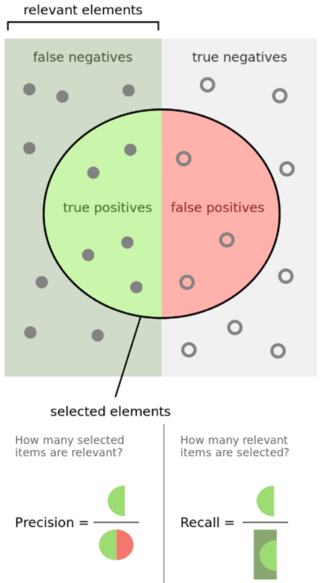

https://towardsdatascience.com/how-to-evaluate-your-machine-learning-models-with-python-code-5f8d2d8d945b